Import relevant packages and libraries


In [ ]:
# Import packages
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
%pip install pmdarima --quiet
import pmdarima as pm

Import Dataset and Clean Data

In [ ]:
# import dataset
data = pd.read_csv("../shelter_neighbourhood_features_pca.csv")

In [ ]:
### CLEAN DATA ###

# # extract Toronto only shelters:
data = data[data["LOCATION_CITY"] == "Toronto"]

# # drop columns that are not useful
data = data.drop(columns=["_id",
                          "ORGANIZATION_ID", 
                          "ORGANIZATION_NAME", 
                          "SHELTER_ID", 
                          "SHELTER_GROUP", 
                          "LOCATION_ID", 
                          "LOCATION_ADDRESS", 
                          "LOCATION_POSTAL_CODE", 
                          "LOCATION_CITY", 
                          "LOCATION_PROVINCE", 
                          "PROGRAM_ID", 
                          "PROGRAM_NAME", 
                          "SECTOR", 
                          "PROGRAM_MODEL",
                          "OVERNIGHT_SERVICE_TYPE", 
                          "PROGRAM_AREA",
                          "OVERNIGHT_SERVICE_TYPE",
                          "CAPACITY_TYPE",
                          "CAPACITY_ACTUAL_BED",
                          "CAPACITY_FUNDING_BED",
                          "OCCUPIED_BEDS",
                          "UNOCCUPIED_BEDS",
                          "UNAVAILABLE_BEDS",
                          "CAPACITY_ACTUAL_ROOM",
                          "CAPACITY_FUNDING_ROOM",
                          "OCCUPIED_ROOMS",
                          "UNOCCUPIED_ROOMS",
                          "UNAVAILABLE_ROOMS",
                          "OCCUPANCY_RATE_BEDS",
                          "OCCUPANCY_RATE_ROOMS", 
                          "LAT",
                          "LON",
                          "Neighbourhood Number"])



In [ ]:
# set the OCCUPANCY DATE as index
data = data.set_index(["OCCUPANCY_DATE"])

# convert to OCCUPANCY DATE to datetime format
data.index = pd.to_datetime(data.index)
# data = data.set_index(["OCCUPANCY_DATE"])

# aggregate the service user count
data1= data.groupby(["Neighbourhood", data.index]).agg({'SERVICE_USER_COUNT': 'sum'}).reset_index()

Separate into training data and testing data


In [ ]:
# data_exo  - the exogenous variables
data_exo = data.drop(columns=["LOCATION_NAME",
                          "SERVICE_USER_COUNT"])

In [ ]:
# add in the pca variables 
data1_exo = pd.merge(data1, data_exo, on=['OCCUPANCY_DATE', 'Neighbourhood'], how='left')
data1_exo = data1_exo.drop_duplicates()

In [ ]:
# set index as date-time
data1_exo = data1_exo.set_index(["OCCUPANCY_DATE"])

In [ ]:
# extract training data
train1 = data1_exo[data1_exo.index < pd.to_datetime('2023-01-01')]
test1 = data1_exo[data1_exo.index >= pd.to_datetime('2023-01-01')]

FUNCTIONS

In [ ]:
# Subset Neighbourhood specific data from each of data, test data and train data.
# PARAMETERS: 
#   data - all time series data
#   test - data to be used to test the model
#   train - the training data
#   neighbourhood - the neighbourhood to subset

def subsetNeighbourhood(data, test, train, neighbourhood):
    data = data
    neighbourhood = neighbourhood
    test = test
    train = train

    dataN = data[data["Neighbourhood"] == neighbourhood]
    testN = test[test["Neighbourhood"] == neighbourhood]
    trainN = train[train["Neighbourhood"] == neighbourhood]

    return dataN, testN, trainN

In [ ]:
# Plot the timeseries data

def plotData(dataN, testN, trainN):
    # # plot train 
    # plt.figure(figsize=(15,7))
    # plt.title("Plot of service user counts")
    # plt.xlabel('Date')
    # plt.ylabel('Service user count')
    # plt.plot(trainN["SERVICE_USER_COUNT"])
    # plt.plot()
    # plt.axvline(x=pd.to_datetime("2022-01-01"), color="red", linestyle="--")
    # plt.show()

    # # plot test
    # plt.figure(figsize=(15,7))
    # plt.title("Plot of service user counts")
    # plt.xlabel('Date')
    # plt.ylabel('Service user count')
    # plt.plot(testN["SERVICE_USER_COUNT"])
    # plt.plot()

    # plt.show()

    # plot all  
    plt.figure(figsize=(15,7))
    plt.title("Plot of service user counts")
    plt.xlabel('Date')
    plt.ylabel('Service user count')
    plt.plot(dataN["SERVICE_USER_COUNT"])
    plt.plot()
    plt.axvline(x=pd.to_datetime("2022-01-01"), color="red", linestyle="--")
    plt.axvline(x=pd.to_datetime("2023-01-01"), color="red", linestyle="--")
    plt.show()

In [26]:
# Train the timeseries model on the training data
# Parameters:
#   trainN - the training time series data

def timeseriesModel(trainN):
    # SARIMAX_model = pm.auto_arima(trainN[['SERVICE_USER_COUNT']], 
    #                 #   exogenous=data_Annex.iloc[:, 2:],
    #                 start_p=1, 
    #                 start_q=1,
    #                 test='adf',
    #                 max_p=3, 
    #                 max_q=3, 
    #                 max_d=2,
    #                 m=365,
    #                 seasonal=True,
    #                 # d=None, 
    #                 start_P = 1,
    #                 max_P = 3,
    #                 D=1,
    #                 error_action='ignore',  
    #                 suppress_warnings=False, 
    #                 stepwise=True,
    #                 n_jobs= -1,
    #                 stationary= True,
    #                 trace=True,
    #                 transparams = True,
    #                 scoring='mse')

    SARIMAX_model = pm.auto_arima(trainN[['SERVICE_USER_COUNT']], 
                                exogenous=trainN.iloc[:, 2:],
                                start_p=1, start_q=1,
                                test='adf',
                                max_p=3, max_q=3, 
                                # m=365,
                                start_P=0, seasonal=True,
                                d=None, D=1, 
                                trace=False,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True,
                                n_jobs=-1,
                                scoring="mse")
    
    print(SARIMAX_model)
    return SARIMAX_model

In [ ]:
# Plot the time series model's predicted values and the actual data
def plotTimeseries(SARIMAX_model, dataN, trainN, testN):
    # Forecast
    df = trainN
    all = dataN
    n_periods = 365

    # get indices for new dataframe
    forecast_df = pd.DataFrame({"day_index":pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D').day},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))

    # get predictions and confidence intervals
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df.iloc[:, 2:]
                                            )
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(all['SERVICE_USER_COUNT'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    plt.axvline(x=pd.to_datetime("2022-01-01"), color="red", linestyle="--")
    plt.axvline(x=pd.to_datetime("2023-01-01"), color="red", linestyle="--")
    plt.title("SARIMAX - Forecast of Service Users")
    plt.show()

    return fitted_series, lower_series, upper_series

In [ ]:
# Calculate the MSE
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def calcEval(test, forecast):
    mse = mean_squared_error(test, forecast[0:len(test),])
    print("MSE: ", mse)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)
    mae = mean_absolute_error(test, forecast[0:len(test),])
    print("MAE: ", mae)

    return mse, rmse, mae

ANALYSIS OF DATA AND PLOTS

Annex


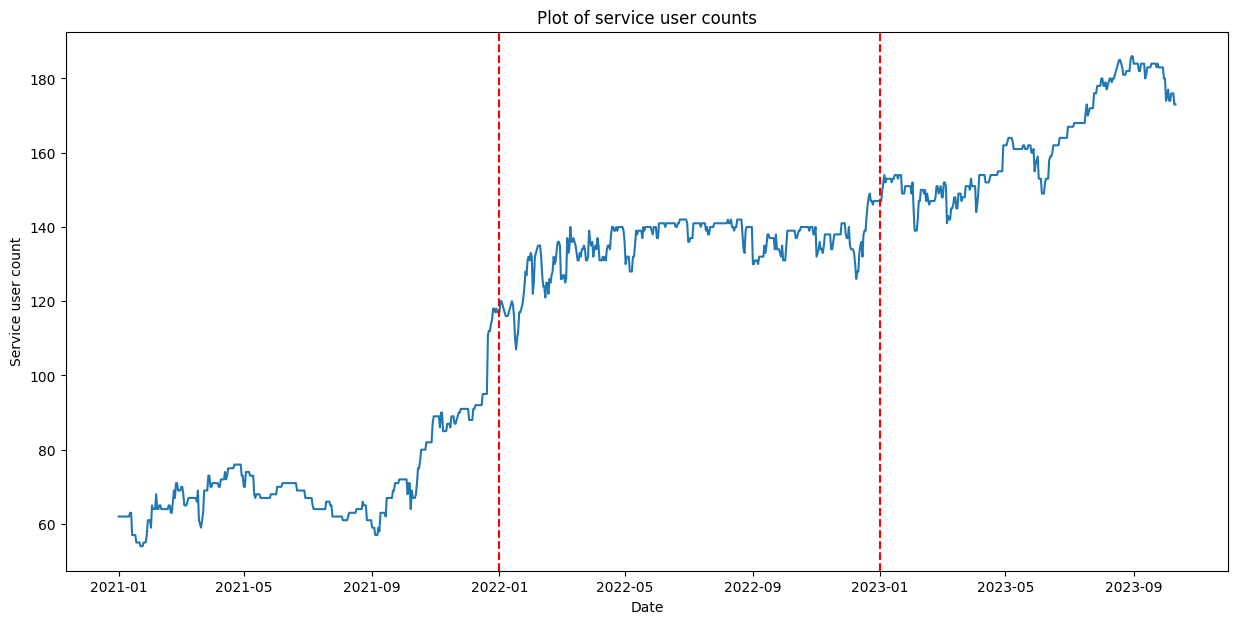

Bendale-Glen Andrew


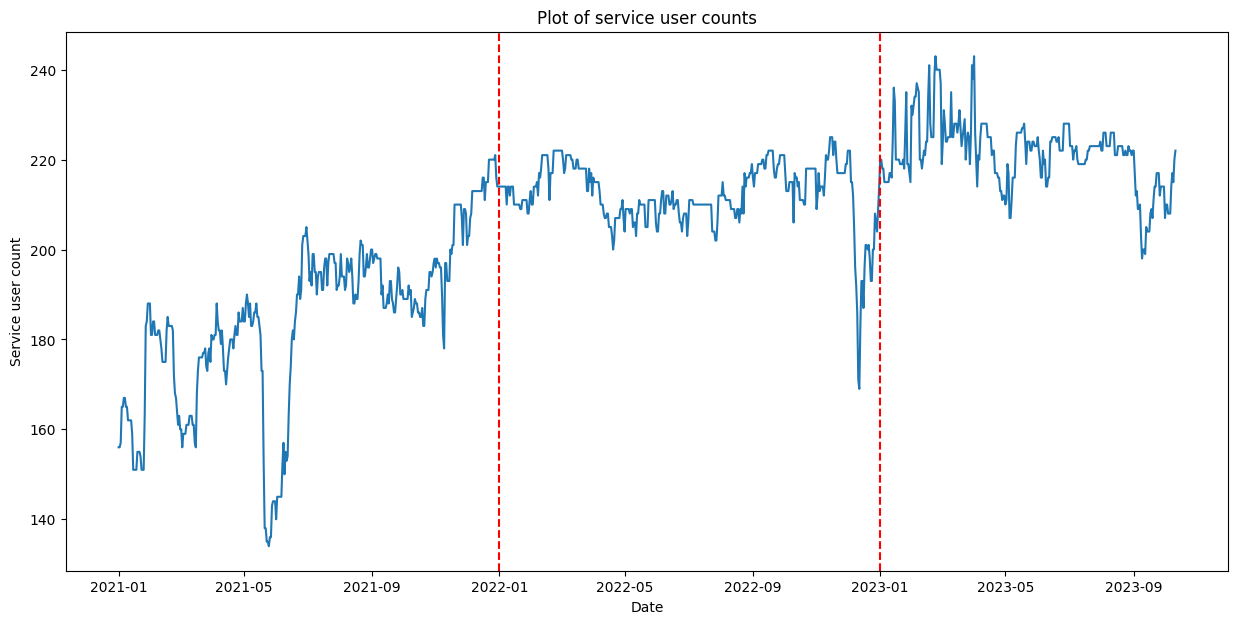

Broadview North


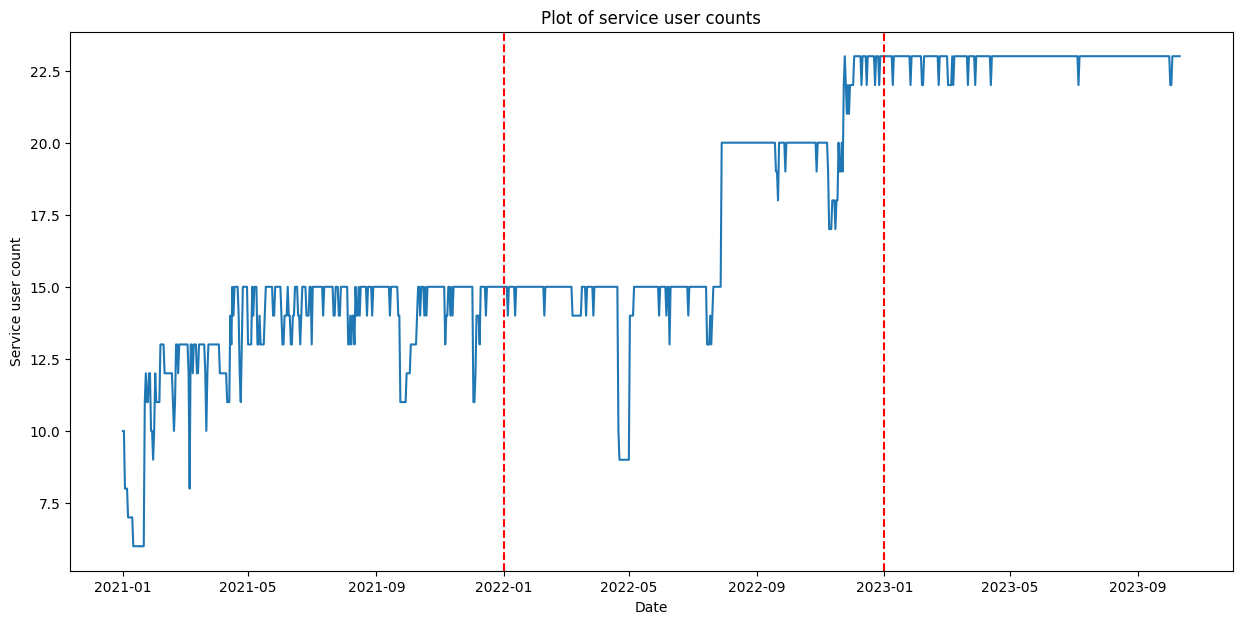

Caledonia-Fairbank


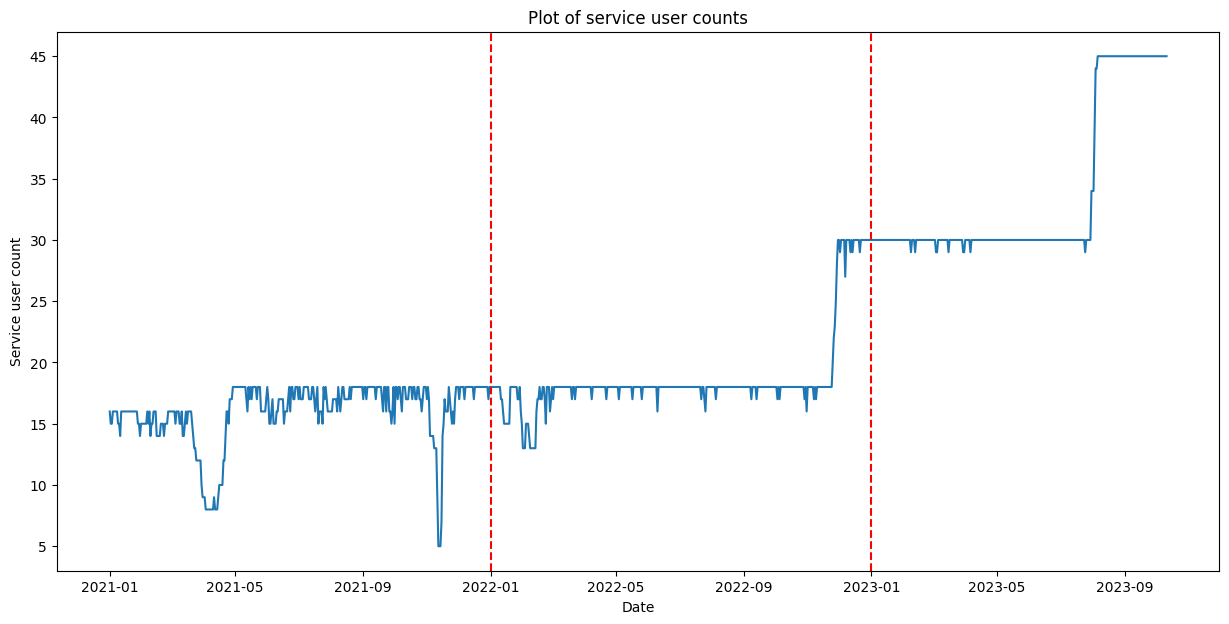

Church-Wellesley


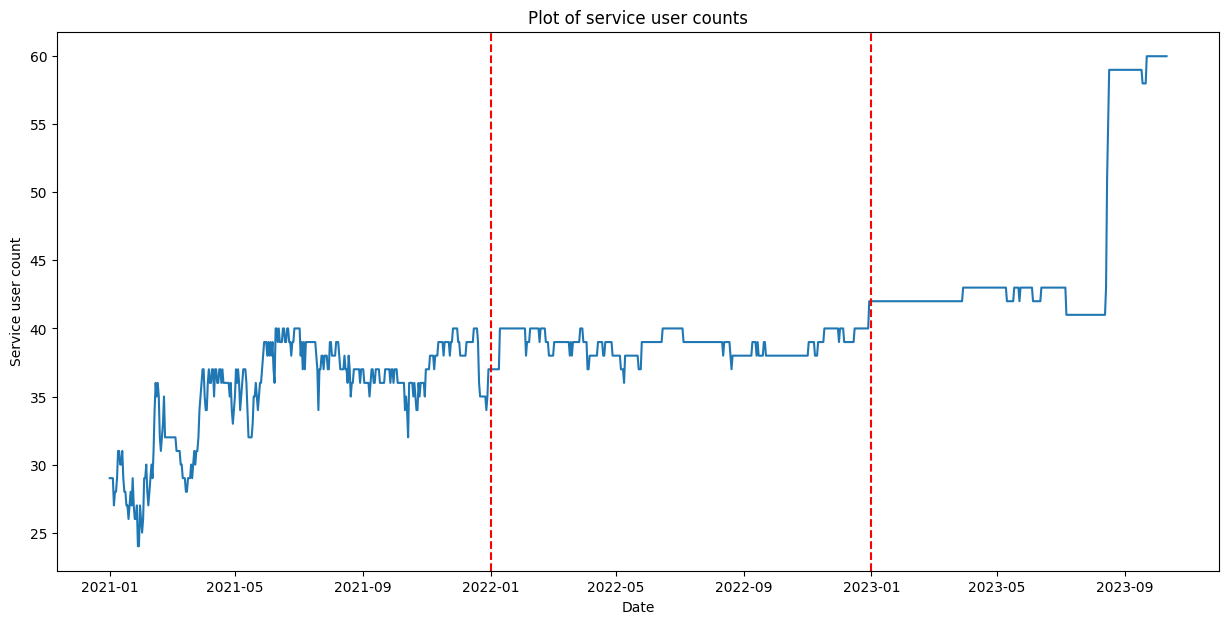

Dovercourt Village


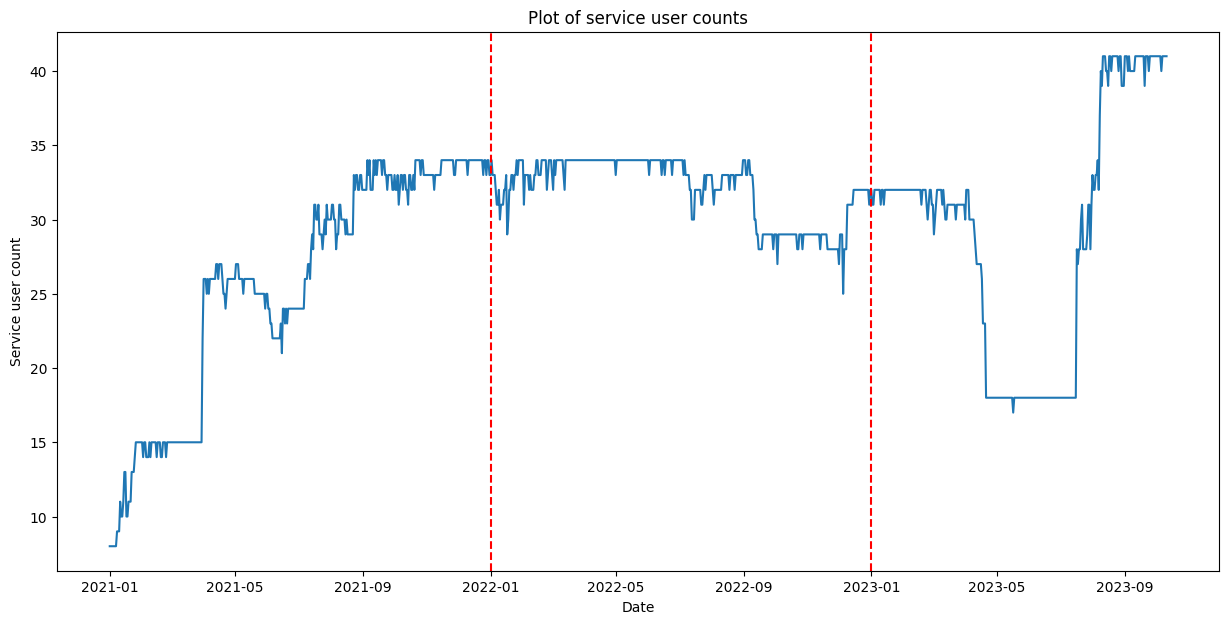

Downsview


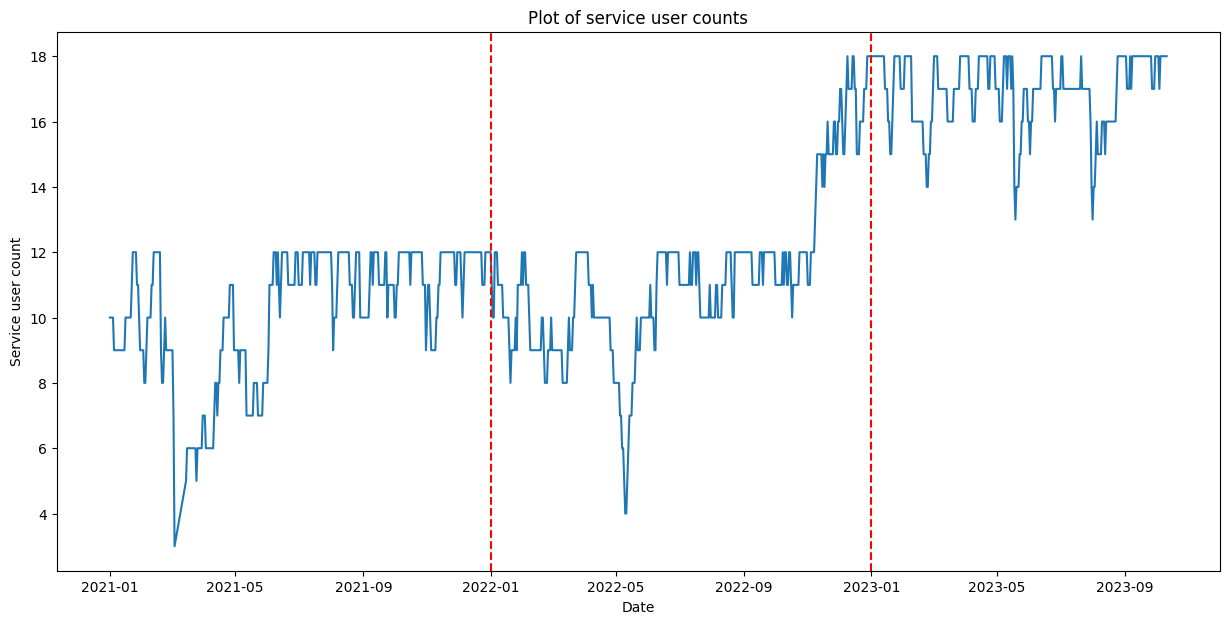

Downtown Yonge East


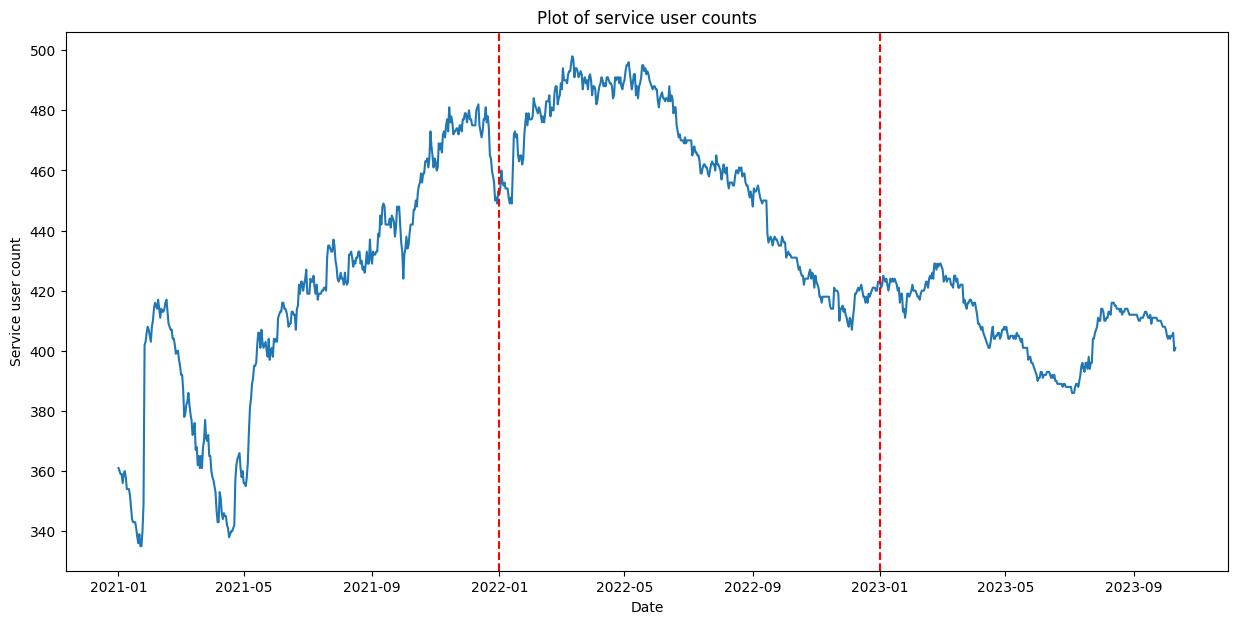

East End-Danforth


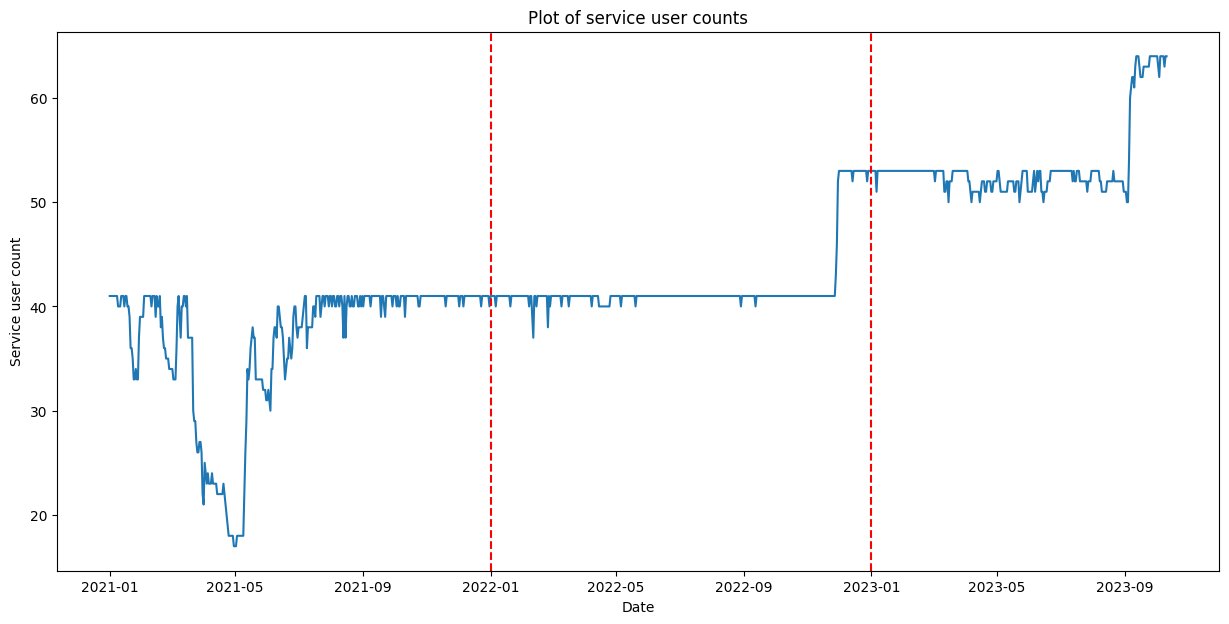

East Willowdale


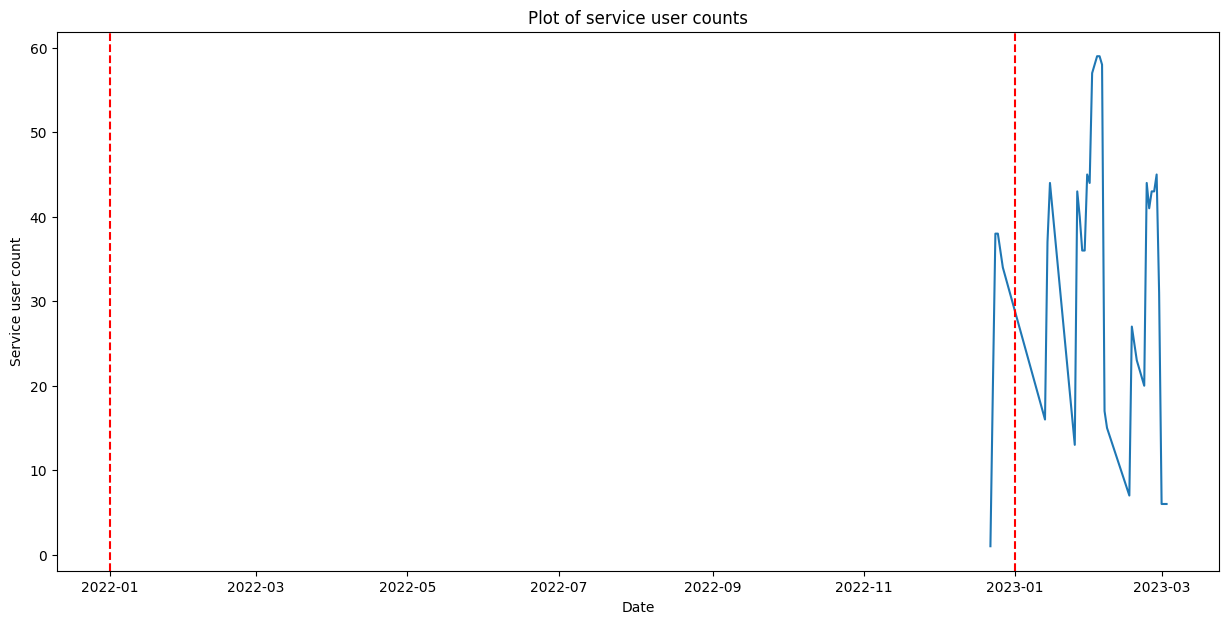

Fort York-Liberty Village


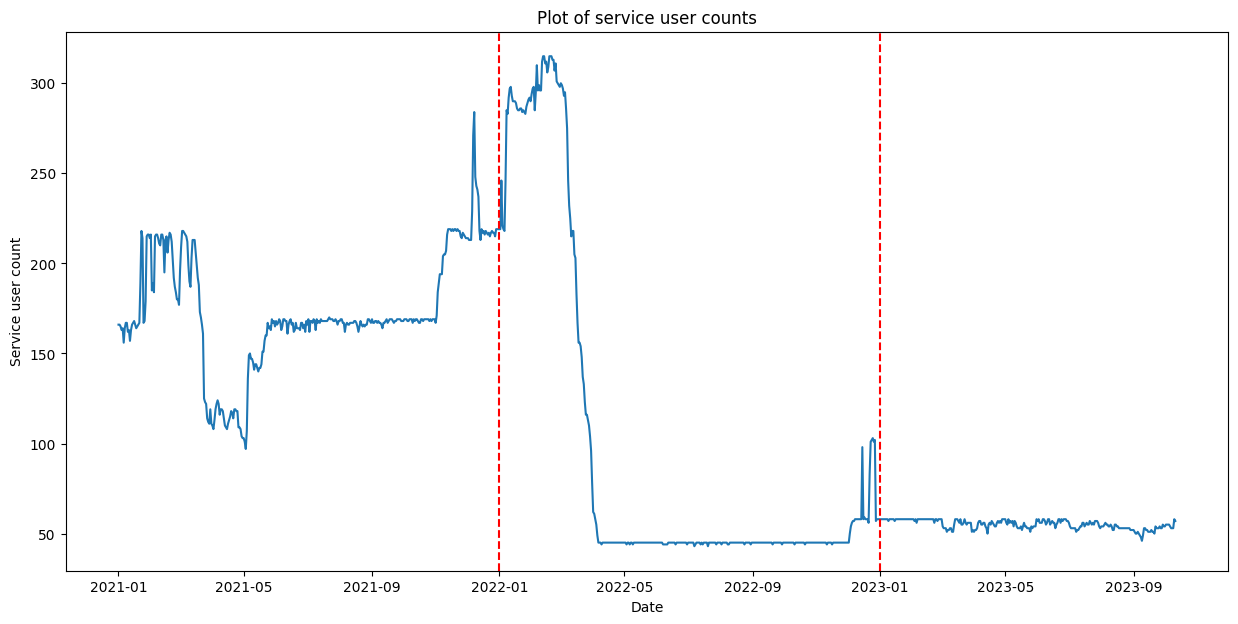

Harbourfront-CityPlace


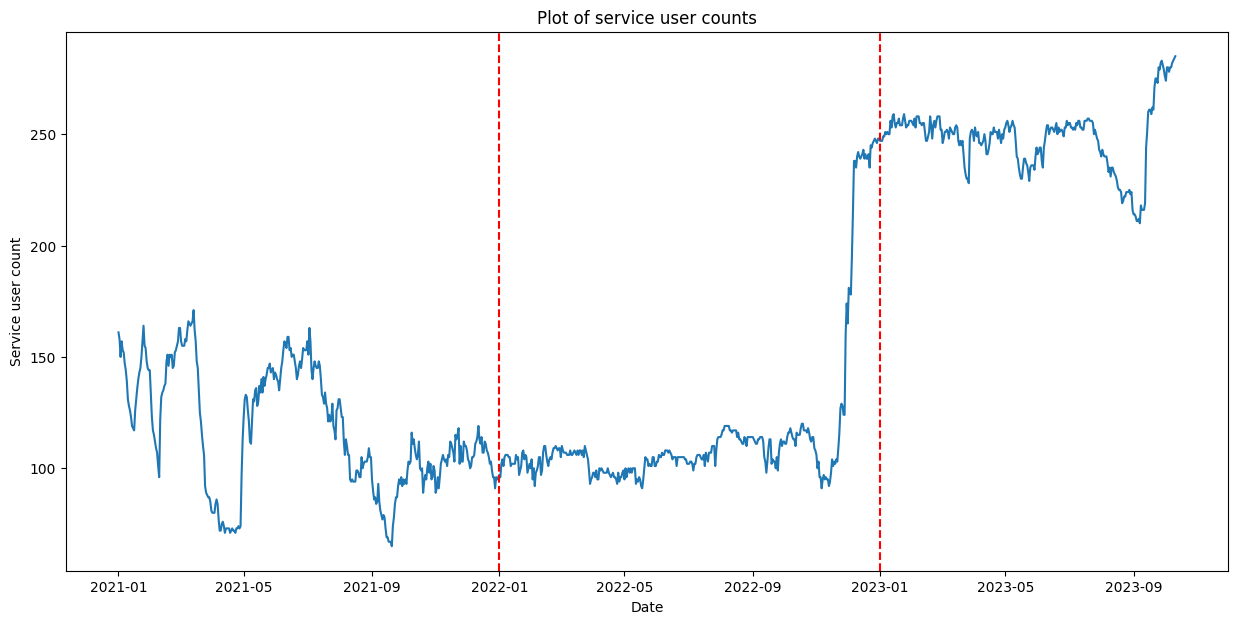

High Park-Swansea


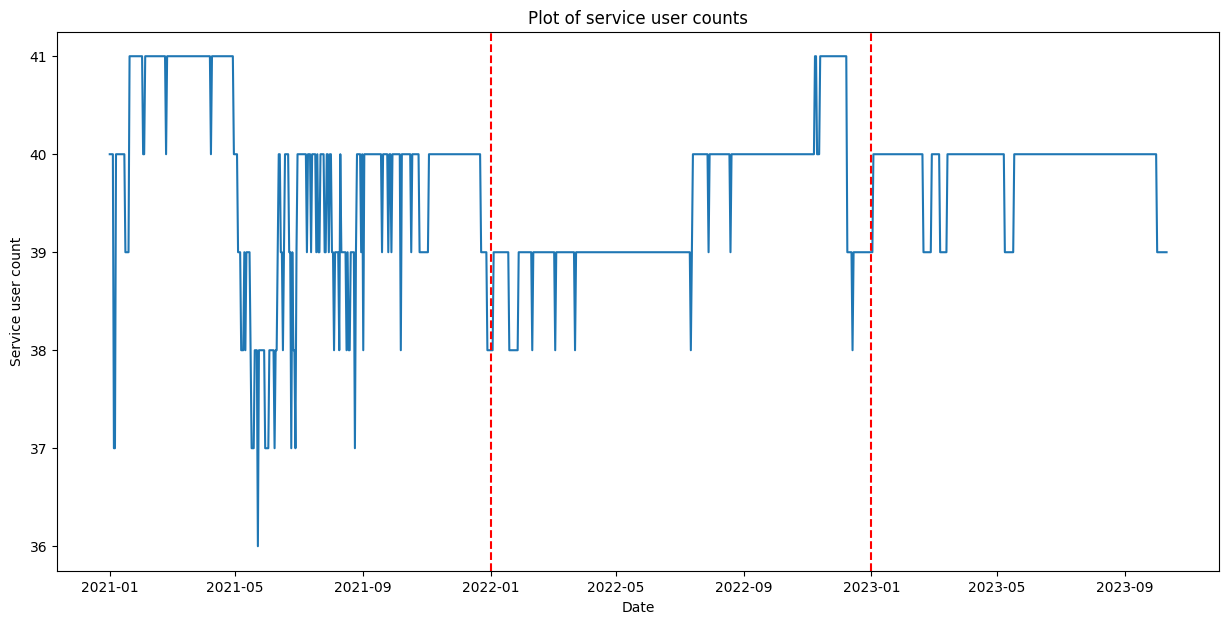

Hillcrest Village


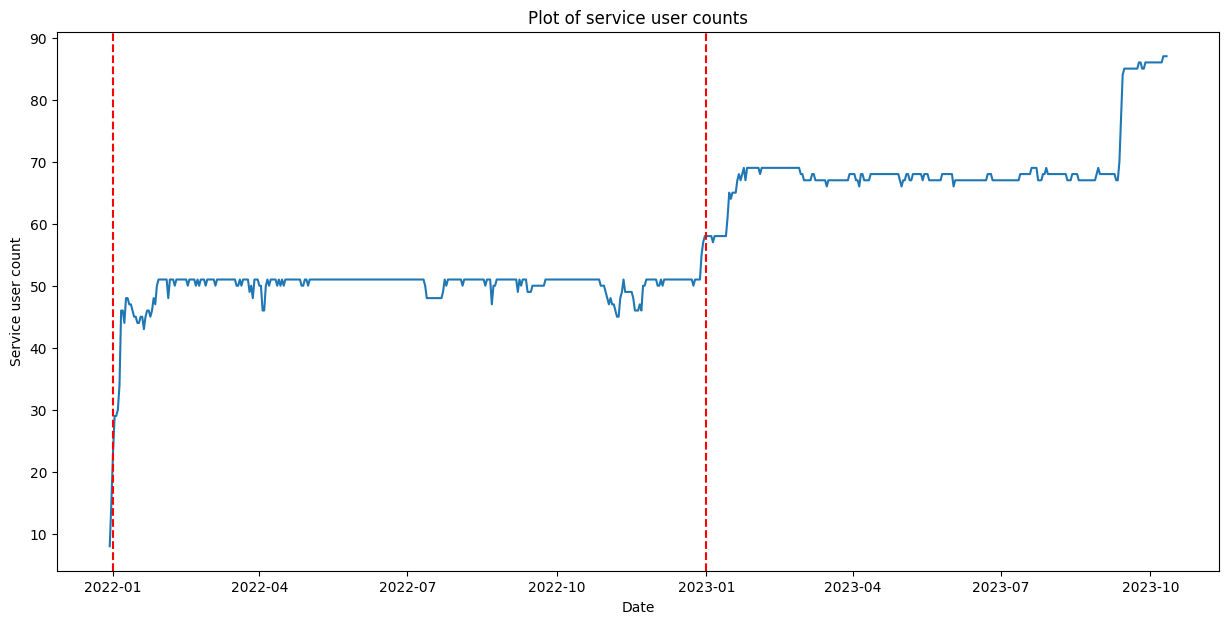

Junction Area


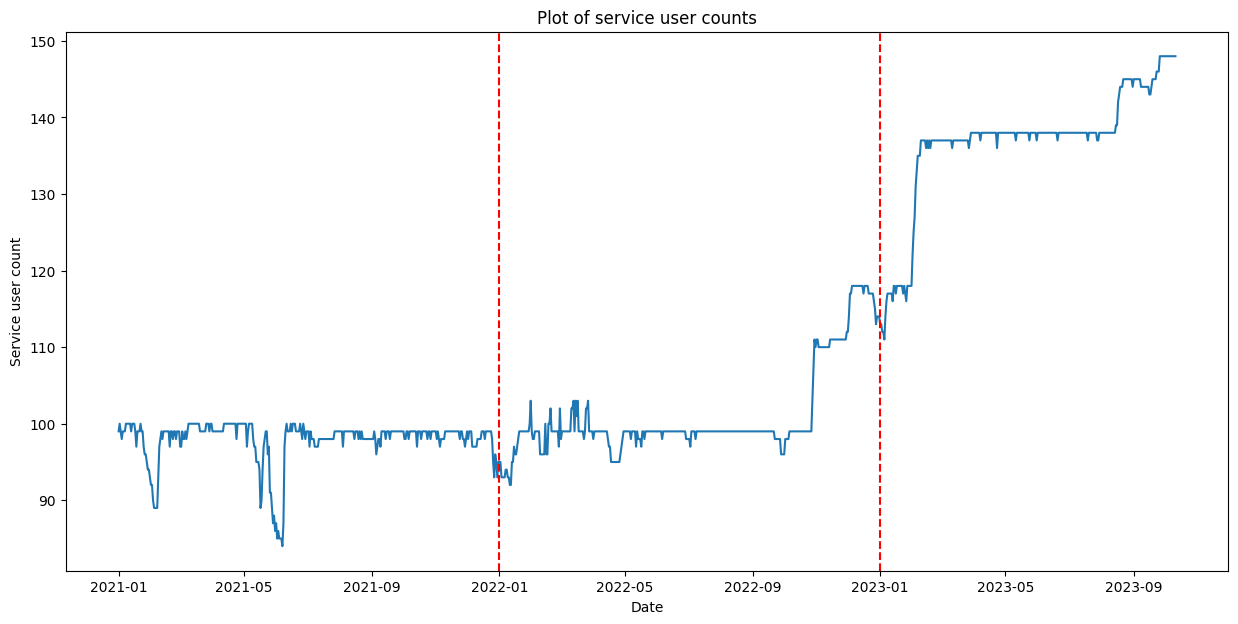

Junction-Wallace Emerson


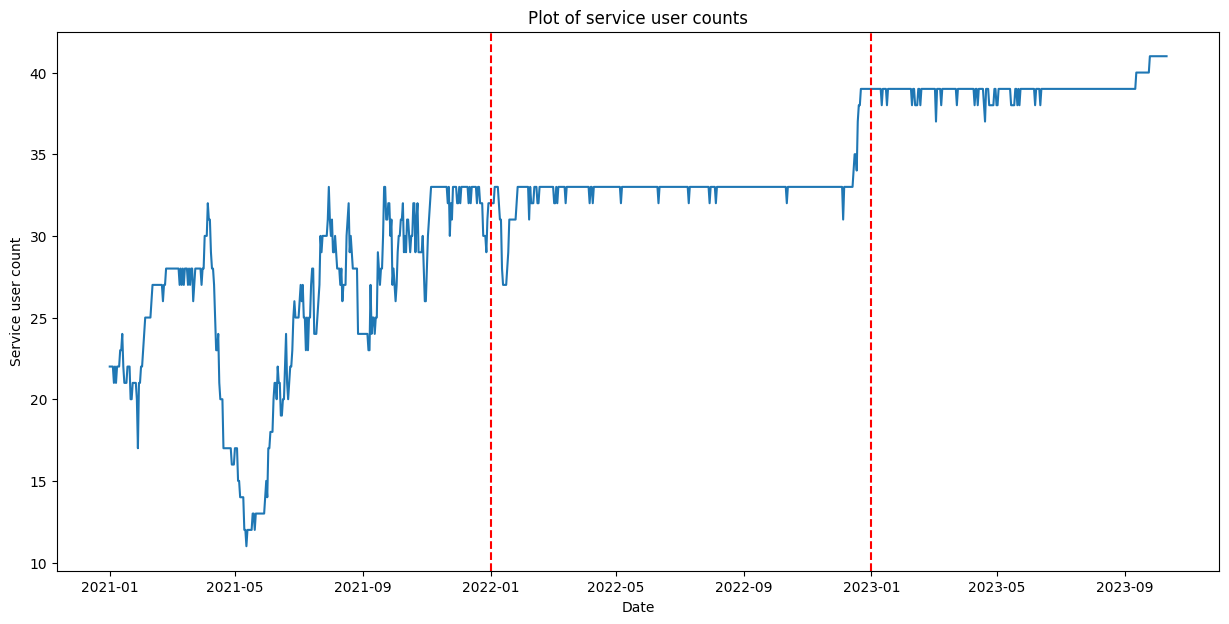

Kennedy Park


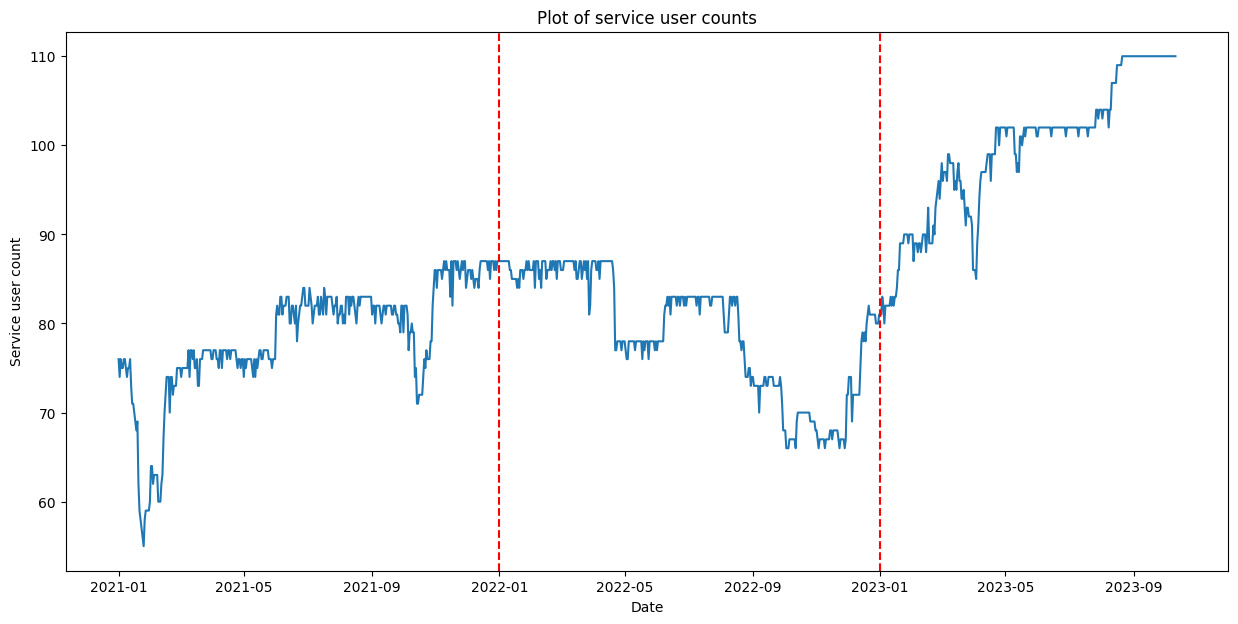

Kensington-Chinatown


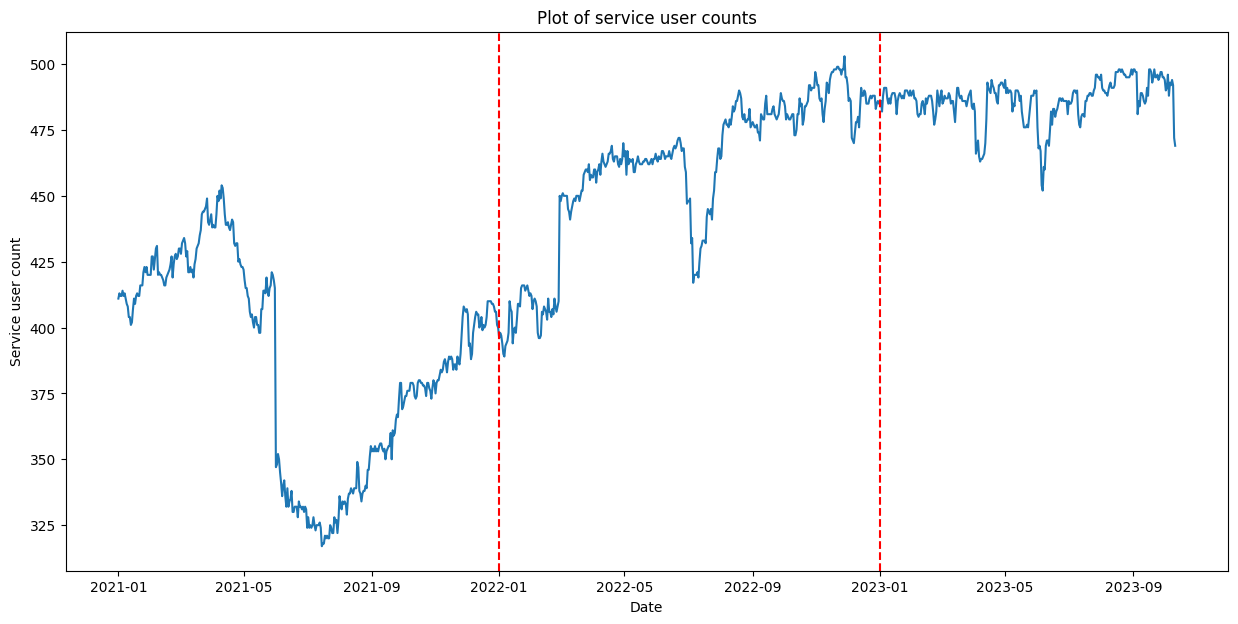

Little Portugal


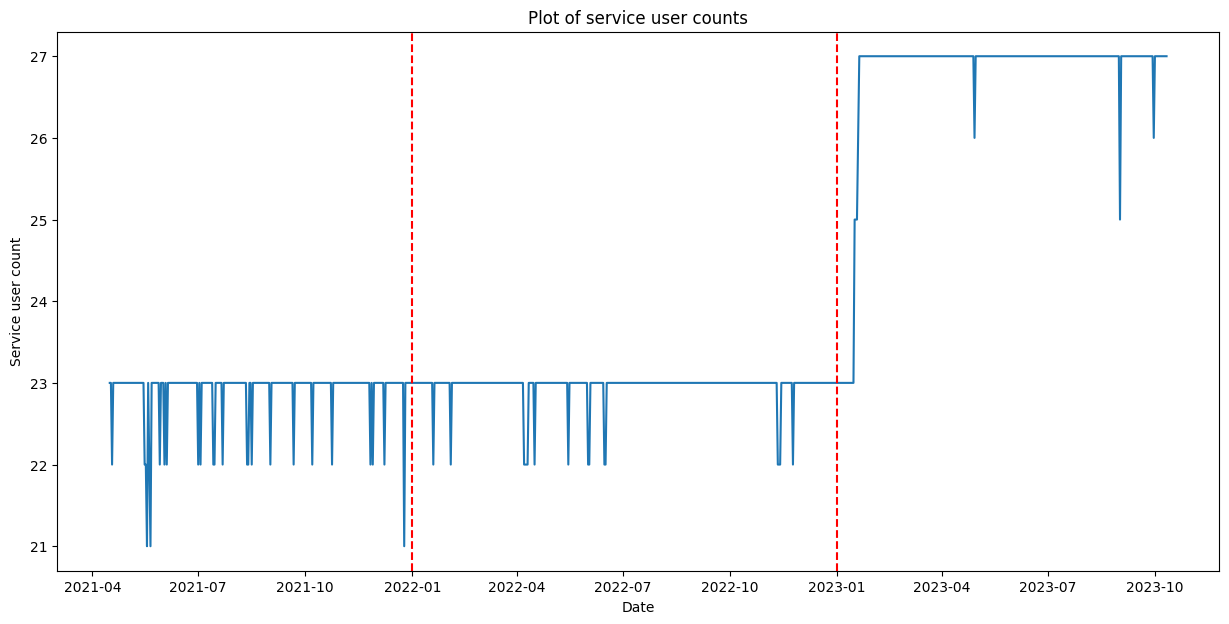

Mimico-Queensway


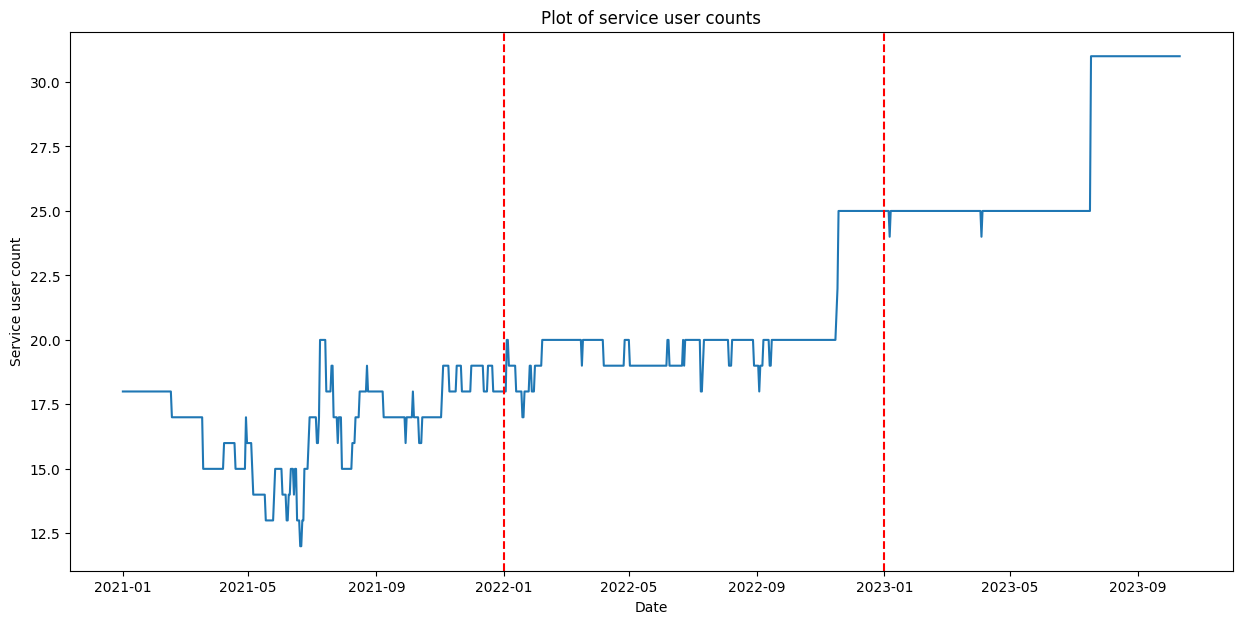

Moss Park


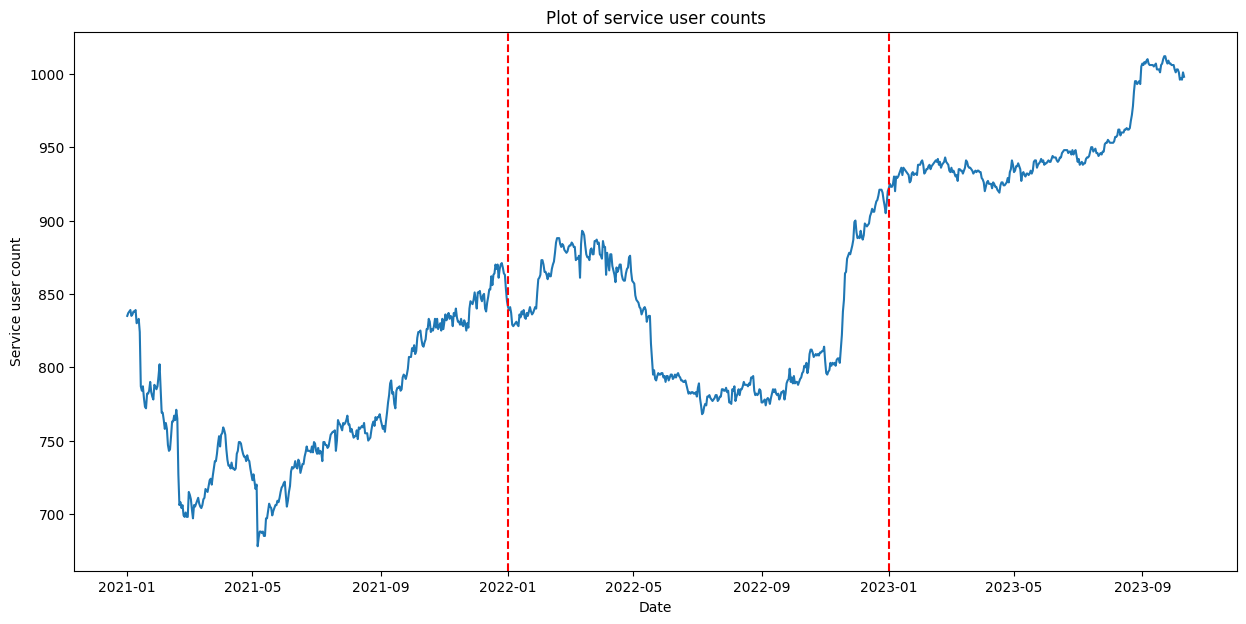

Newtonbrook East


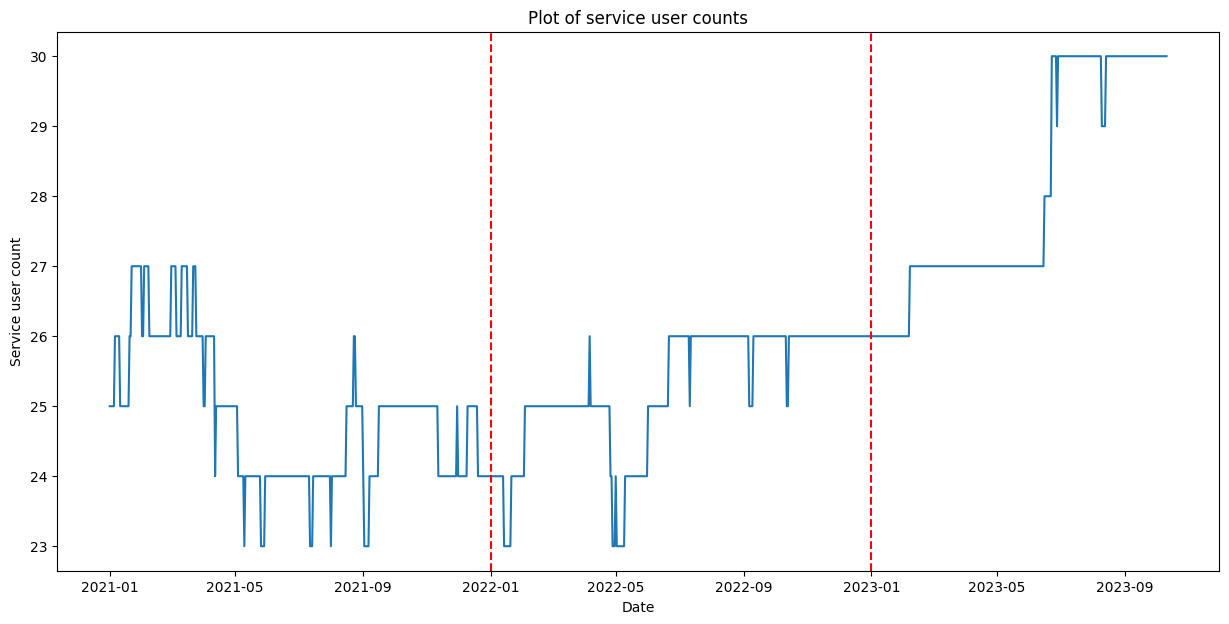

North St.James Town


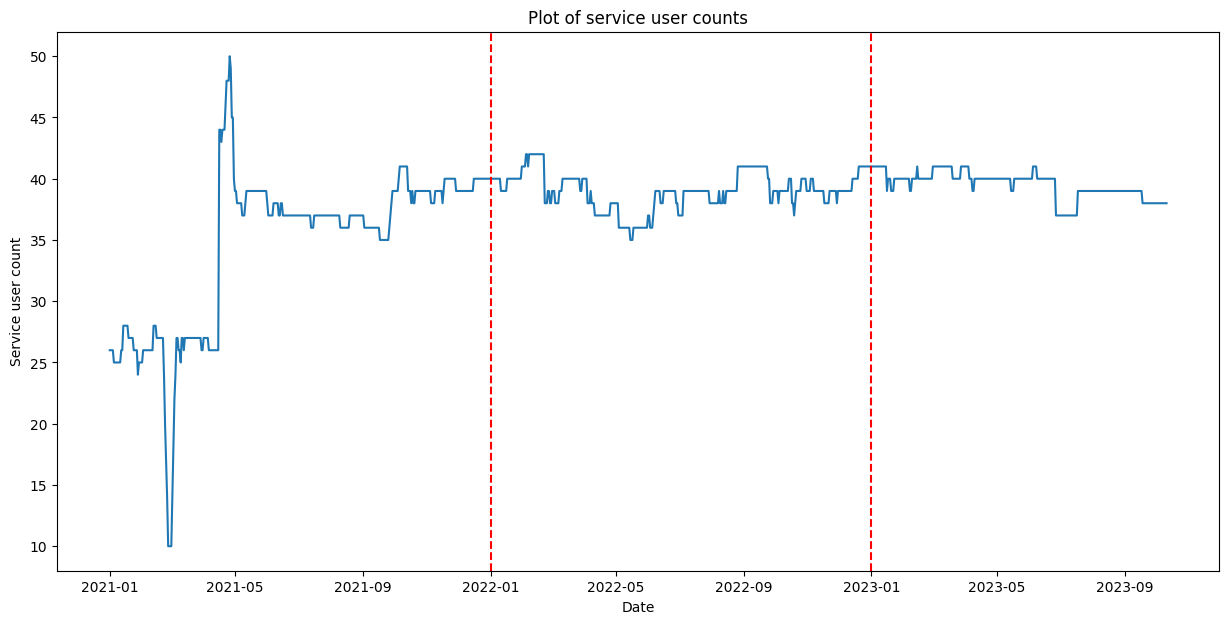

North Toronto


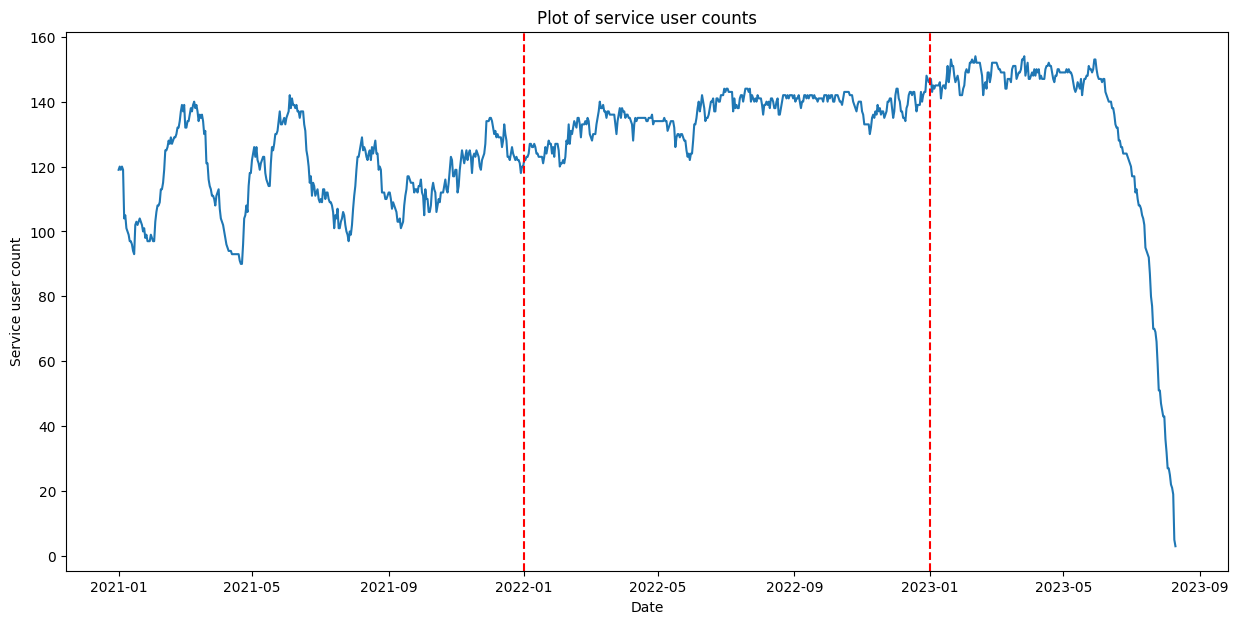

Oakwood Village


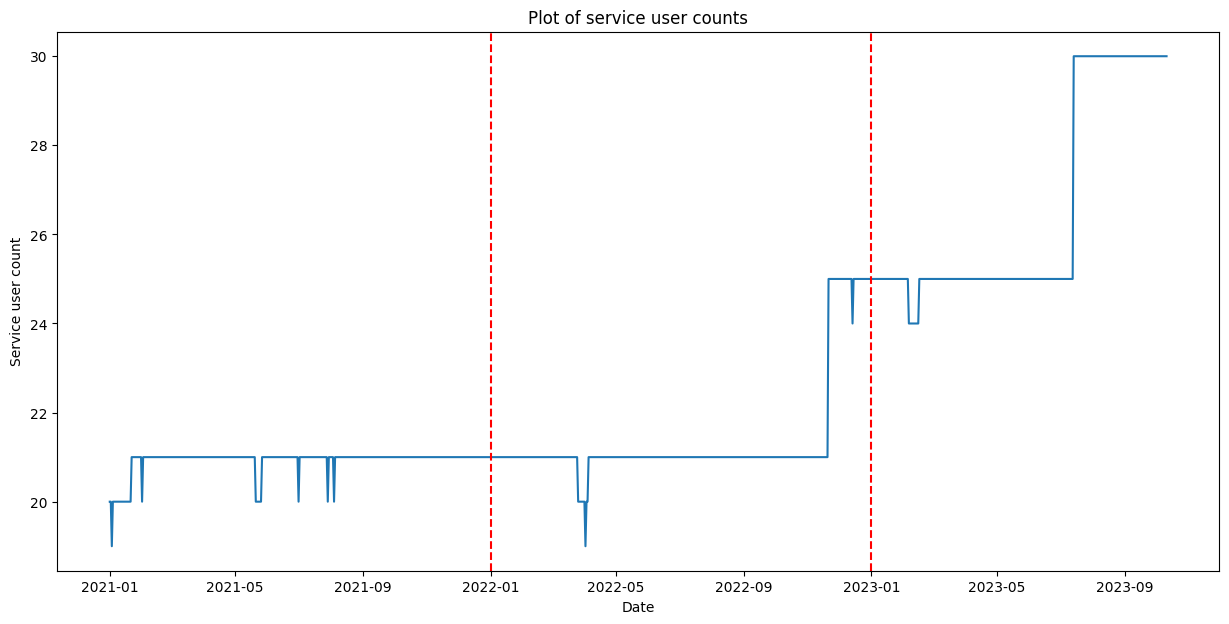

Palmerston-Little Italy


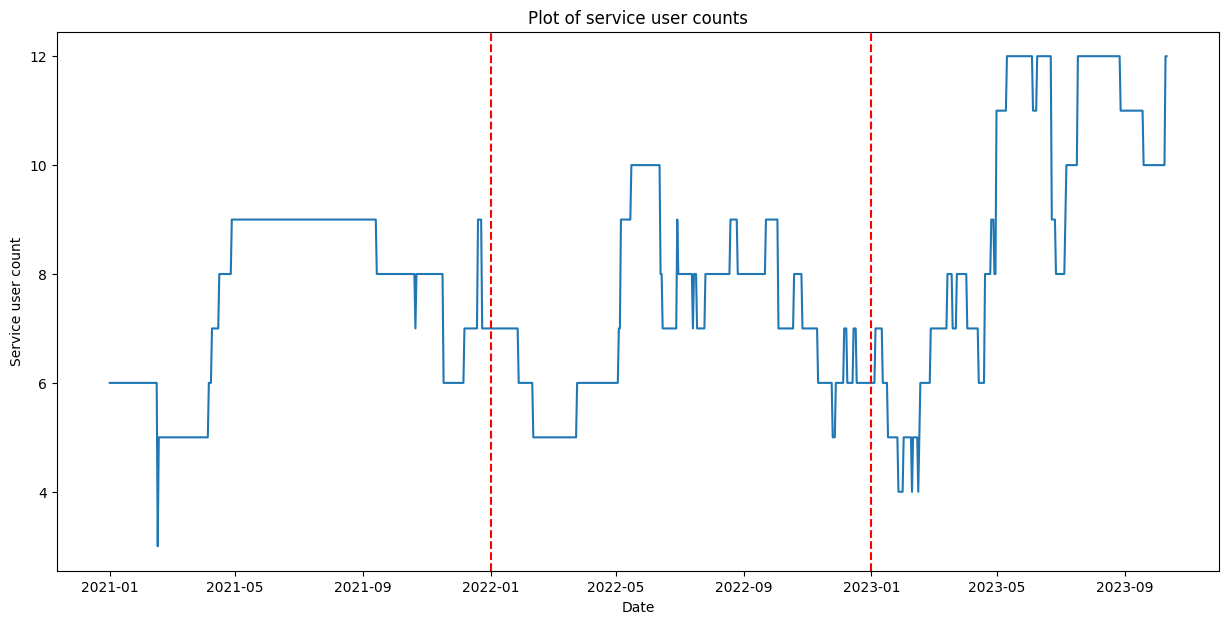

Regent Park


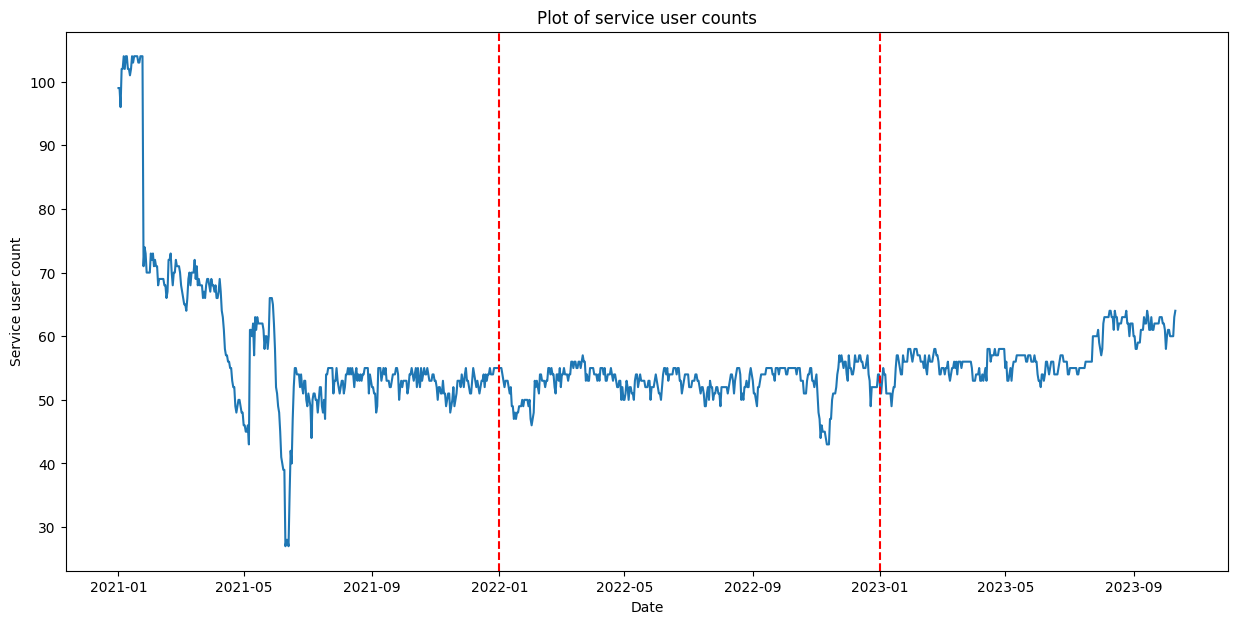

Rosedale-Moore Park


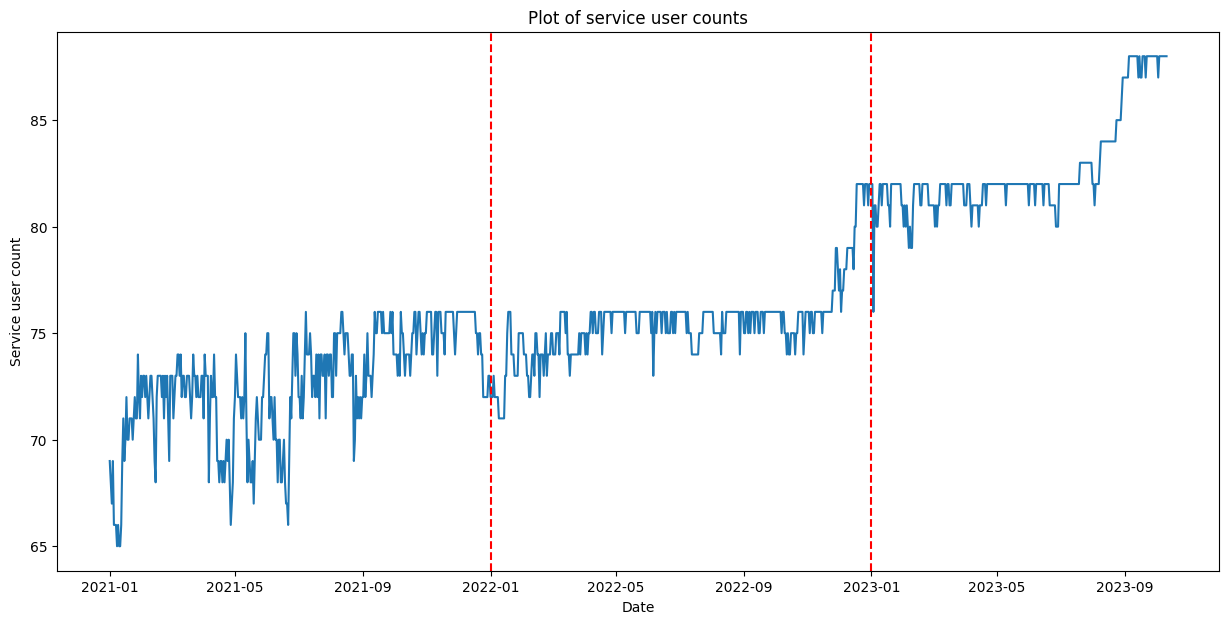

Scarborough Village


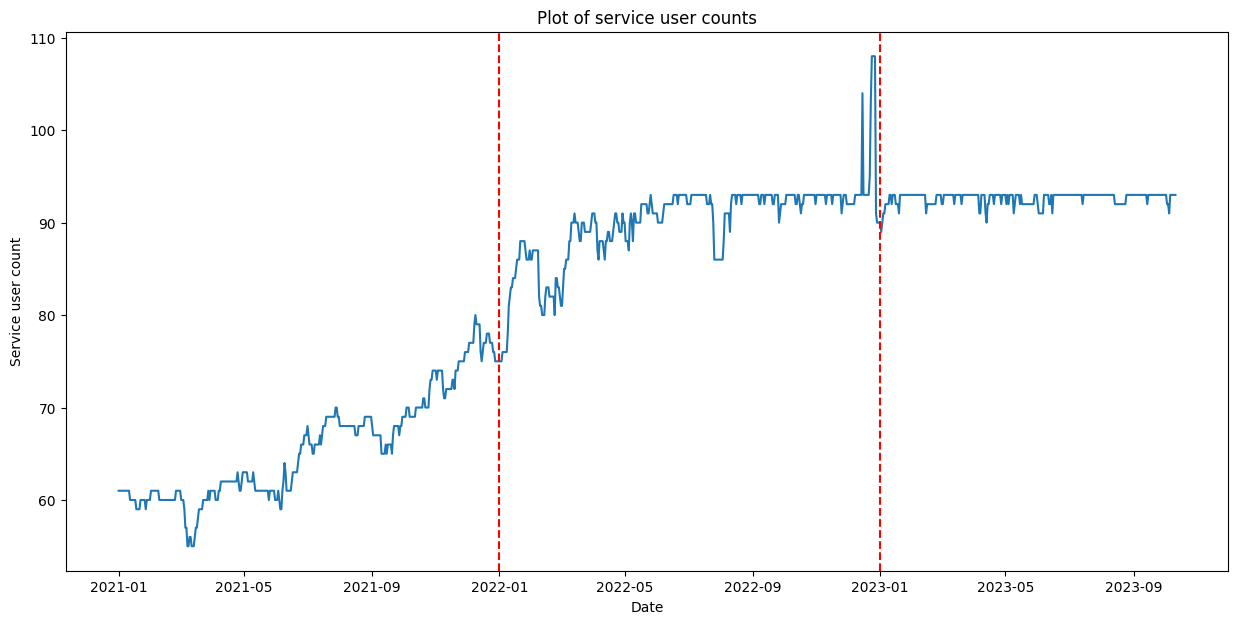

South Parkdale


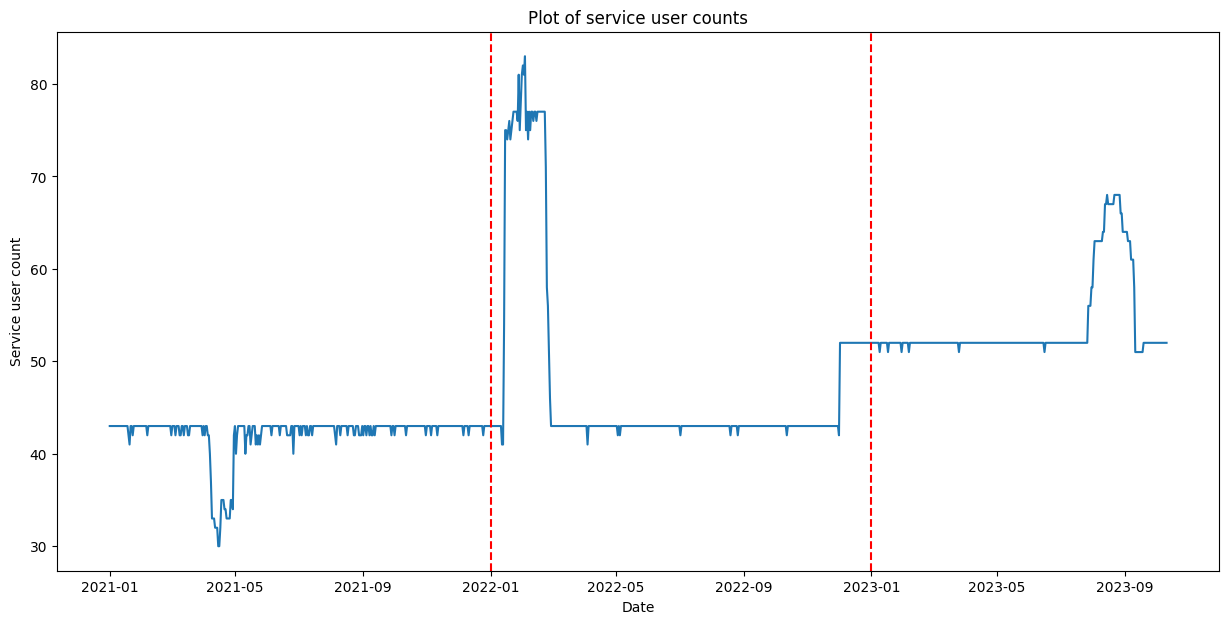

South Riverdale


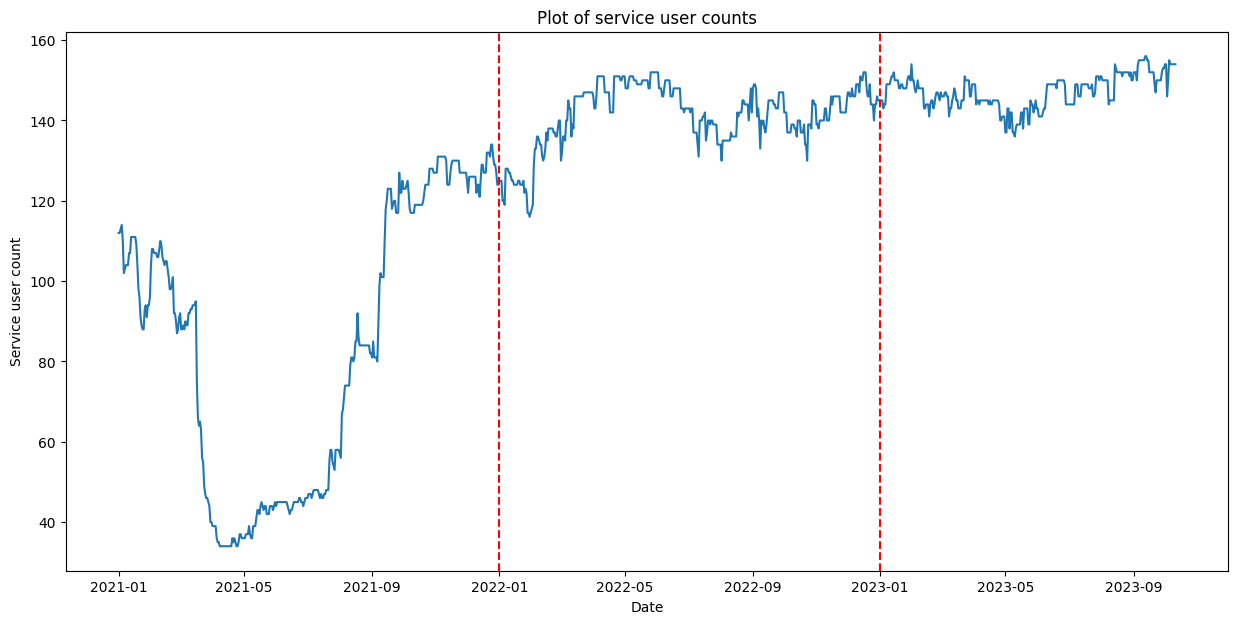

St Lawrence-East Bayfront-The Islands


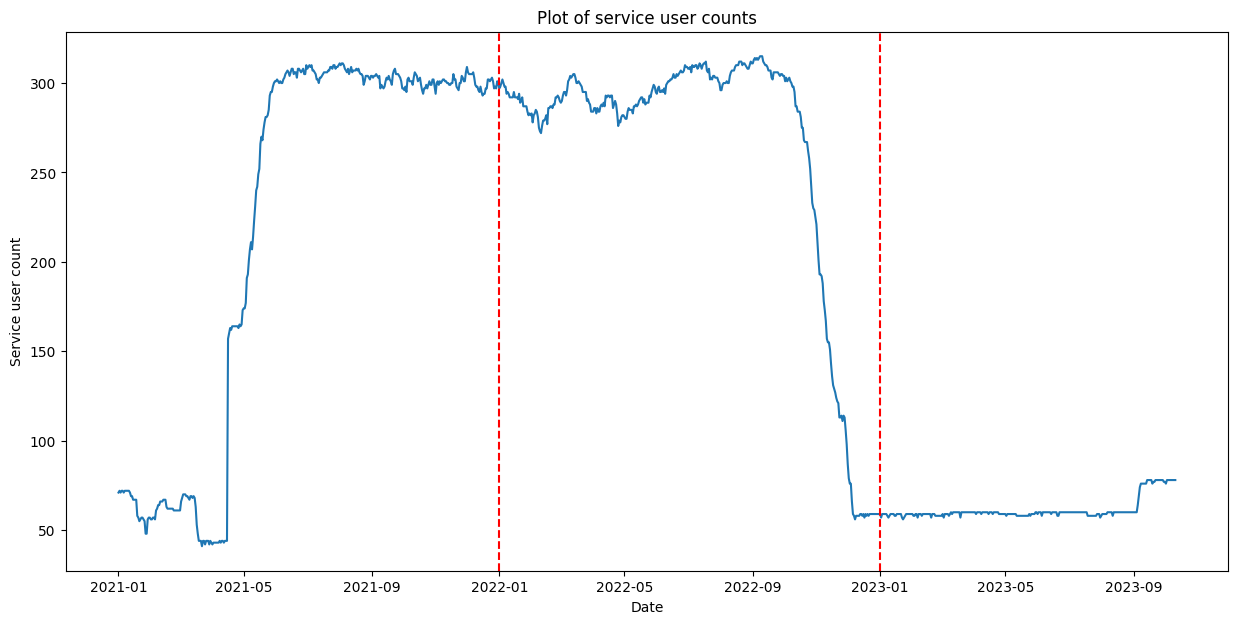

St.Andrew-Windfields


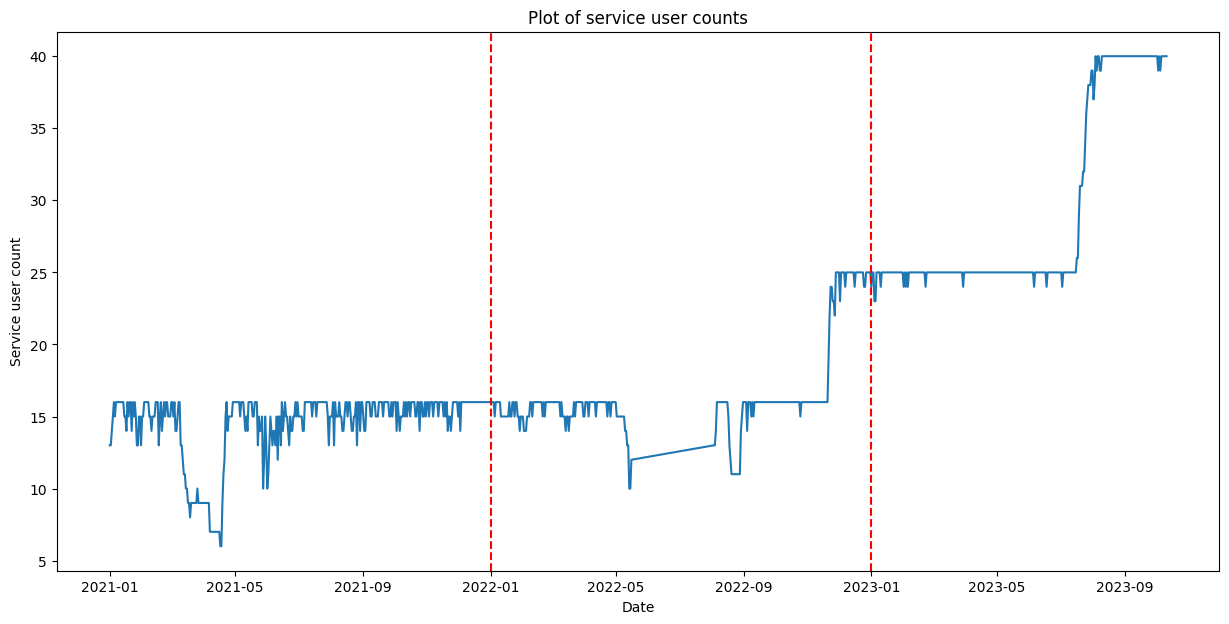

Thistletown-Beaumond Heights


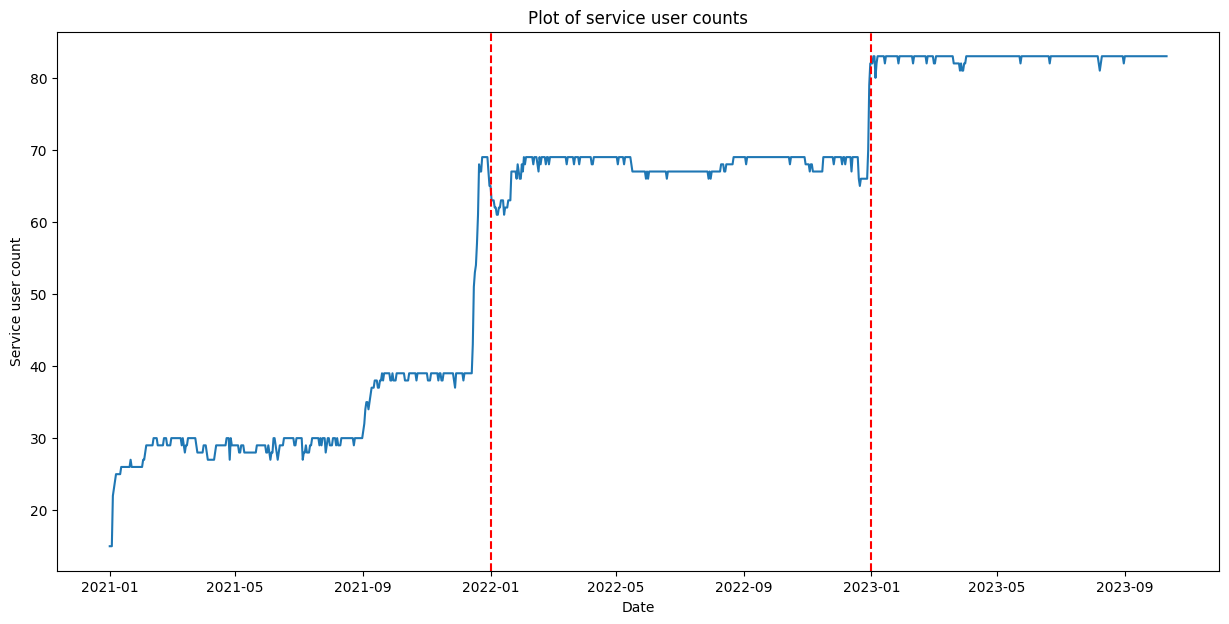

Trinity-Bellwoods


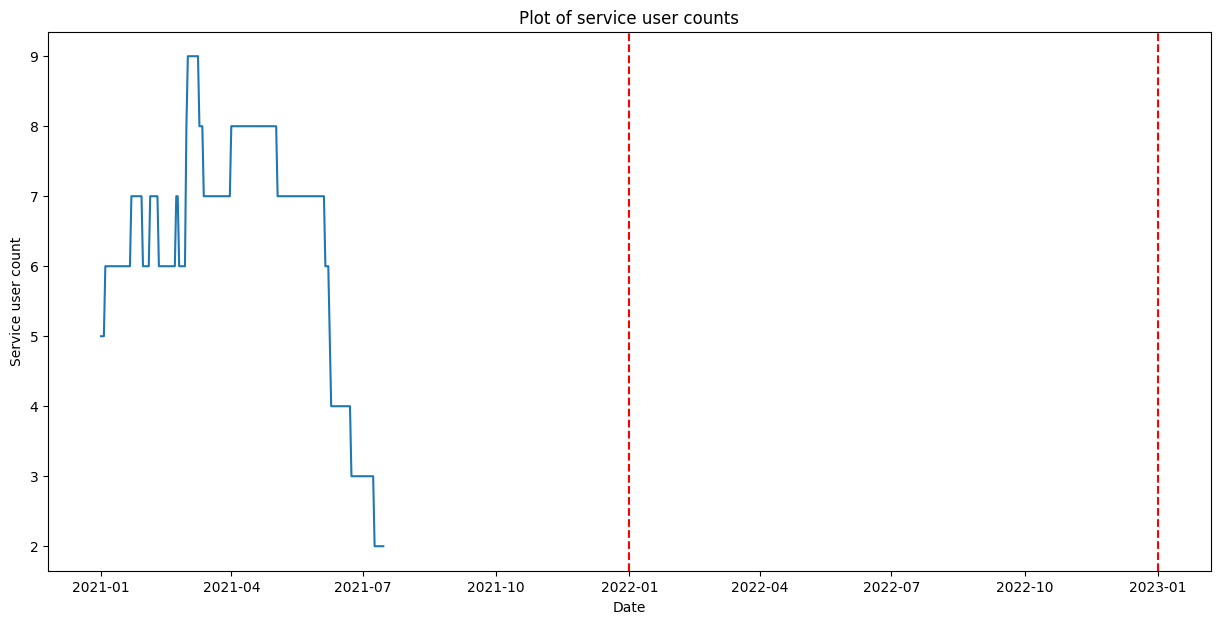

University


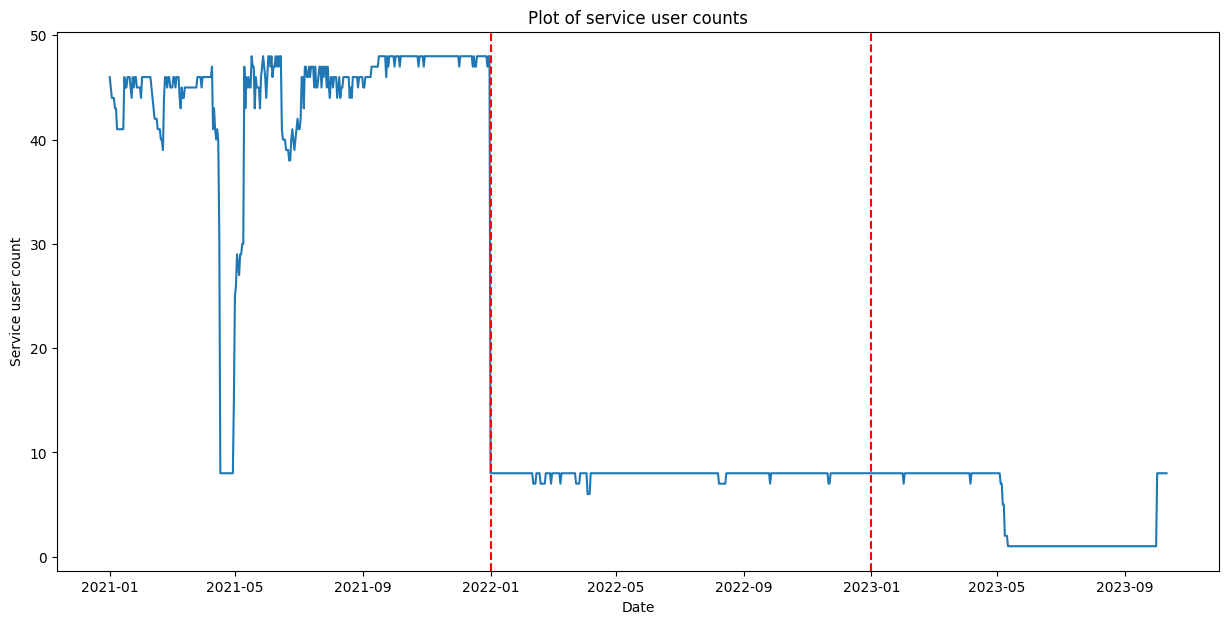

Wellington Place


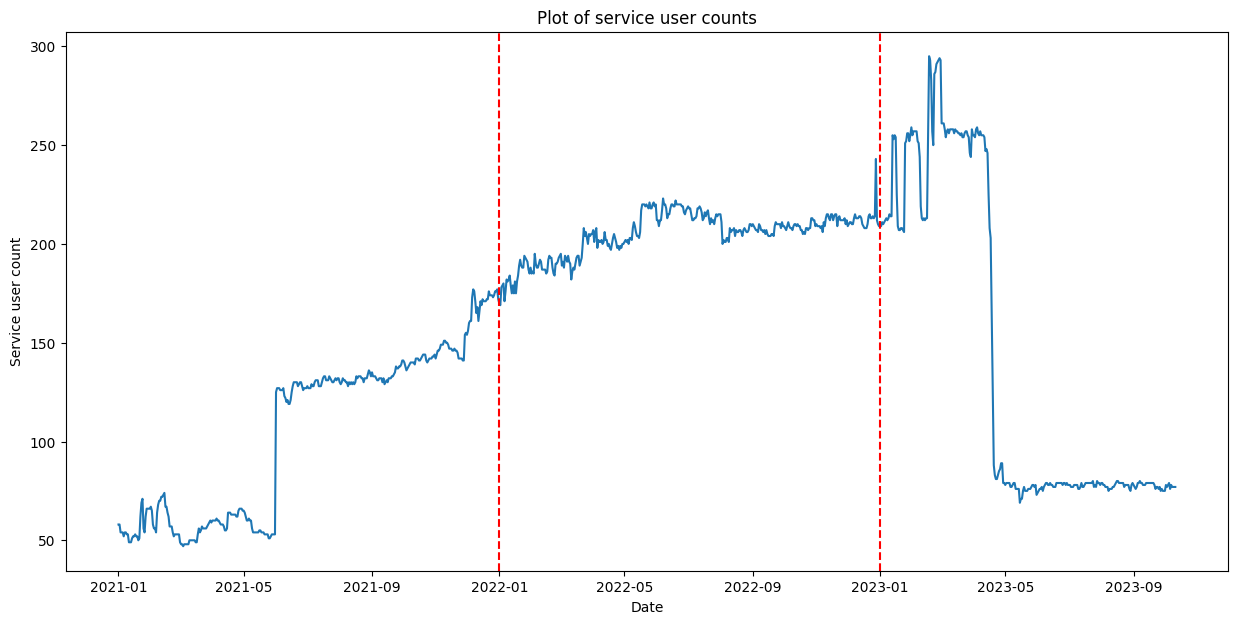

West Hill


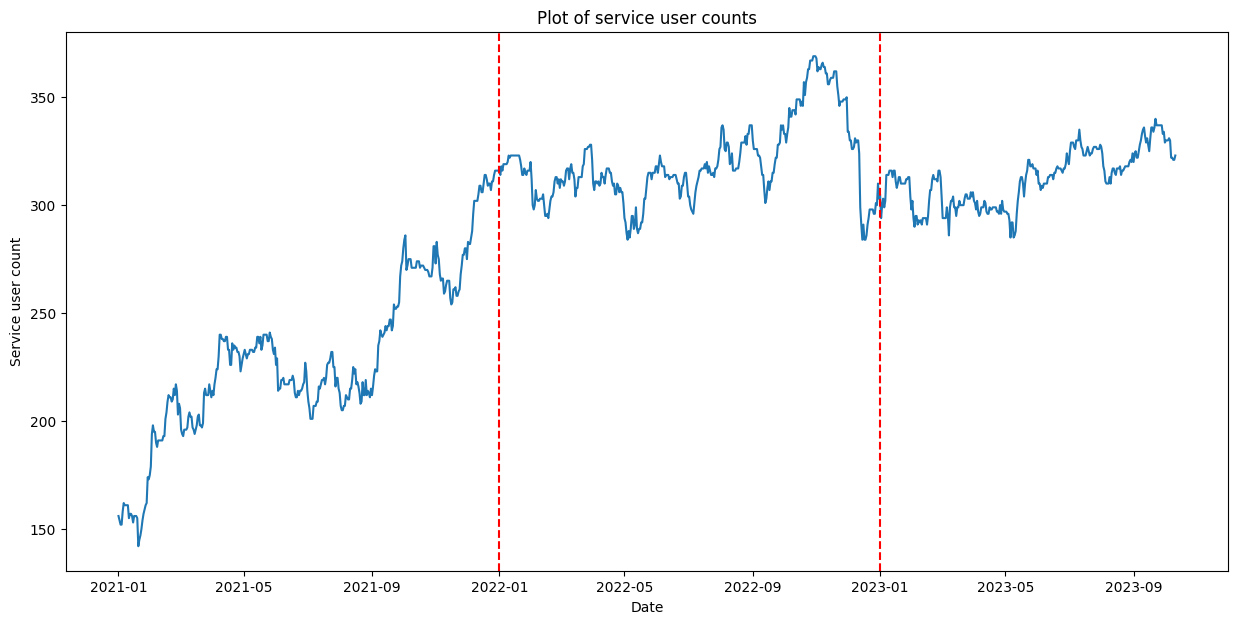

West Humber-Clairville


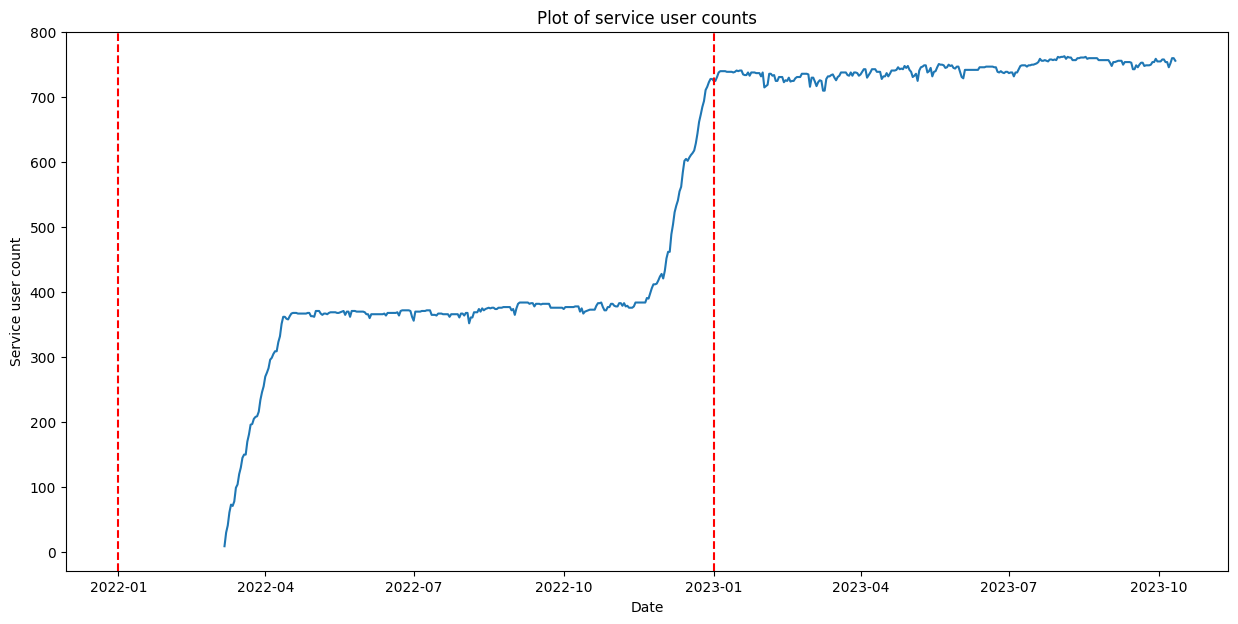

West Queen West


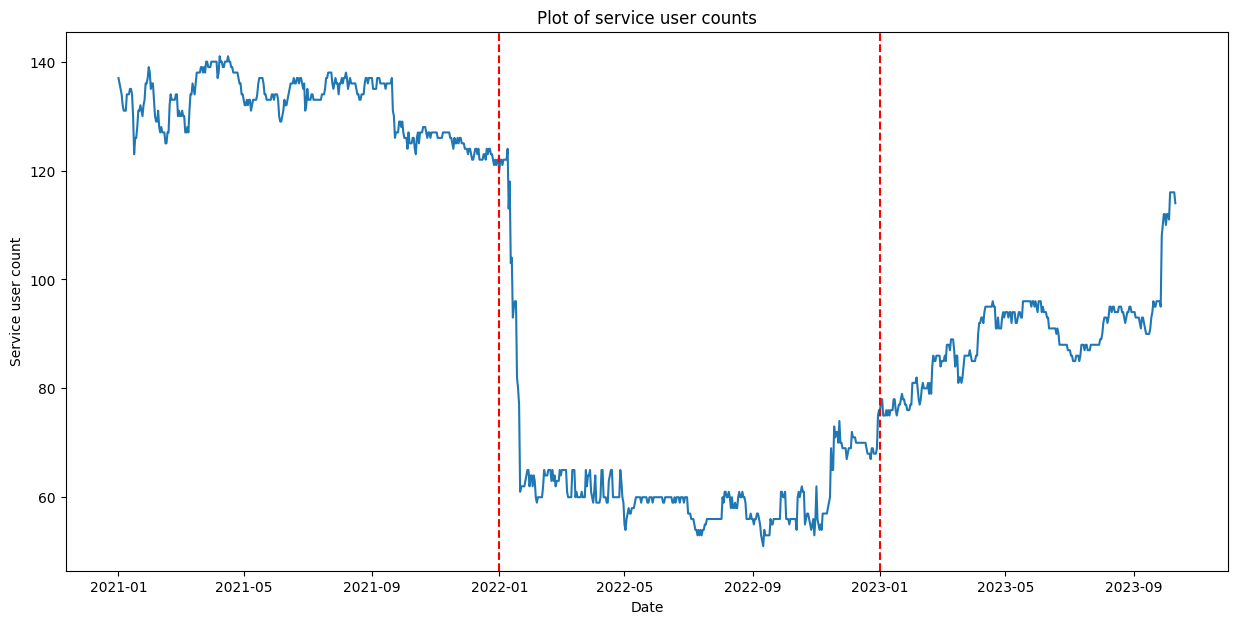

Wexford/Maryvale


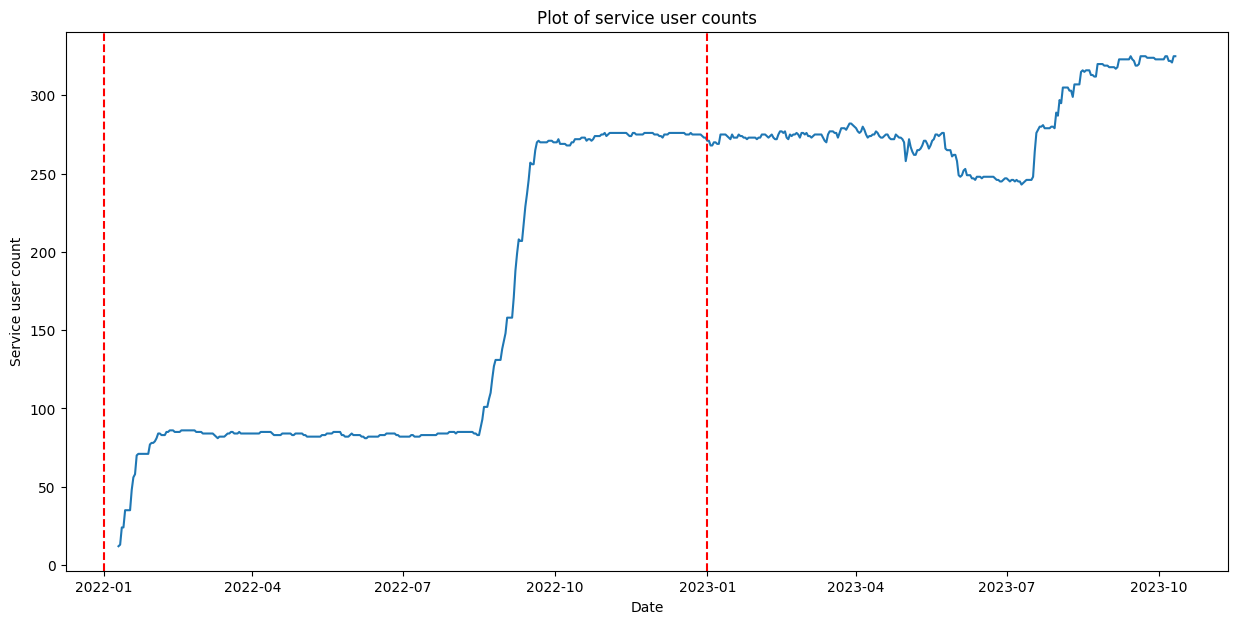

Willowdale West


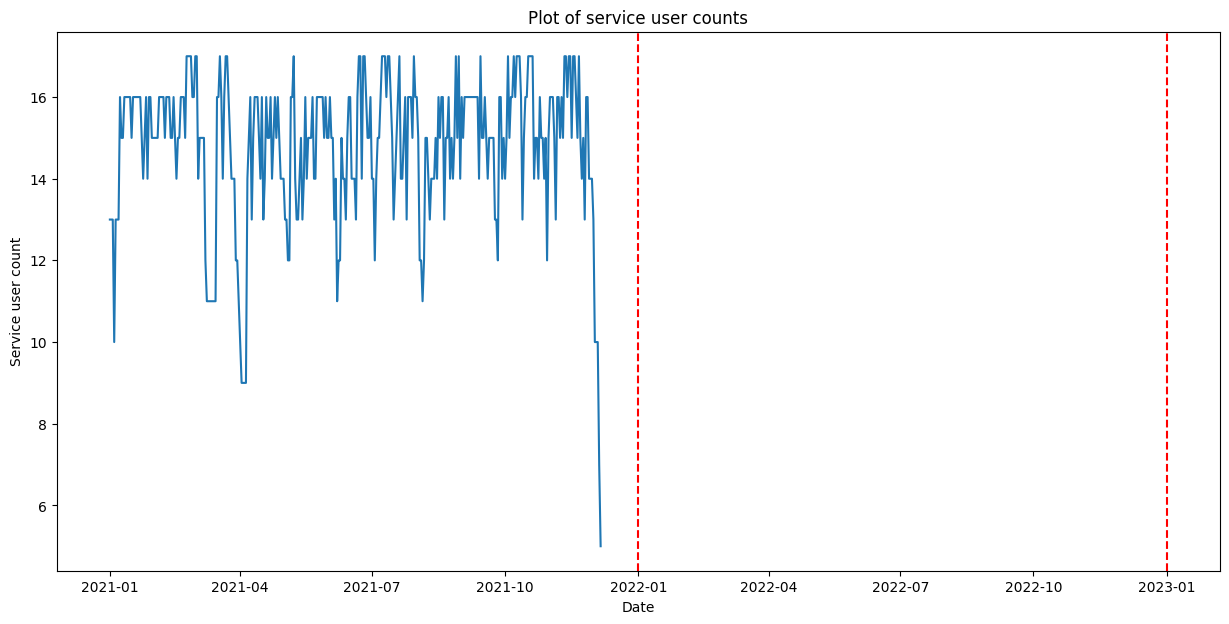

Woburn North


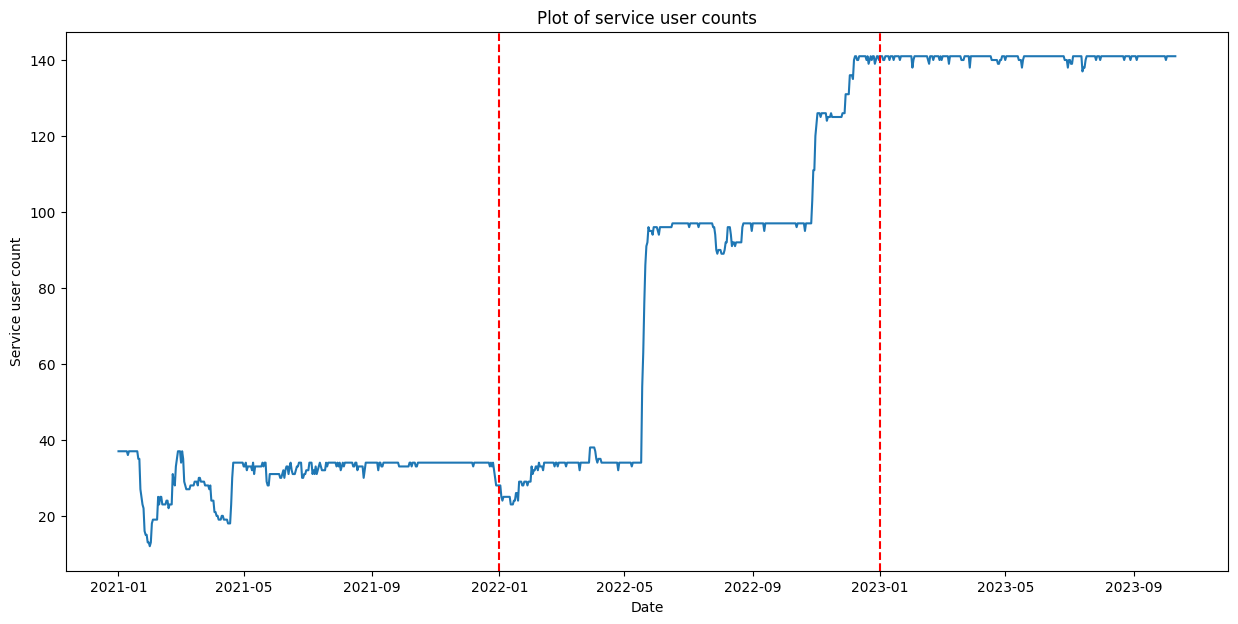

Woodbine Corridor


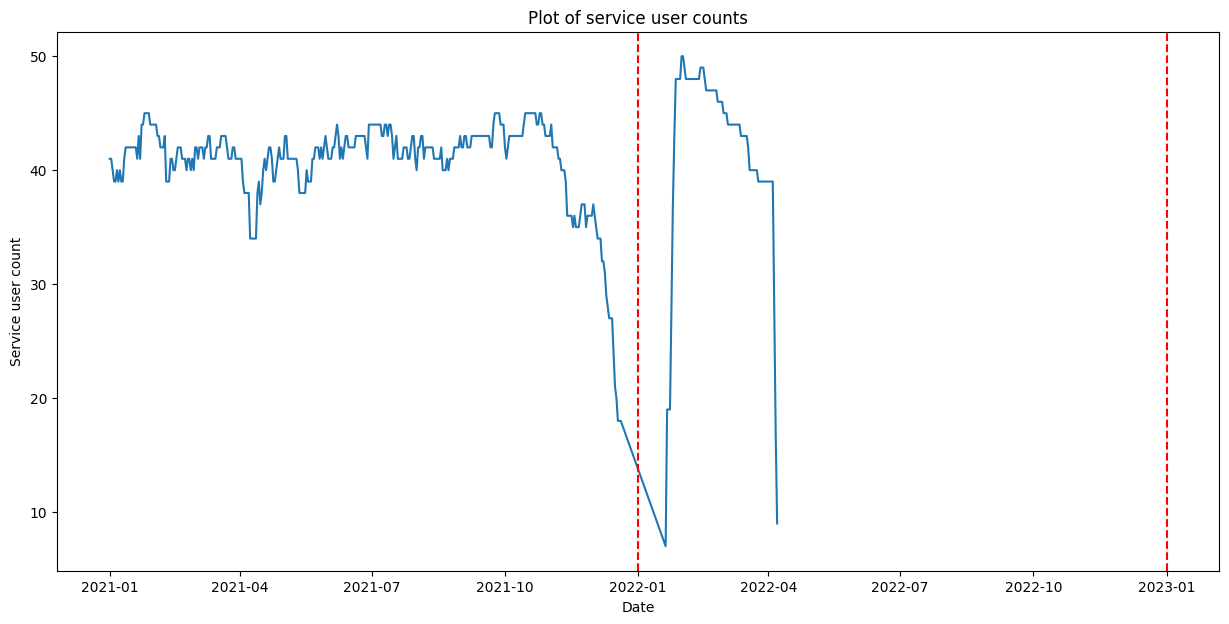

Wychwood


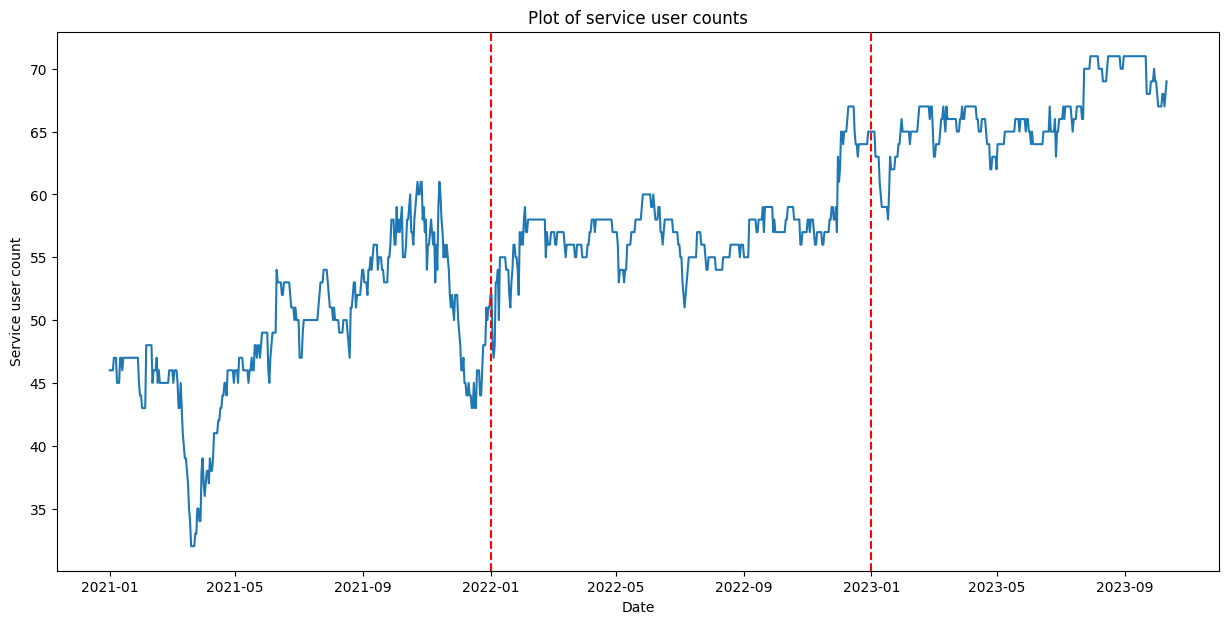

Yonge-Bay Corridor


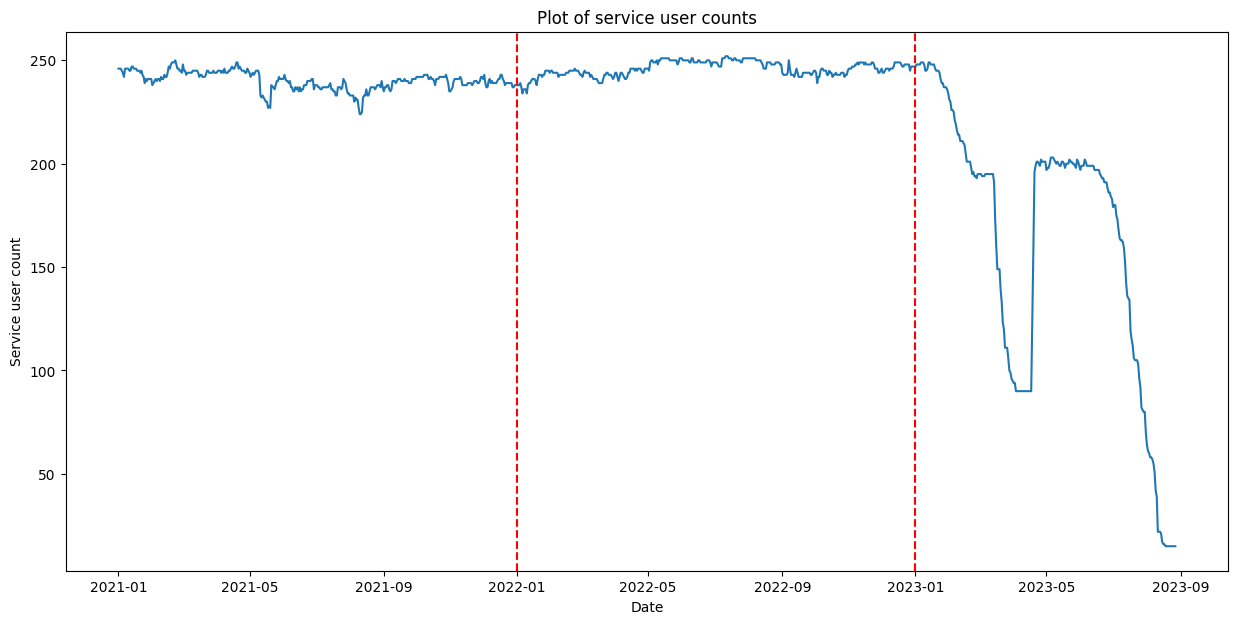

Yonge-Doris


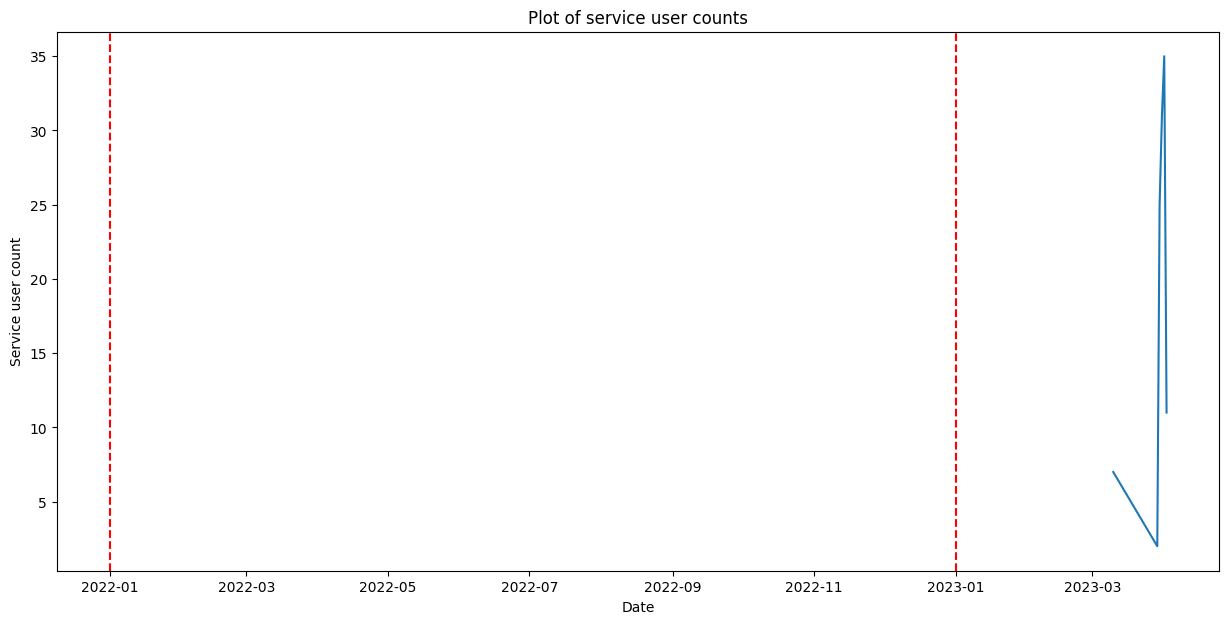

Yorkdale-Glen Park


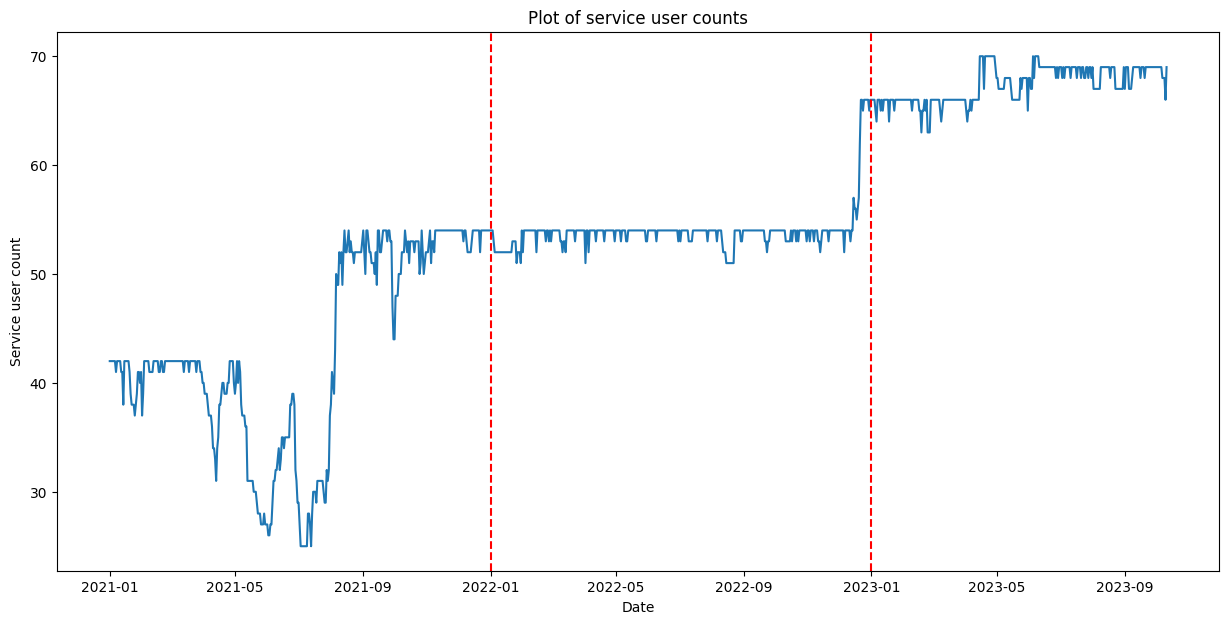

In [24]:
# List of Neighbourhoods
neighbourhoods = np.sort(data["Neighbourhood"].unique())

# plot all the neighbourhoods
for neighbourhood in neighbourhoods:
    print(neighbourhood)
    dataN, testN, trainN = subsetNeighbourhood(data1_exo, test1, train1, neighbourhood)
    plotData(dataN, testN, trainN)

In [27]:
len(testN["SERVICE_USER_COUNT"])

284

Annex


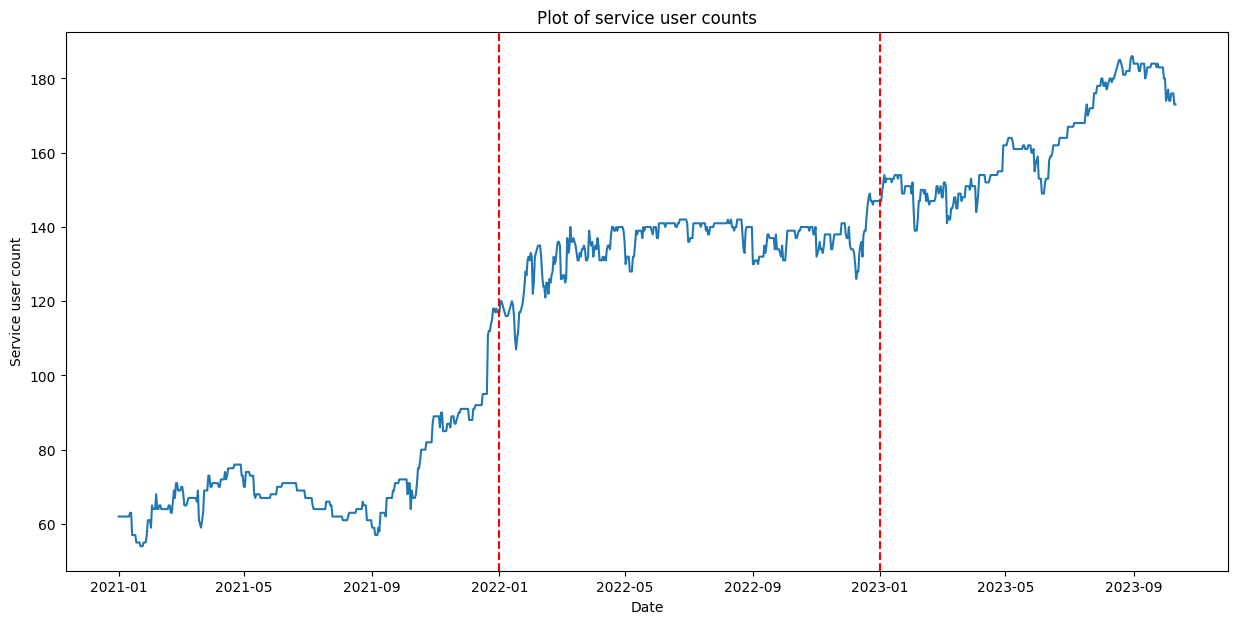

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[0] intercept


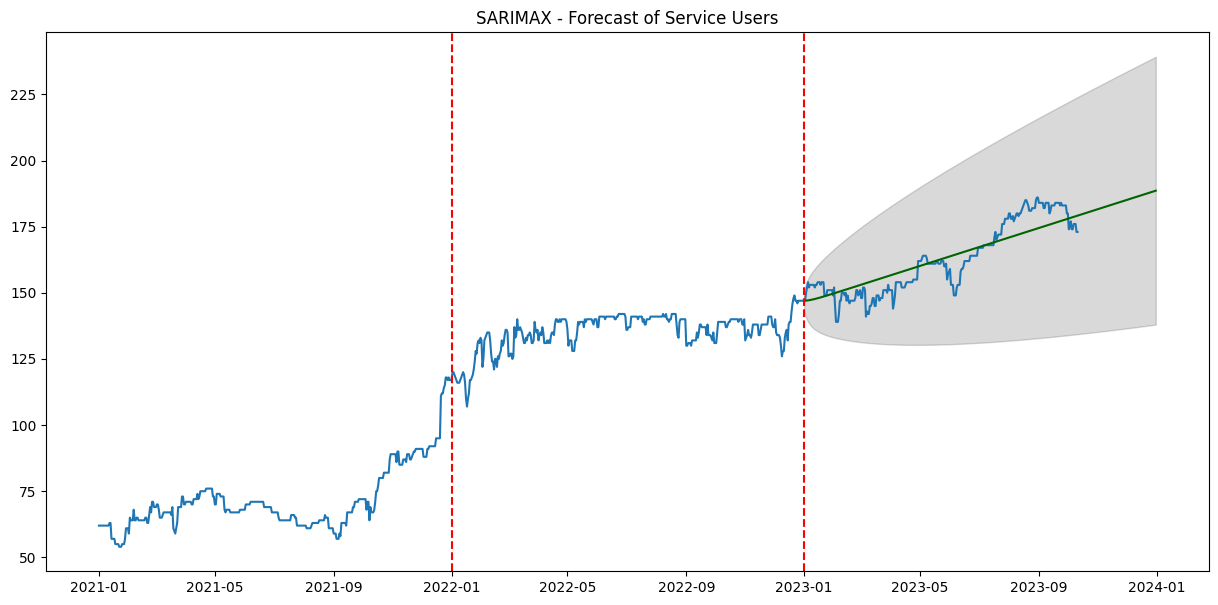

MSE:  37.833295235370834
RMSE:  6.150877598796032
MAE:  5.126089498214166
Bendale-Glen Andrew


C:\Users\miche\AppData\Local\Temp\ipykernel_29620\2546742915.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Eval_values = pd.concat([Eval_values, valueEval])


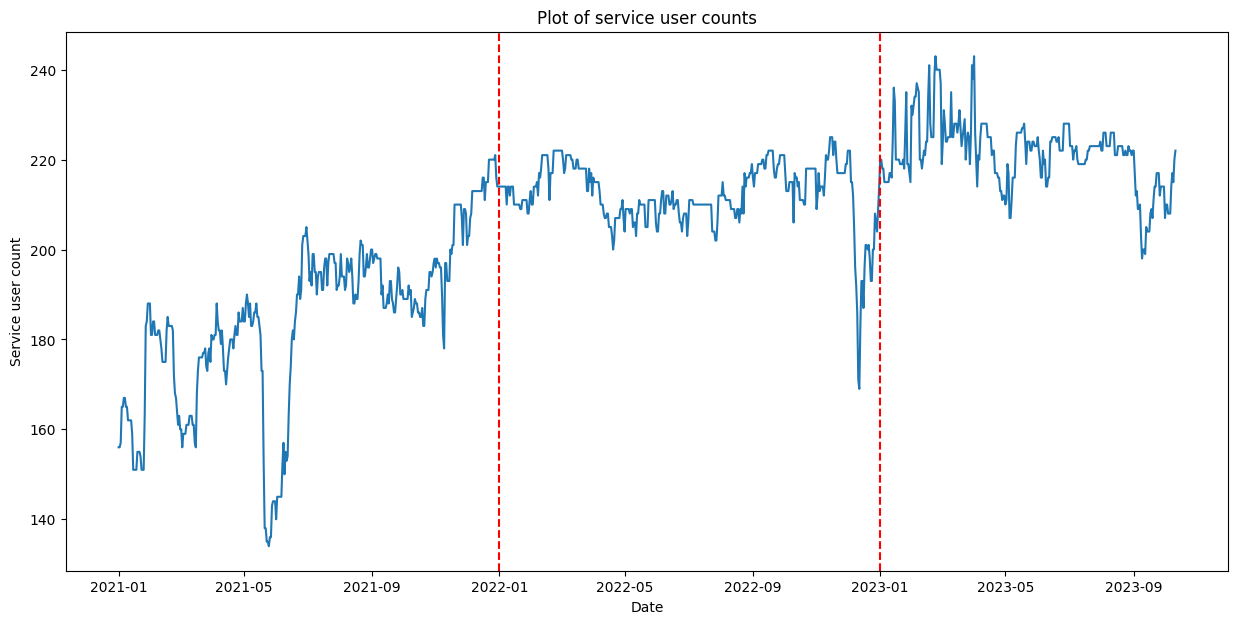

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[0] intercept


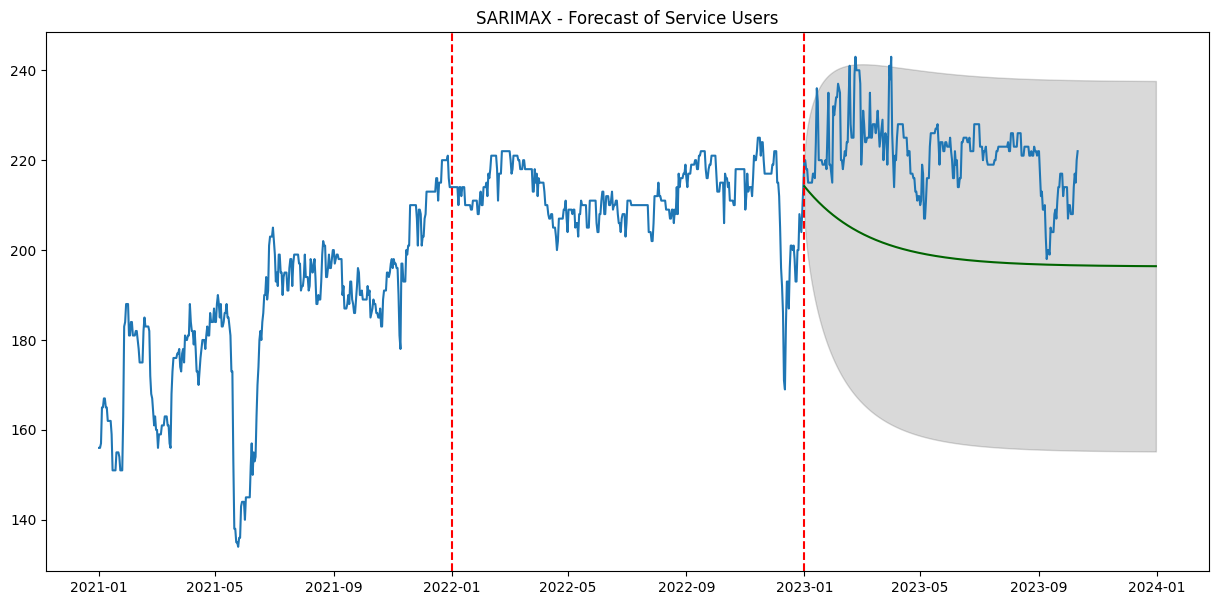

MSE:  499.6654952706403
RMSE:  22.35319877043642
MAE:  20.942907312317992
Broadview North


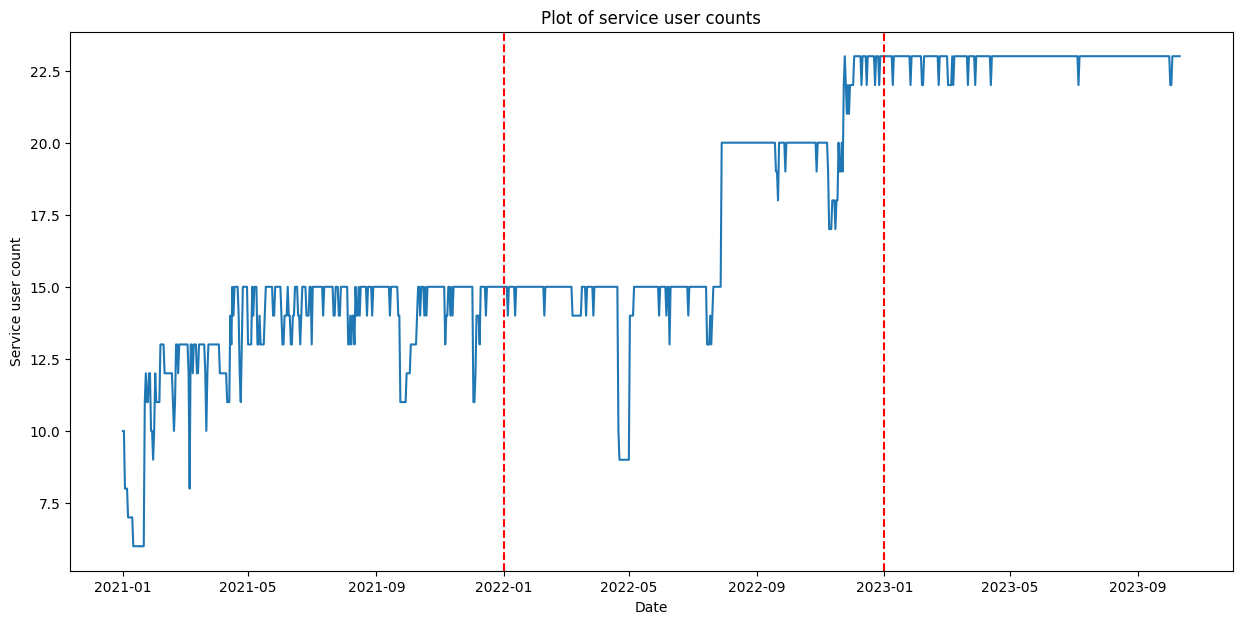

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,0)[0] intercept


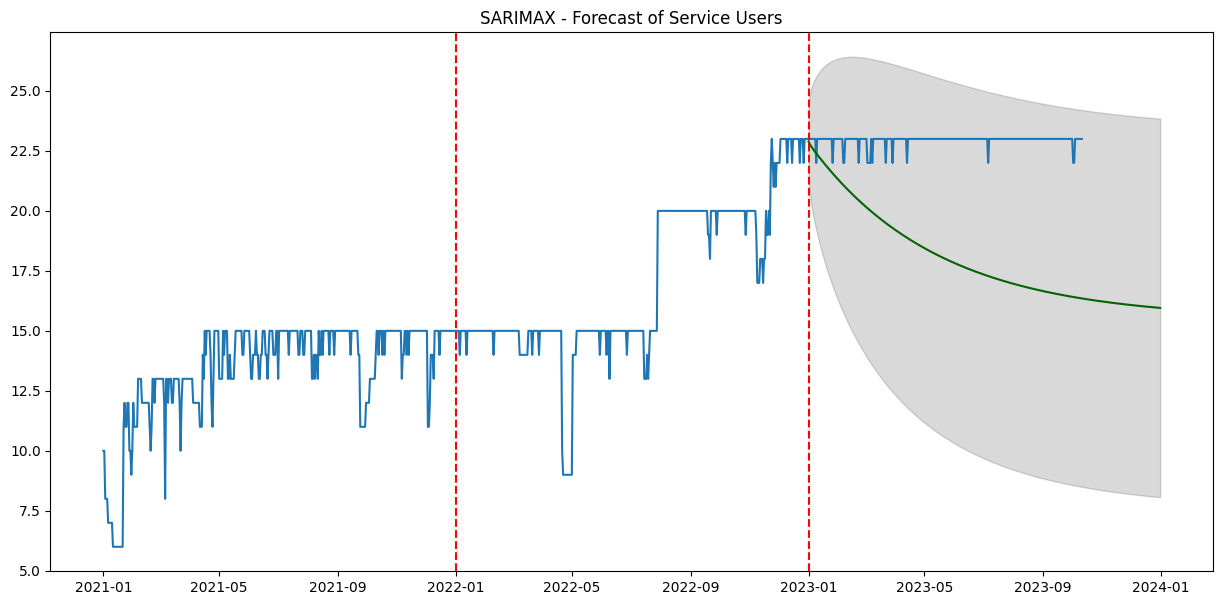

MSE:  23.07039410644512
RMSE:  4.803165009287639
MAE:  4.4298495671563085
Caledonia-Fairbank


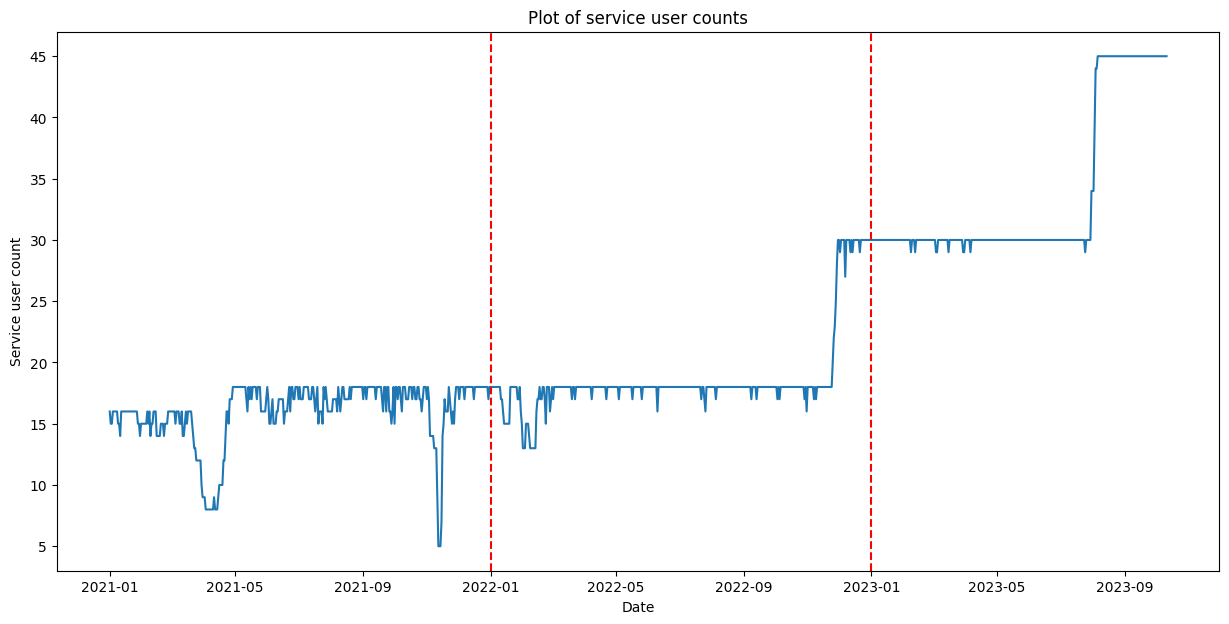

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(0,0,0)[0]          


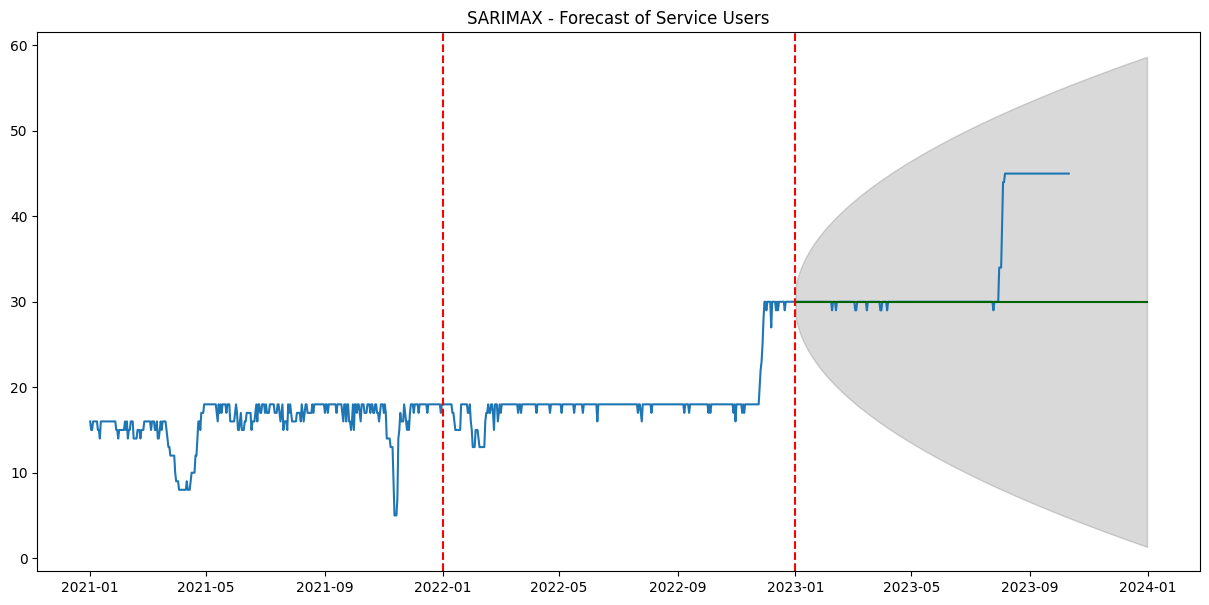

MSE:  54.94718309859155
RMSE:  7.412636717025295
MAE:  3.742957746478873
Church-Wellesley


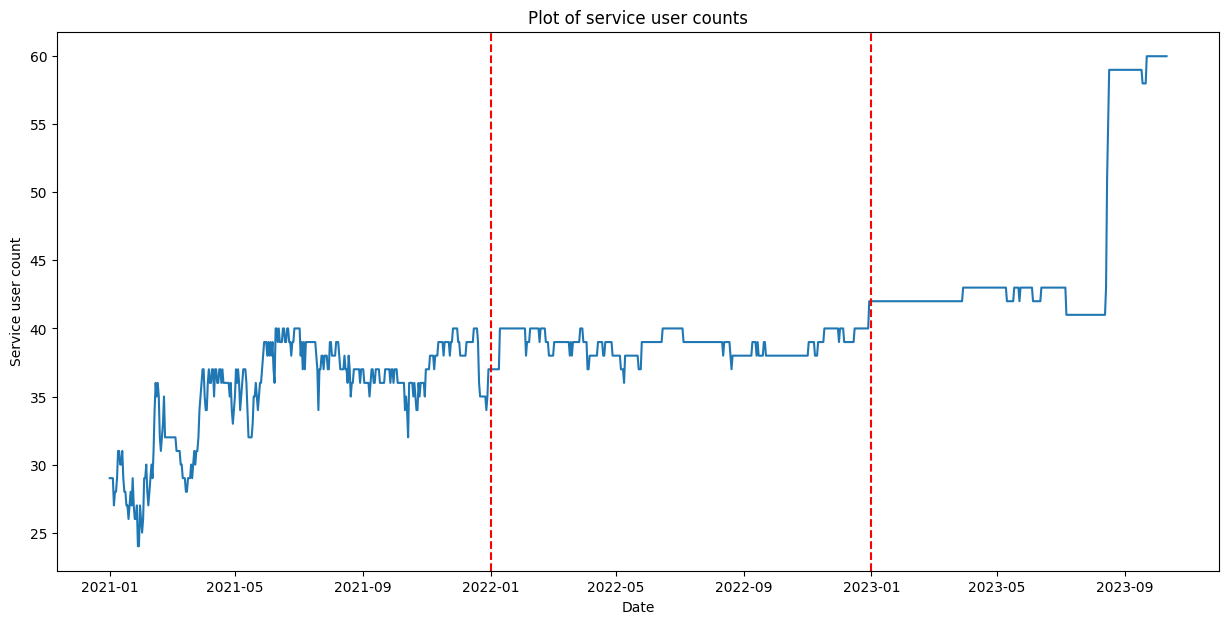

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,3)(0,0,0)[0] intercept


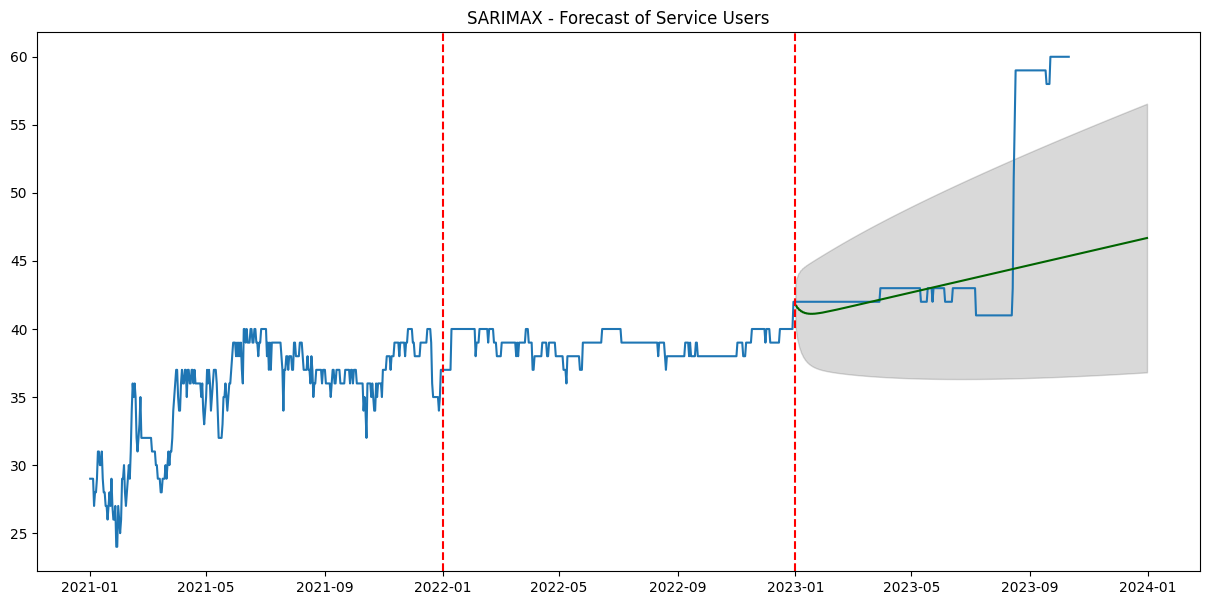

MSE:  42.89438955520837
RMSE:  6.549380852814132
MAE:  3.6571624407495635
Dovercourt Village


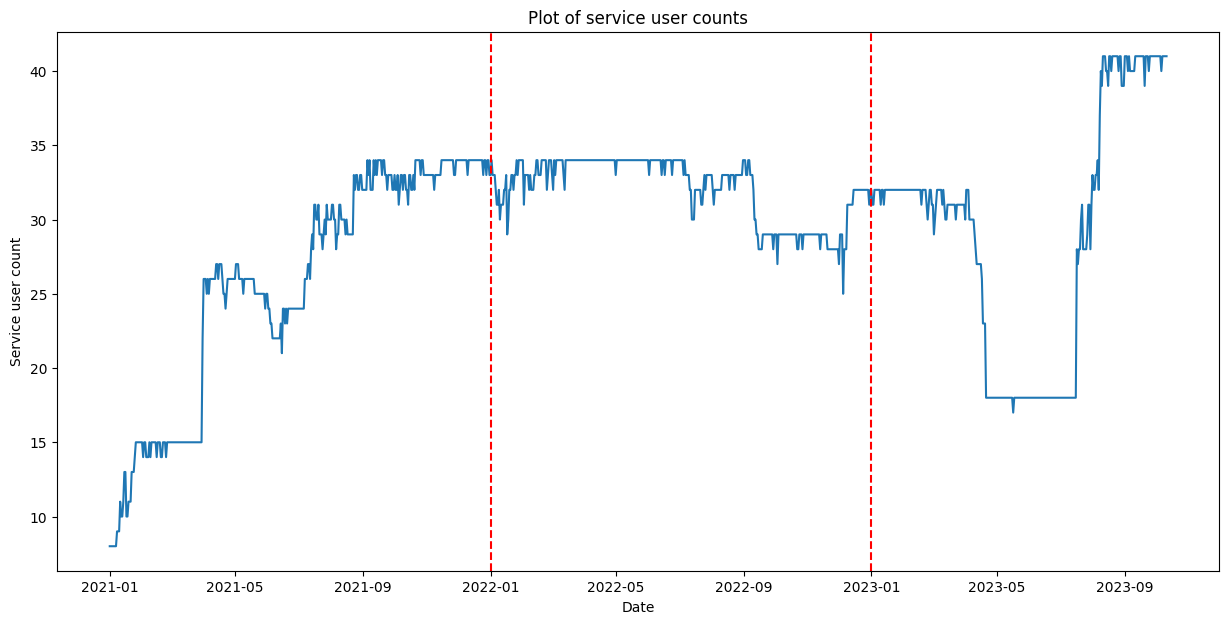

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,1)(0,0,0)[0] intercept


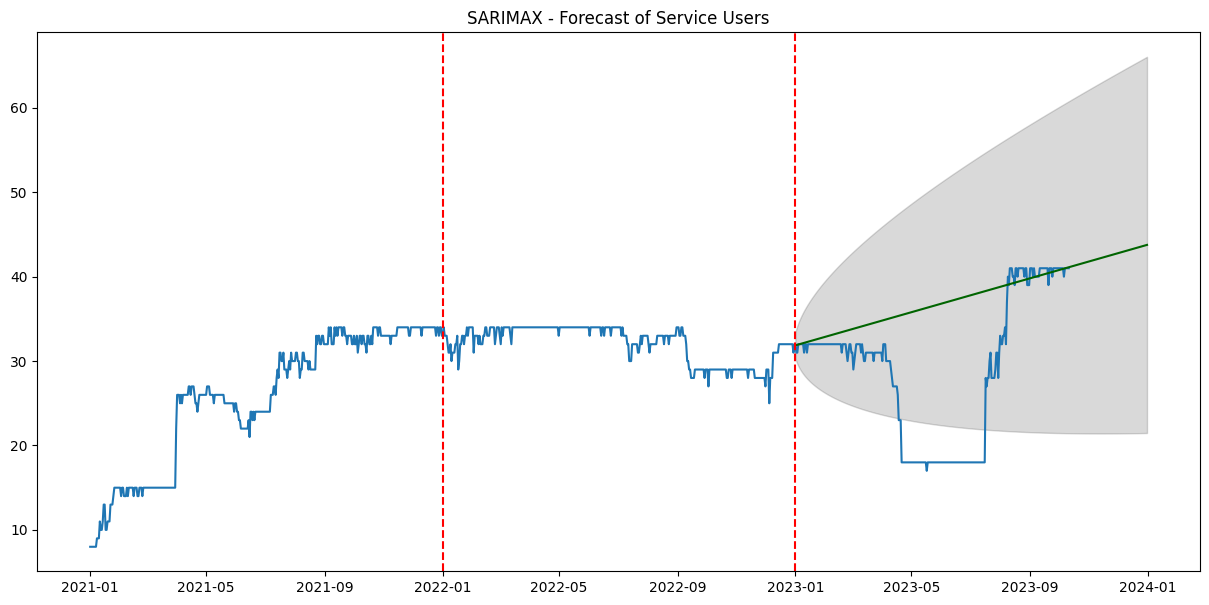

MSE:  121.07257434051762
RMSE:  11.003298339158018
MAE:  7.6635211657210025
Downtown Yonge East


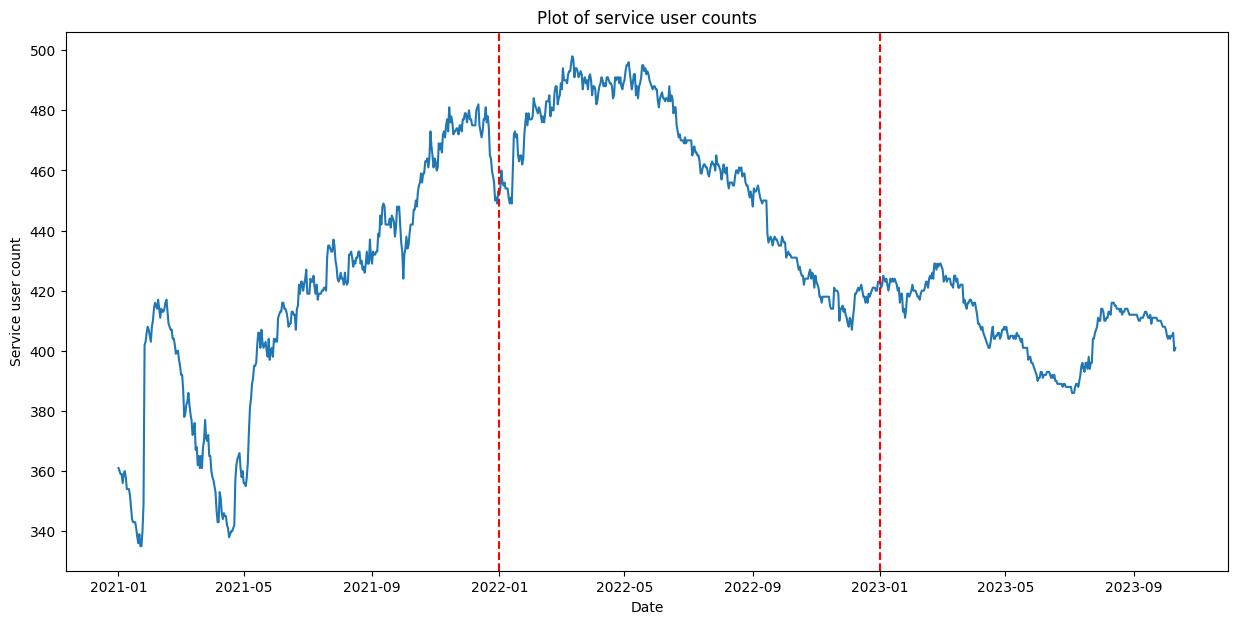

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[0]          


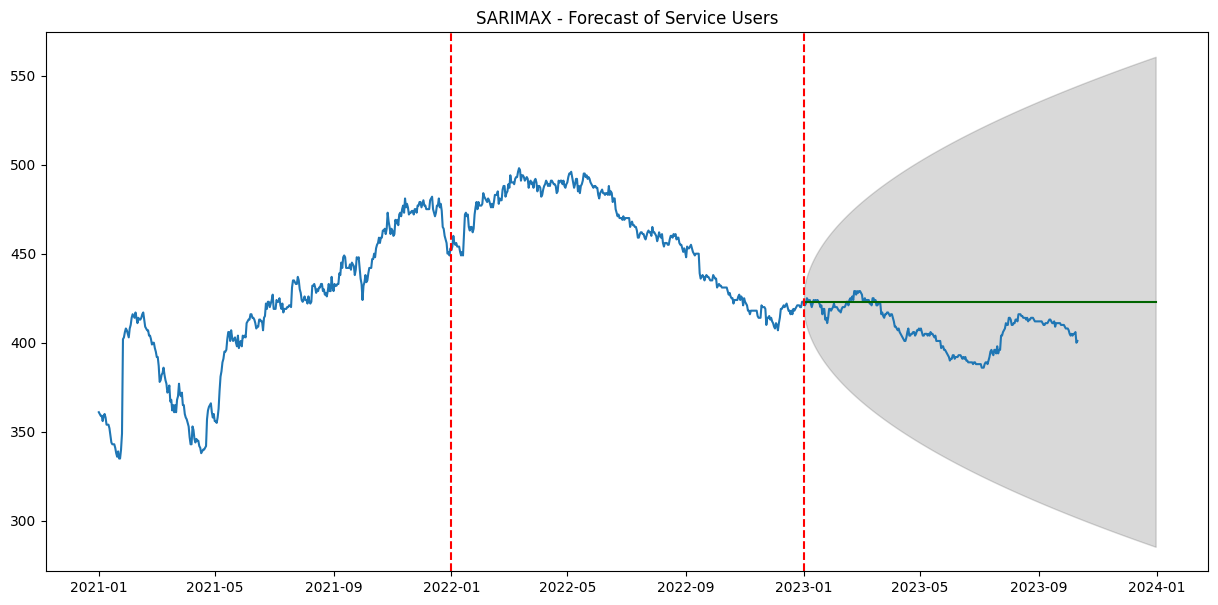

MSE:  327.36619718309856
RMSE:  18.093263862086868
MAE:  14.577464788732394
East End-Danforth


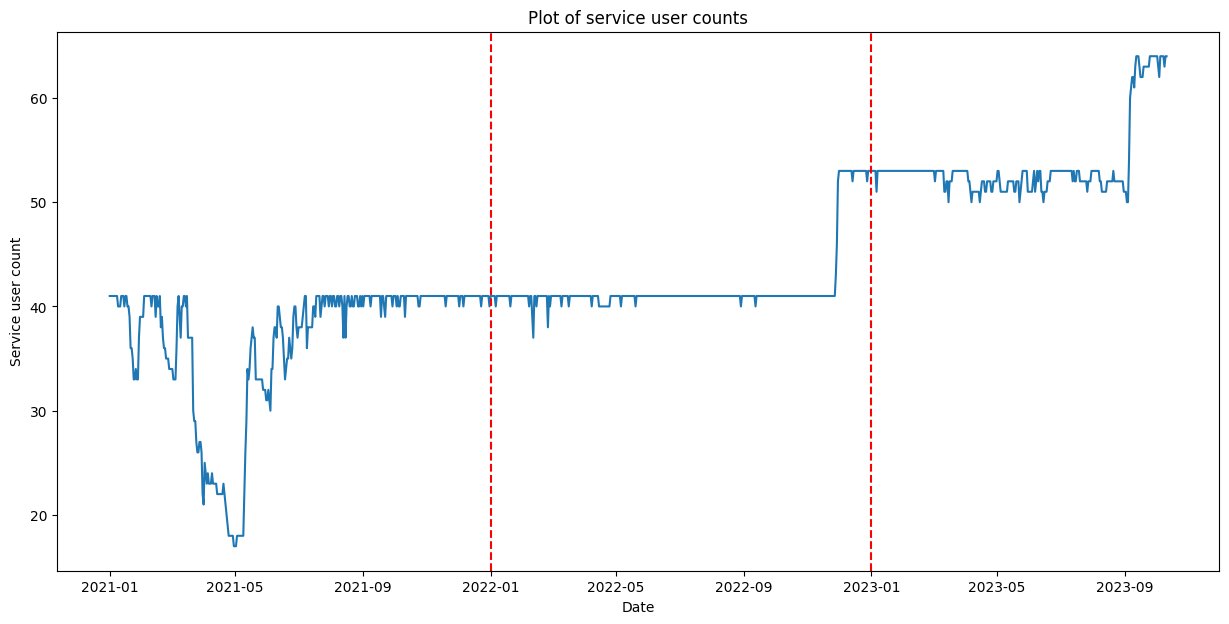

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[0]          


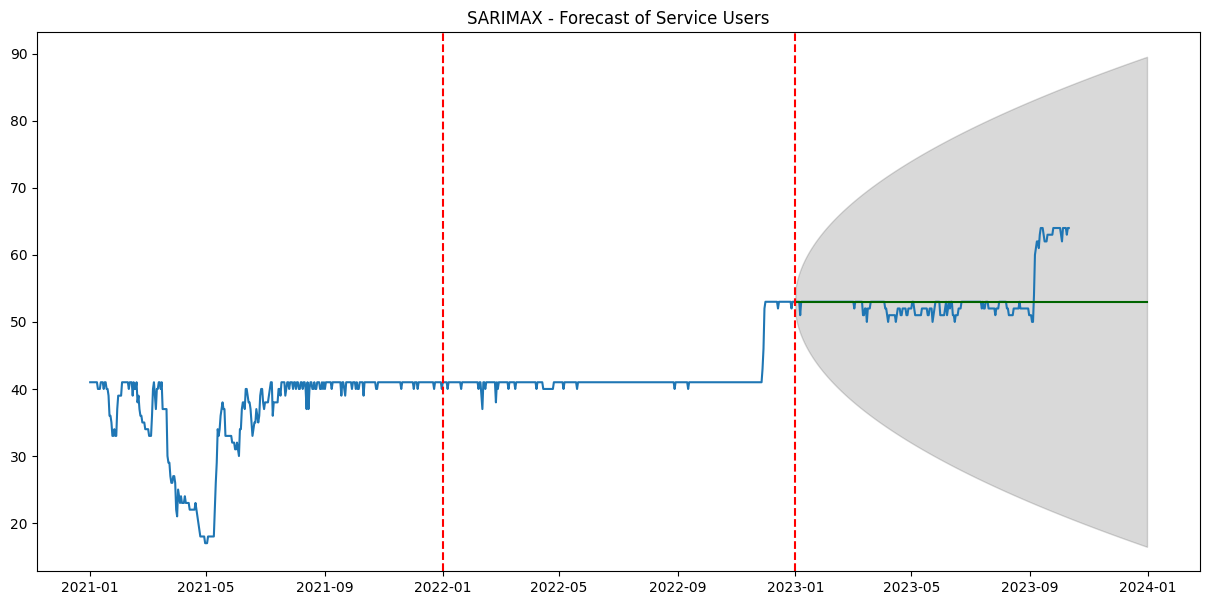

MSE:  14.204225352112676
RMSE:  3.768849340596235
MAE:  1.9154929577464788
Fort York-Liberty Village


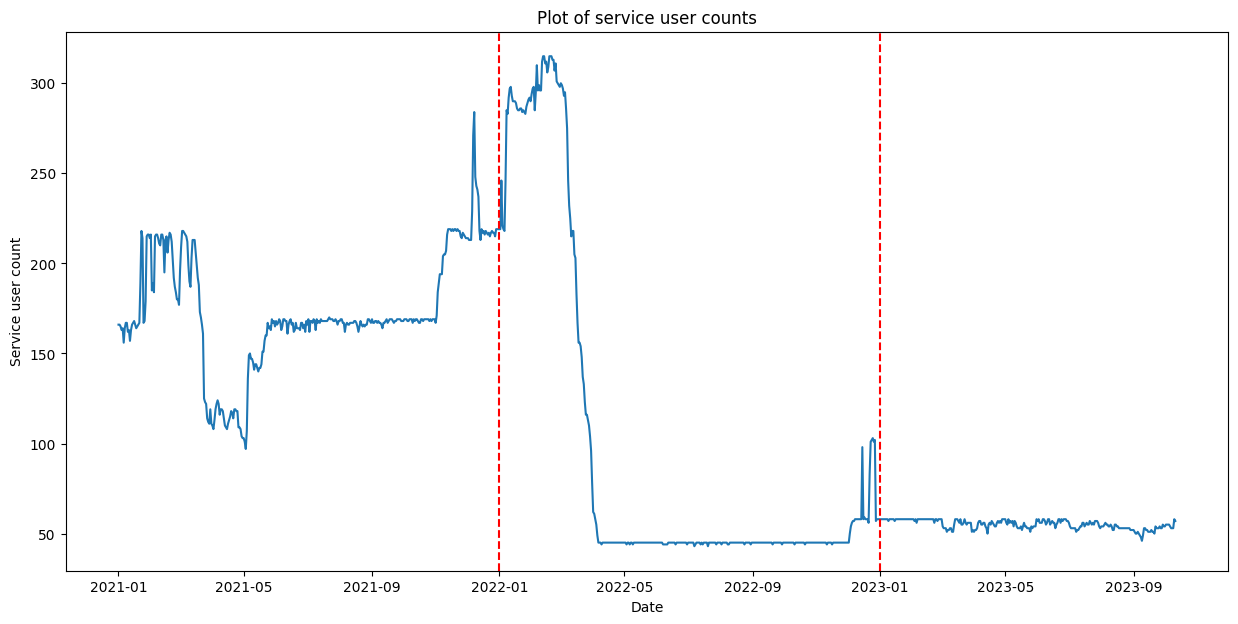

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,1)(0,0,0)[0]          


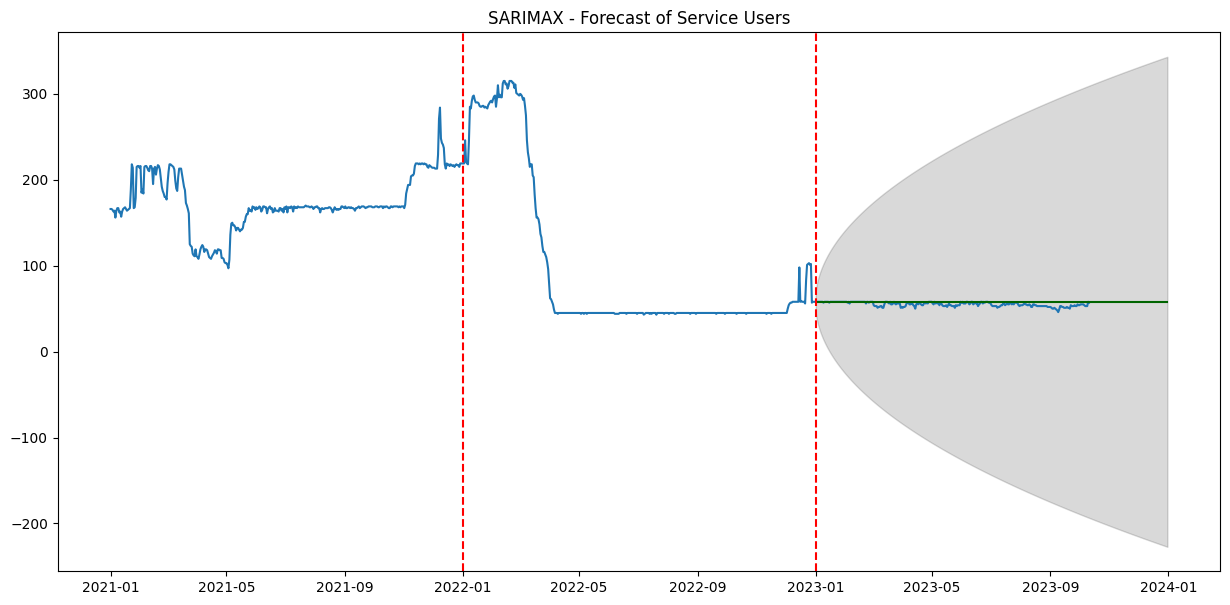

MSE:  14.376261597210132
RMSE:  3.7916040928886723
MAE:  2.878093618132398
Harbourfront-CityPlace


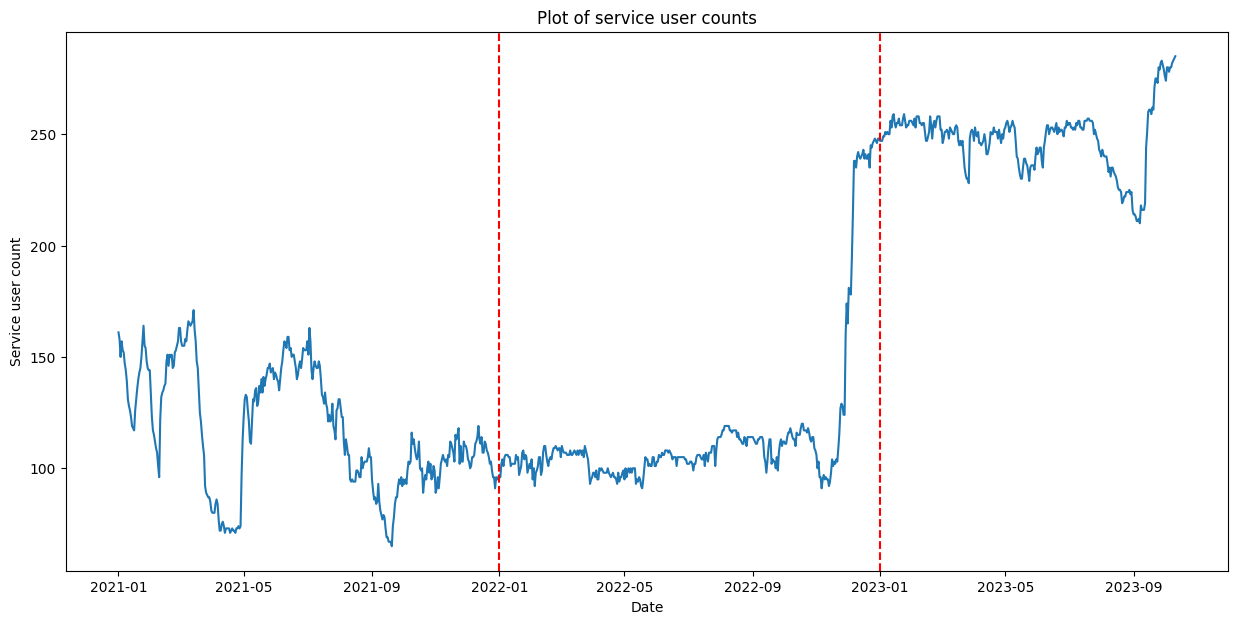

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[0]          


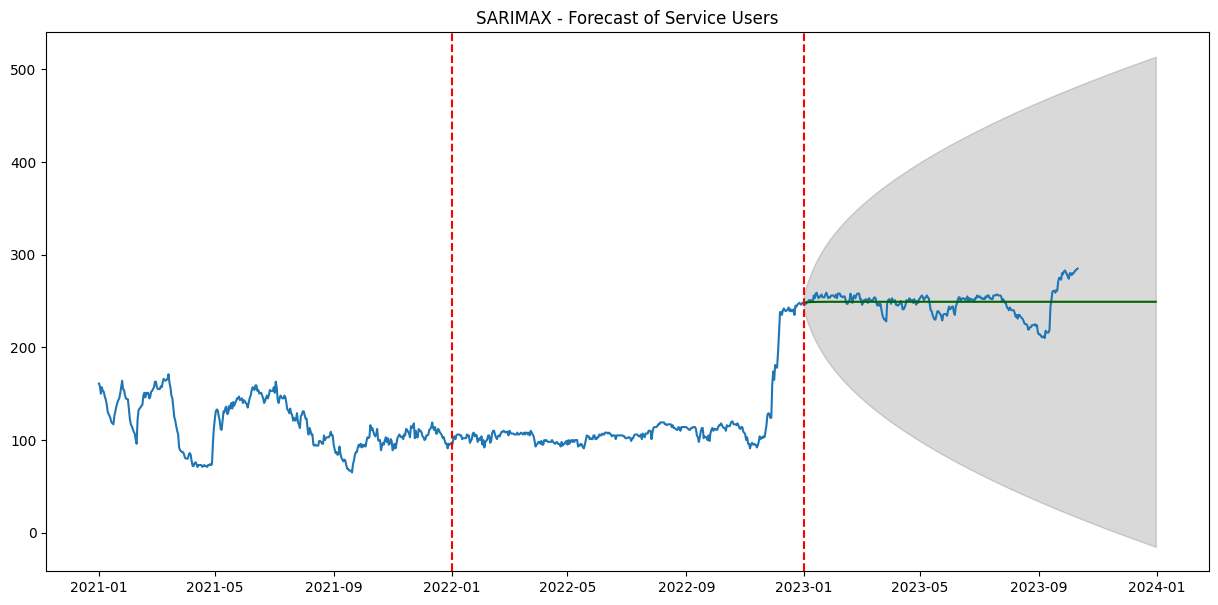

MSE:  205.00024185617707
RMSE:  14.317829509257926
MAE:  10.076959126094856
High Park-Swansea


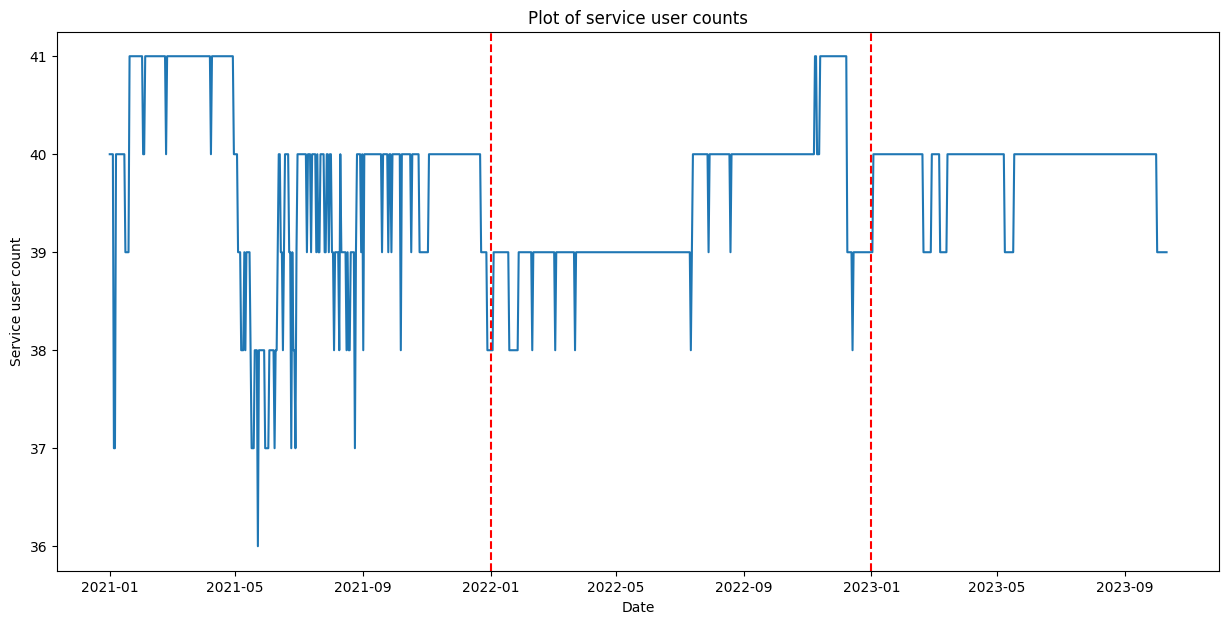

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[0]          


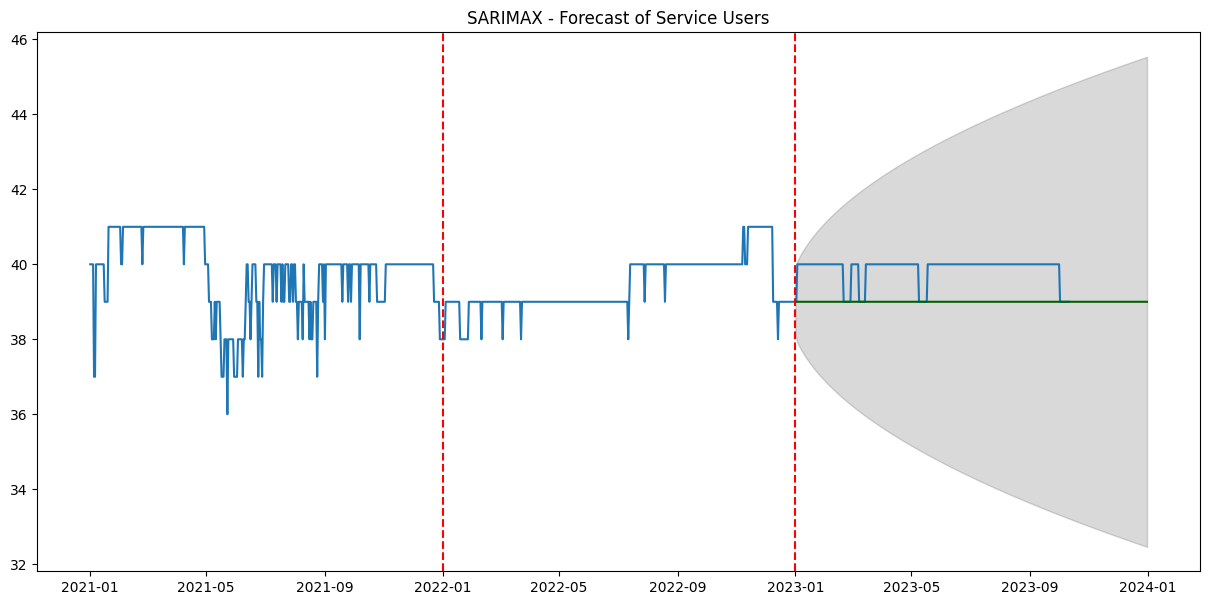

MSE:  0.8724123848352539
RMSE:  0.9340301841135831
MAE:  0.8728850455355841
Hillcrest Village


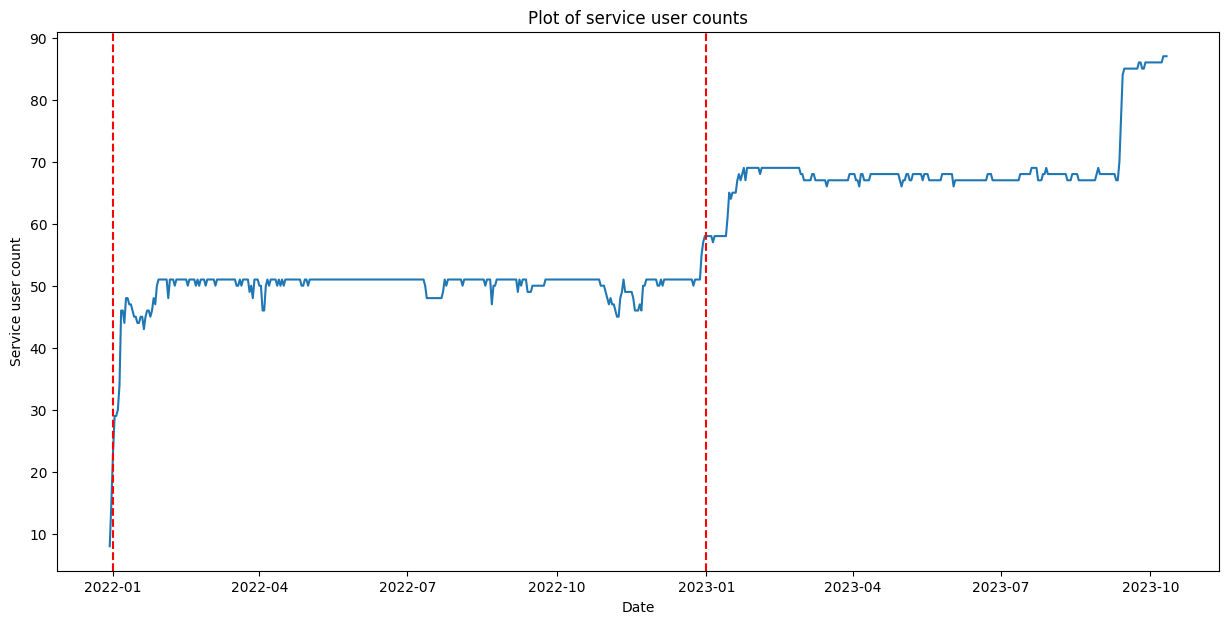

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,2)(0,0,0)[0]          


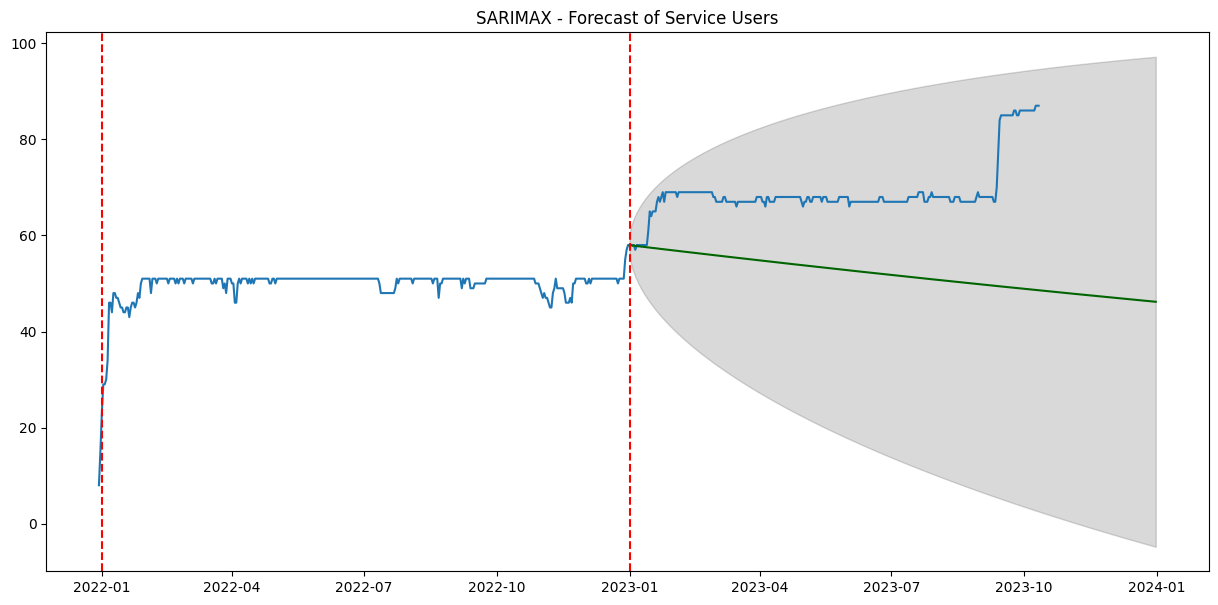

MSE:  312.86241225849074
RMSE:  17.687917126063507
MAE:  15.84509742134731
Junction Area


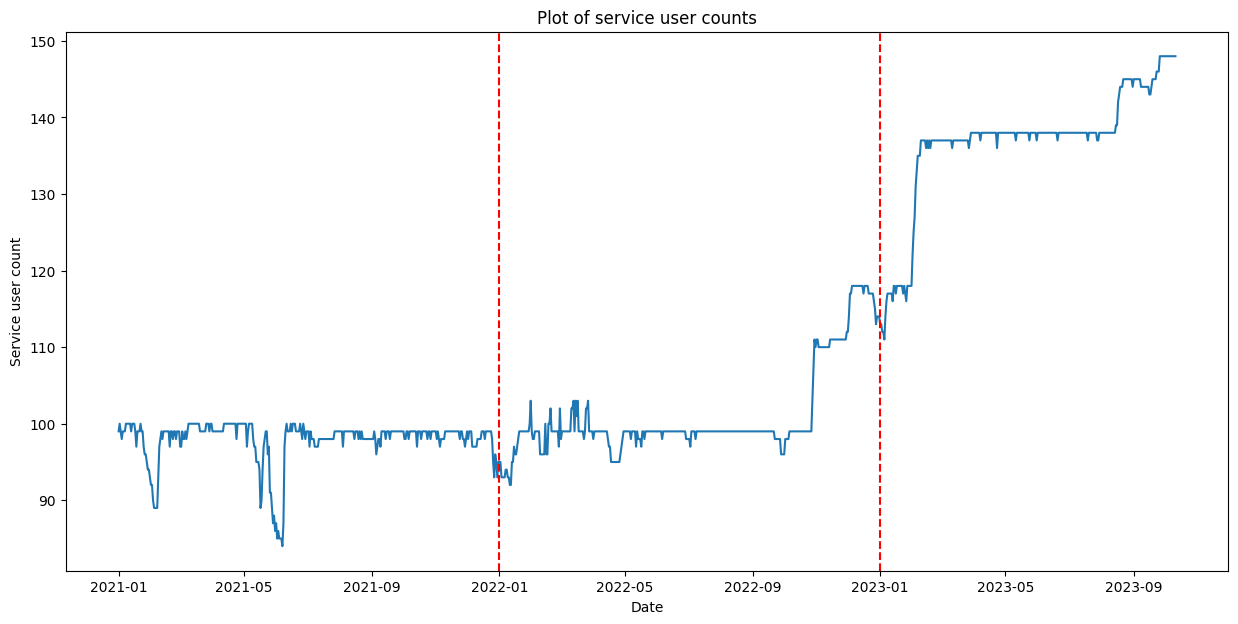

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,3)(0,0,0)[0]          


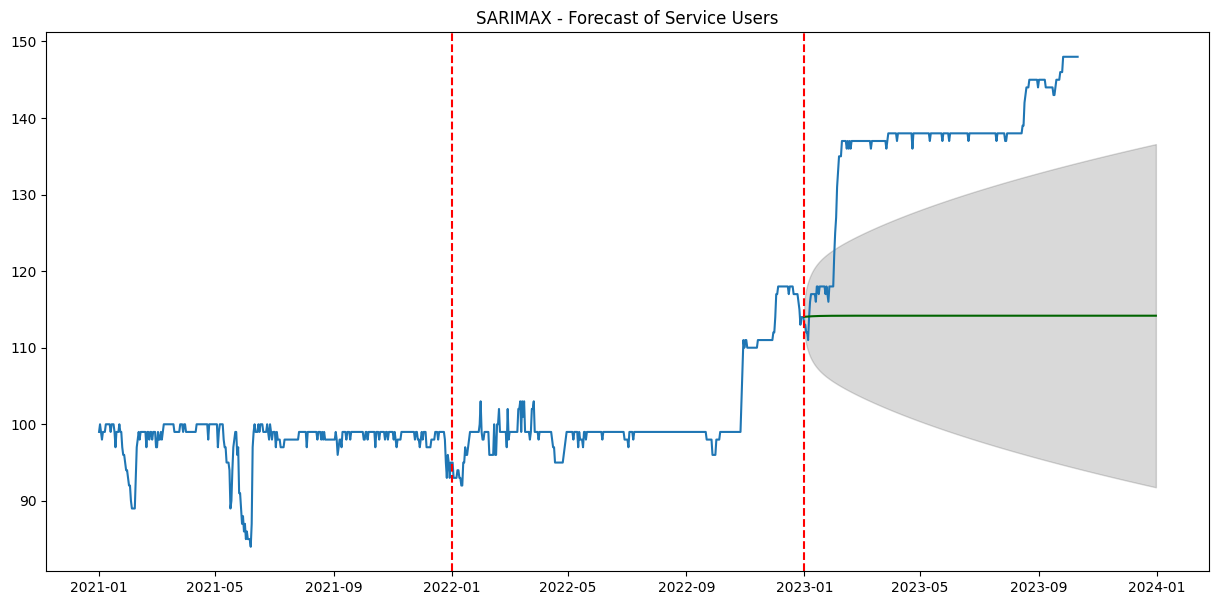

MSE:  570.9125802232433
RMSE:  23.89377701878134
MAE:  22.594843223179378
Junction-Wallace Emerson


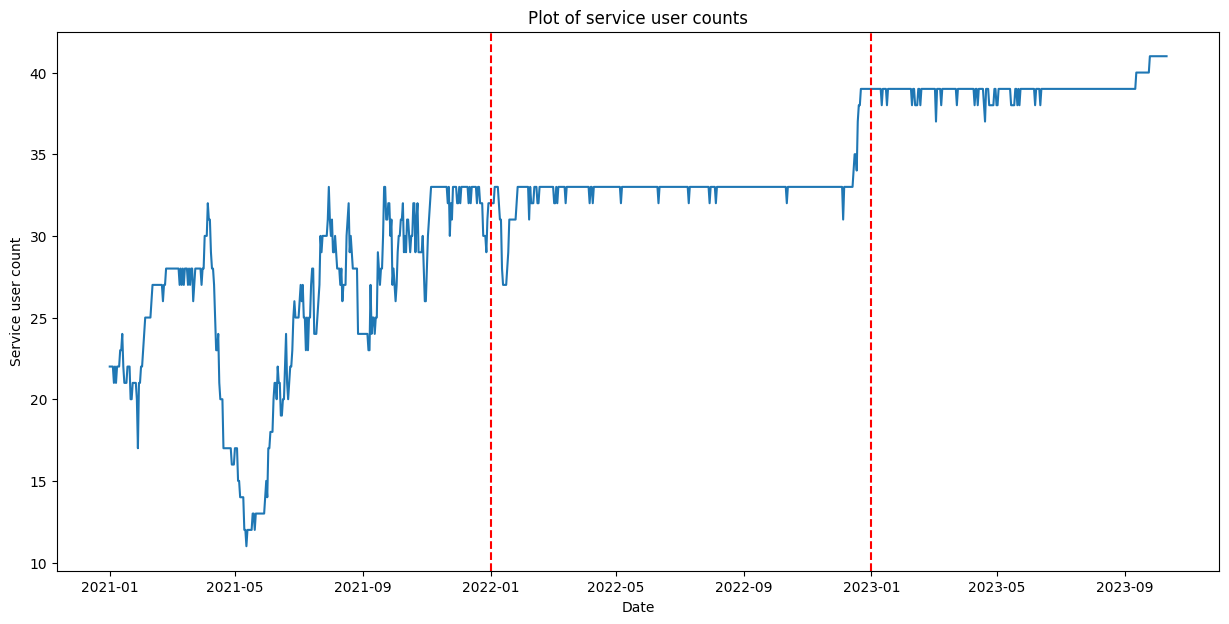

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(0,0,0)[0]          


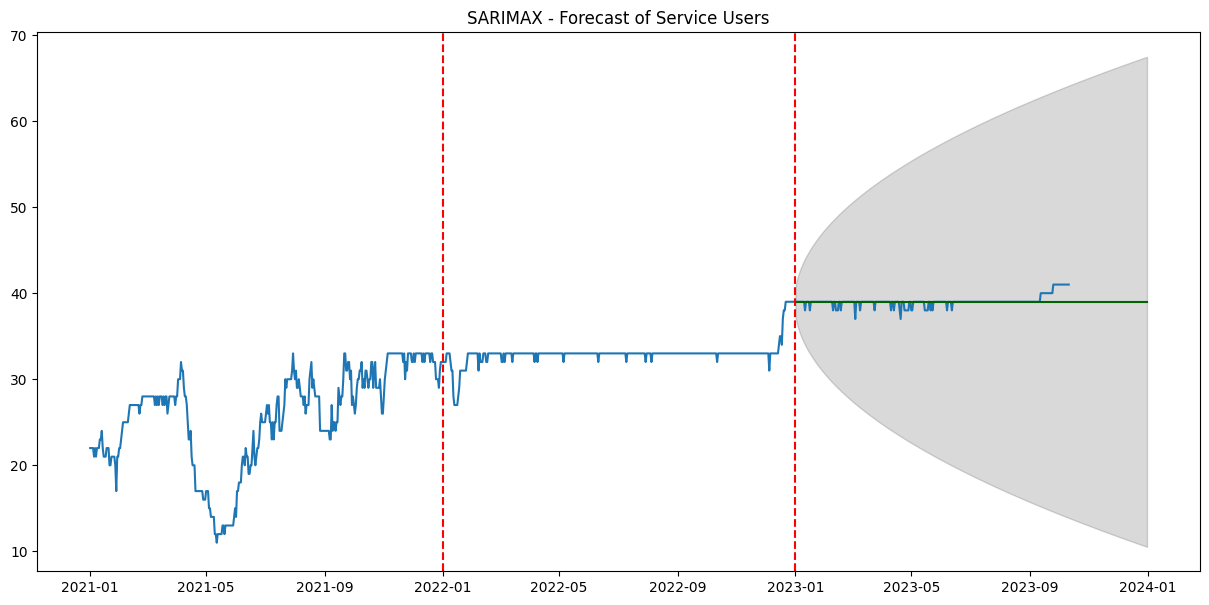

MSE:  0.4084507042253521
RMSE:  0.6391014819458269
MAE:  0.2746478873239437
Kennedy Park


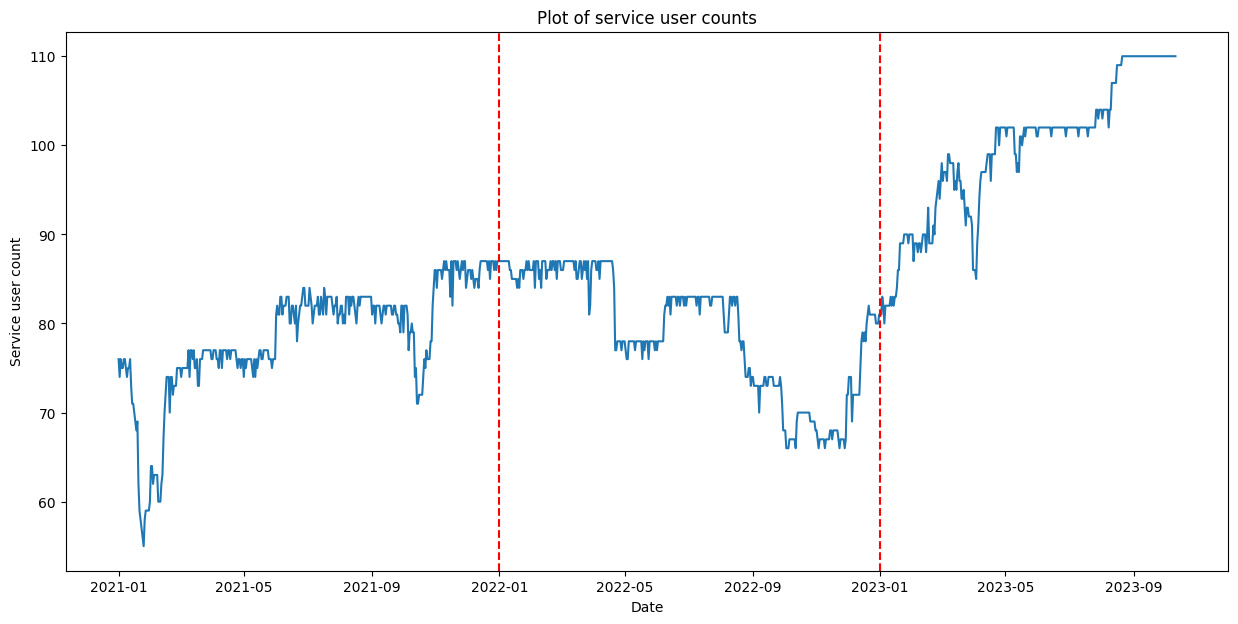

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(0,0,0)[0]          


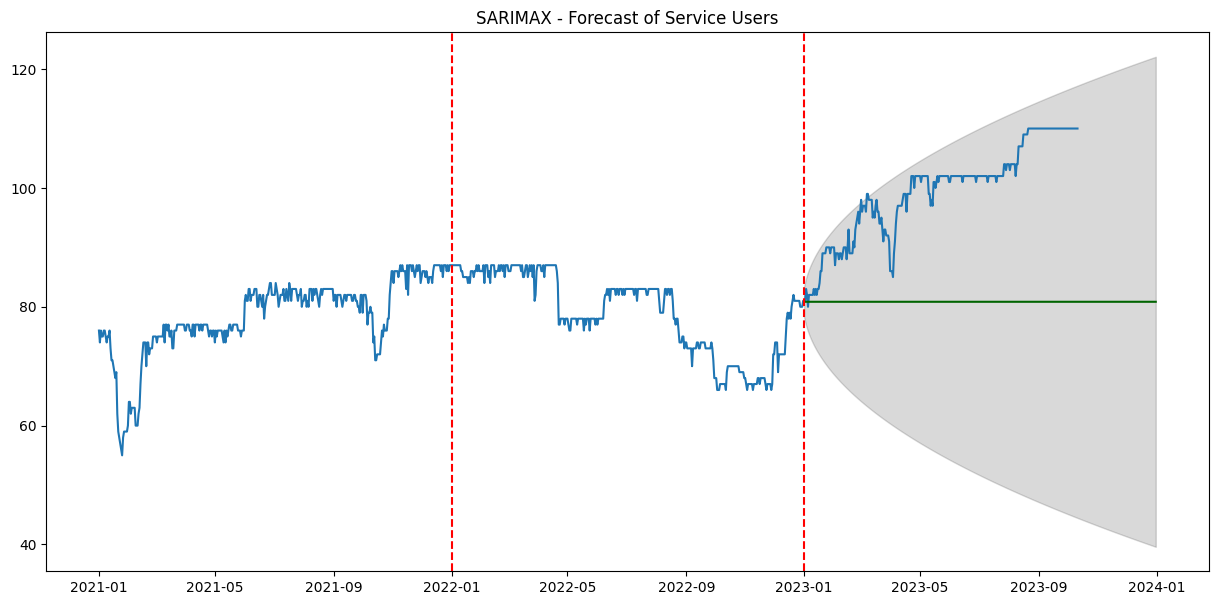

MSE:  409.2508316066257
RMSE:  20.229948878003267
MAE:  18.596068439095074
Kensington-Chinatown


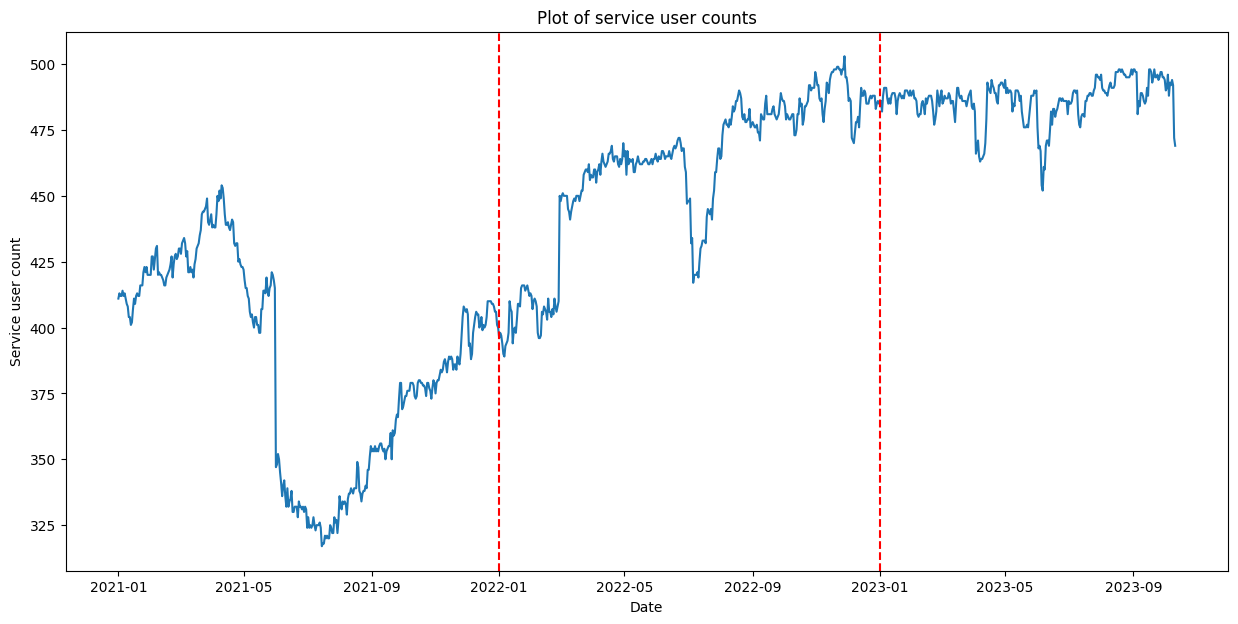

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[0]          


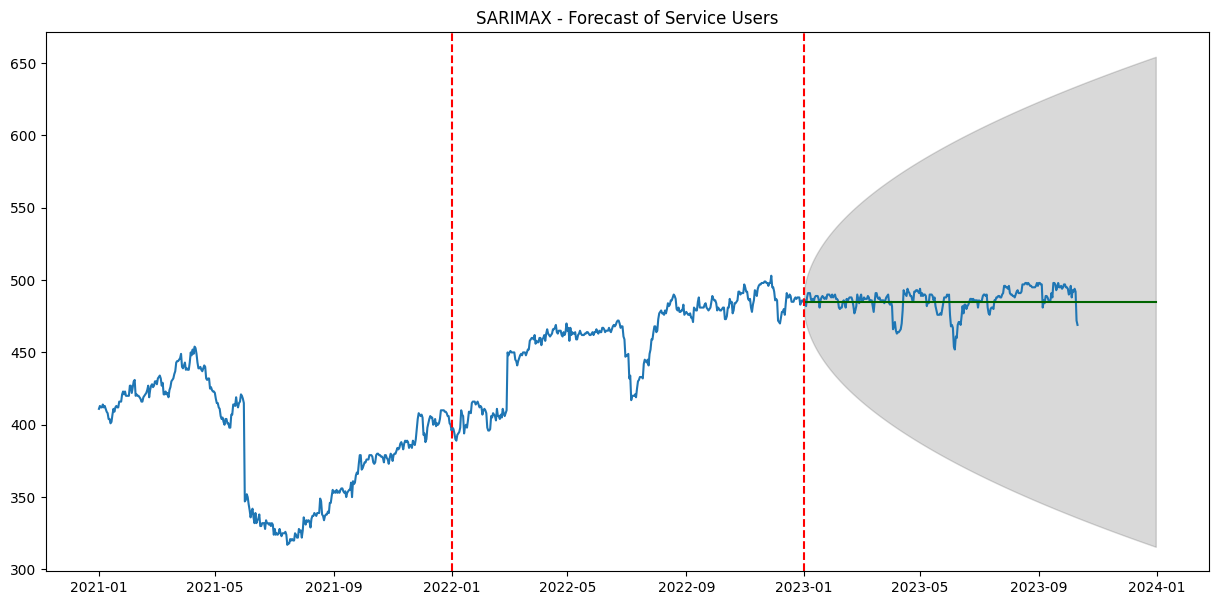

MSE:  66.39084507042253
RMSE:  8.148057748348531
MAE:  6.130281690140845
Little Portugal


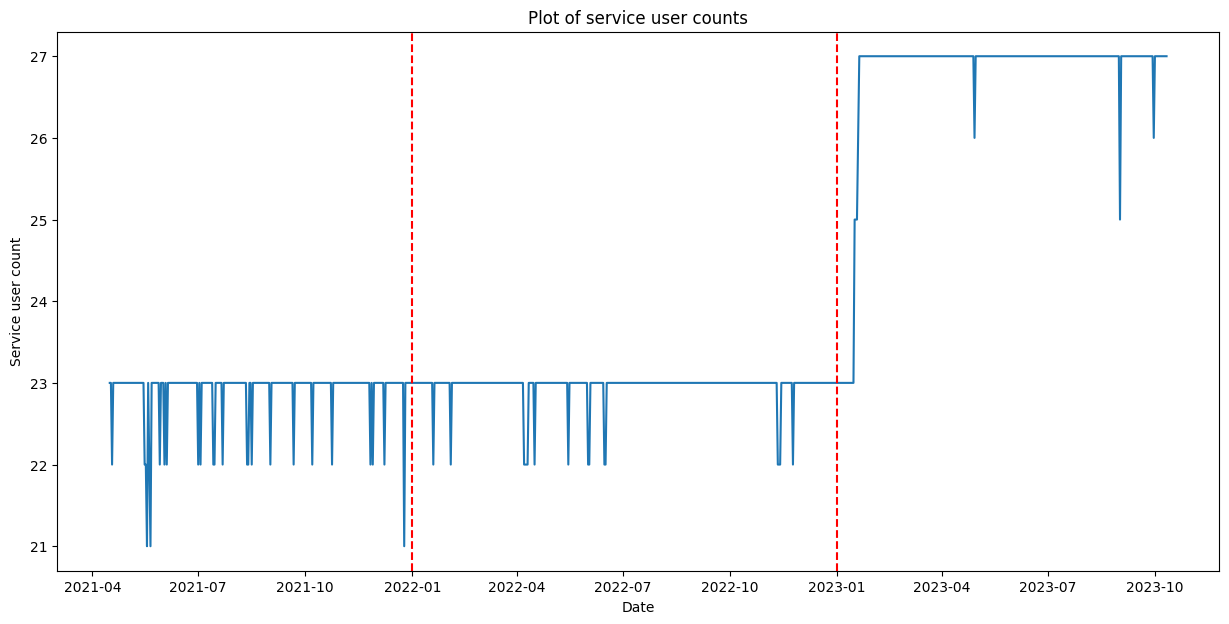

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,0)(0,0,0)[0] intercept


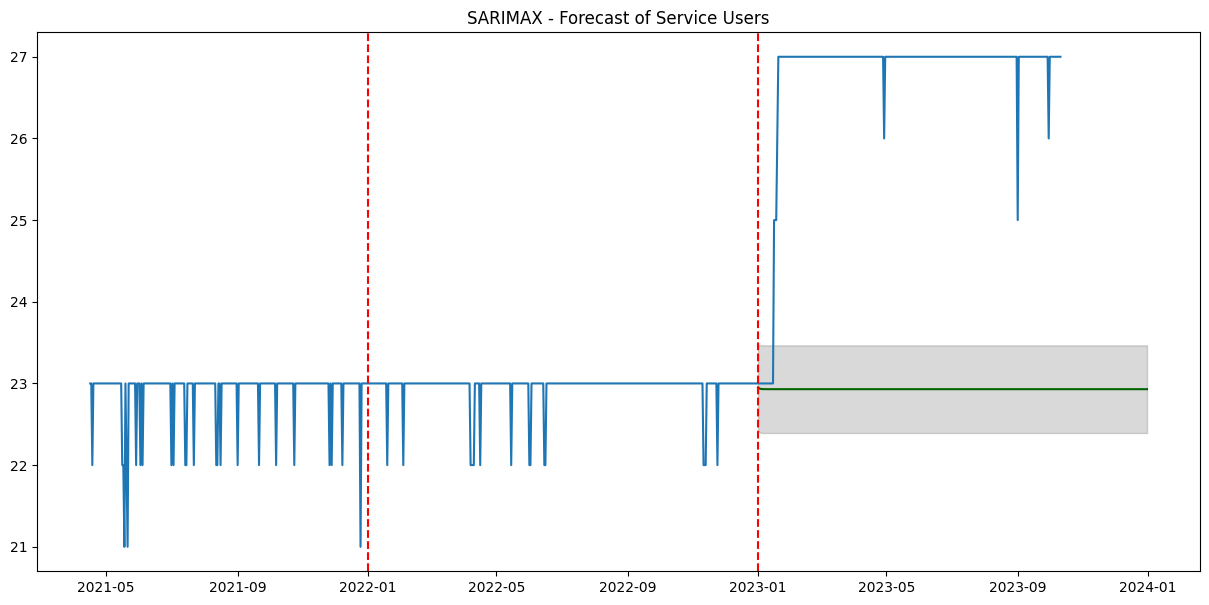

MSE:  15.443730483025215
RMSE:  3.92985120367492
MAE:  3.8201005497738416
Mimico-Queensway


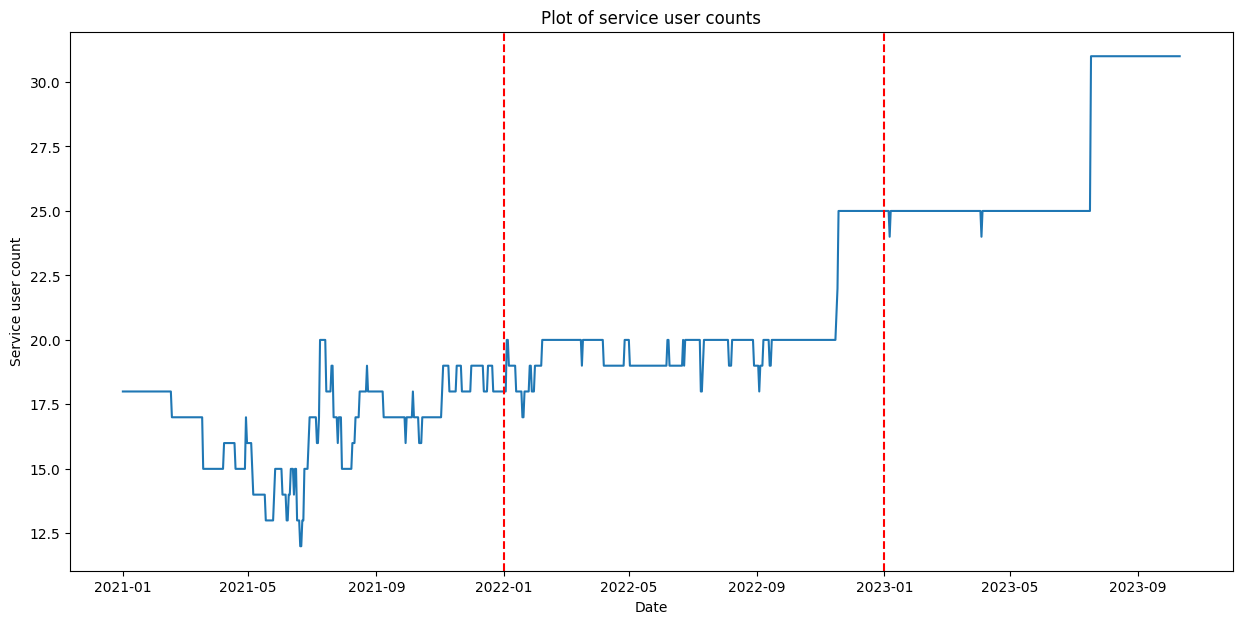

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[0]          


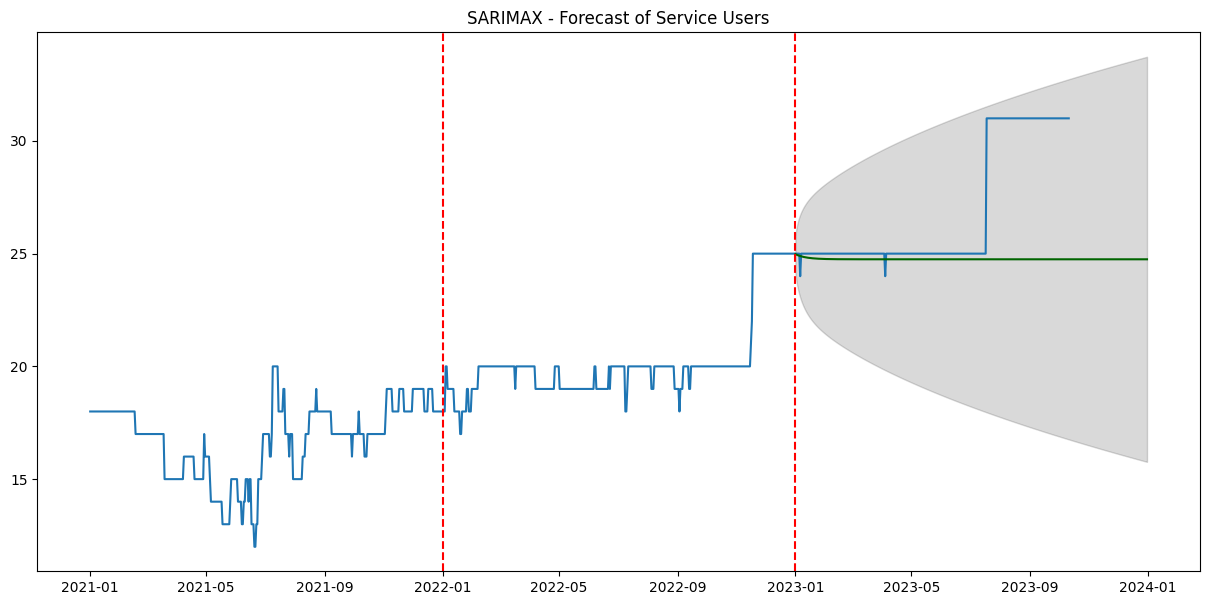

MSE:  11.878441860866767
RMSE:  3.446511549504334
MAE:  2.063458338252415
Moss Park


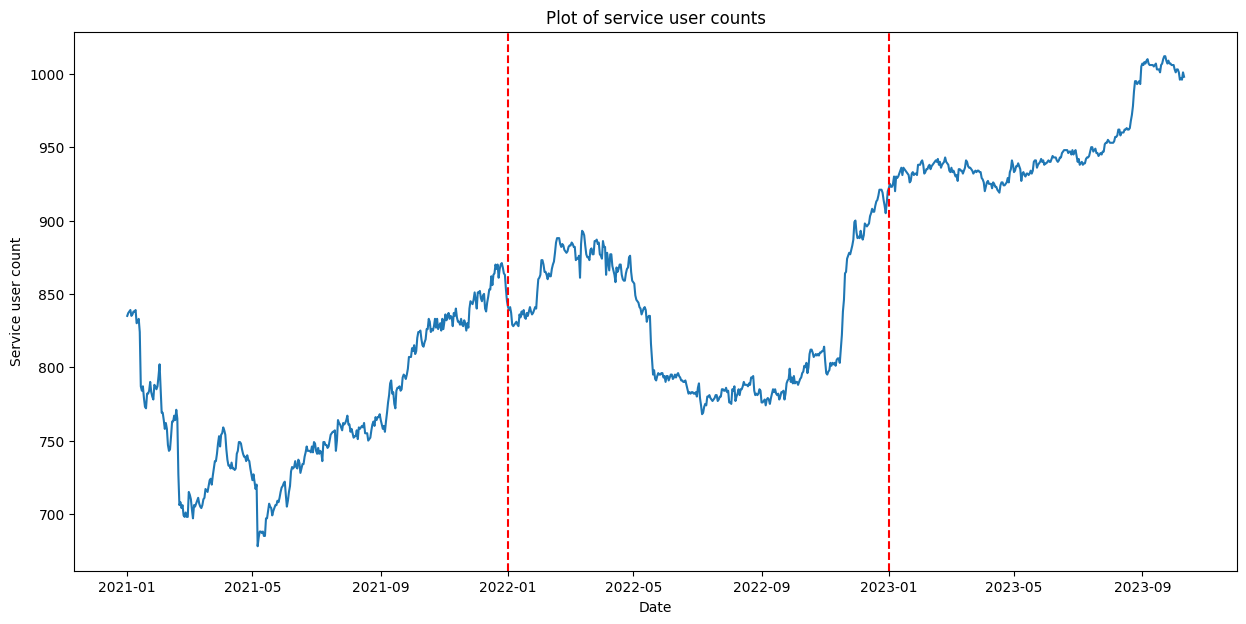

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(0,0,0)[0]          


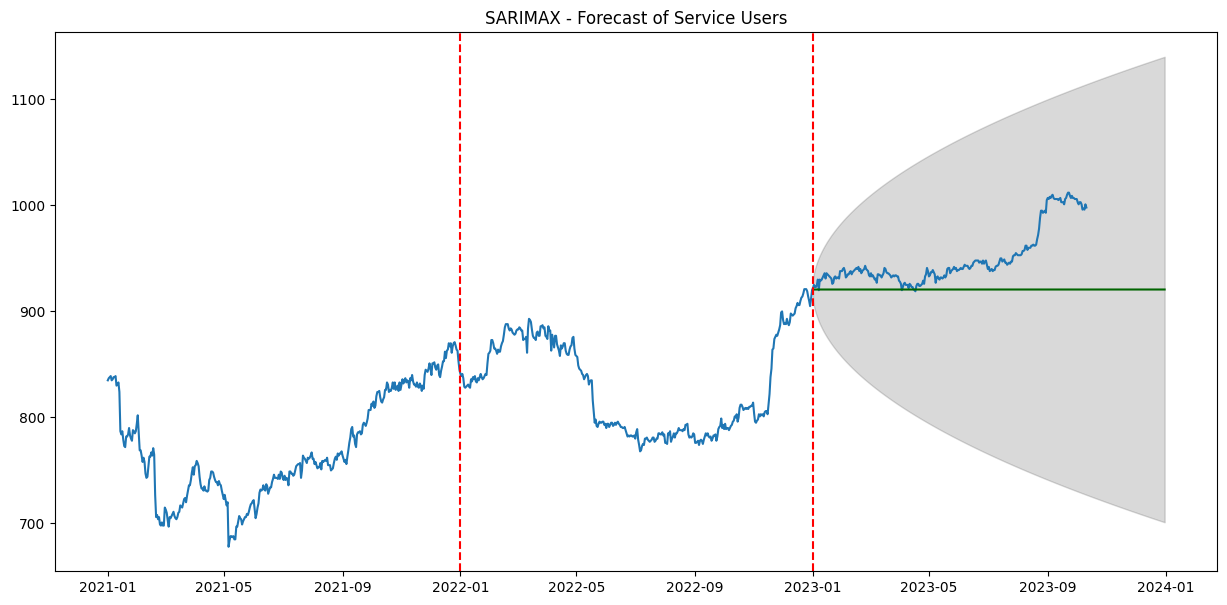

MSE:  1543.5069702822966
RMSE:  39.28749126989781
MAE:  29.188465489581112
Newtonbrook East


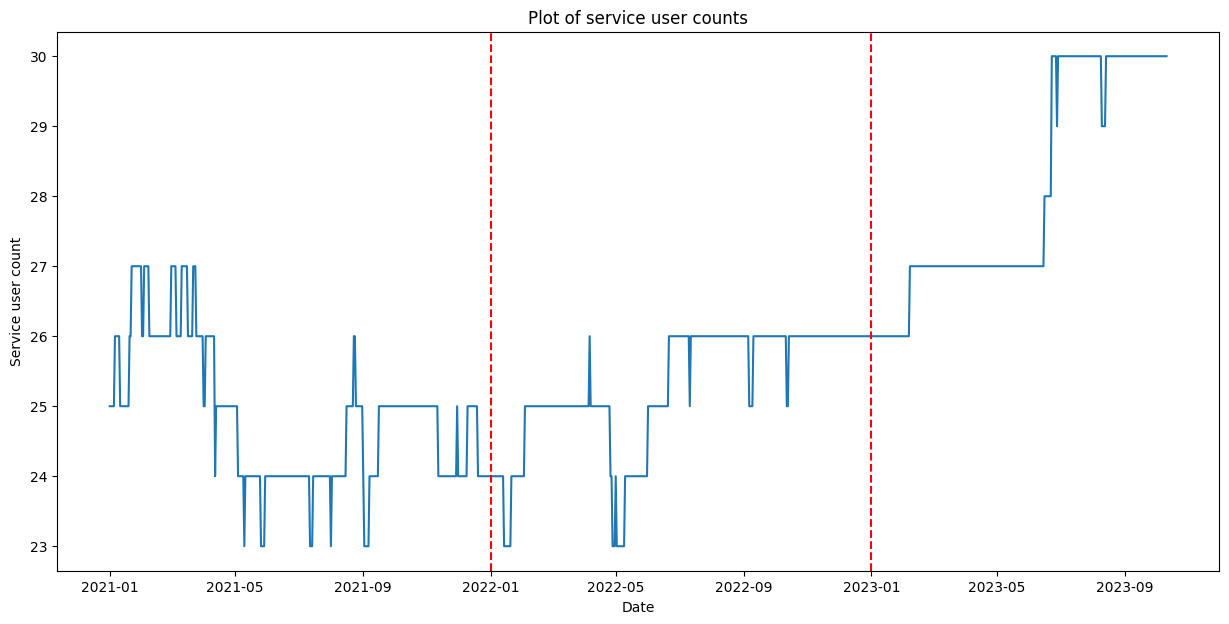

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[0]          


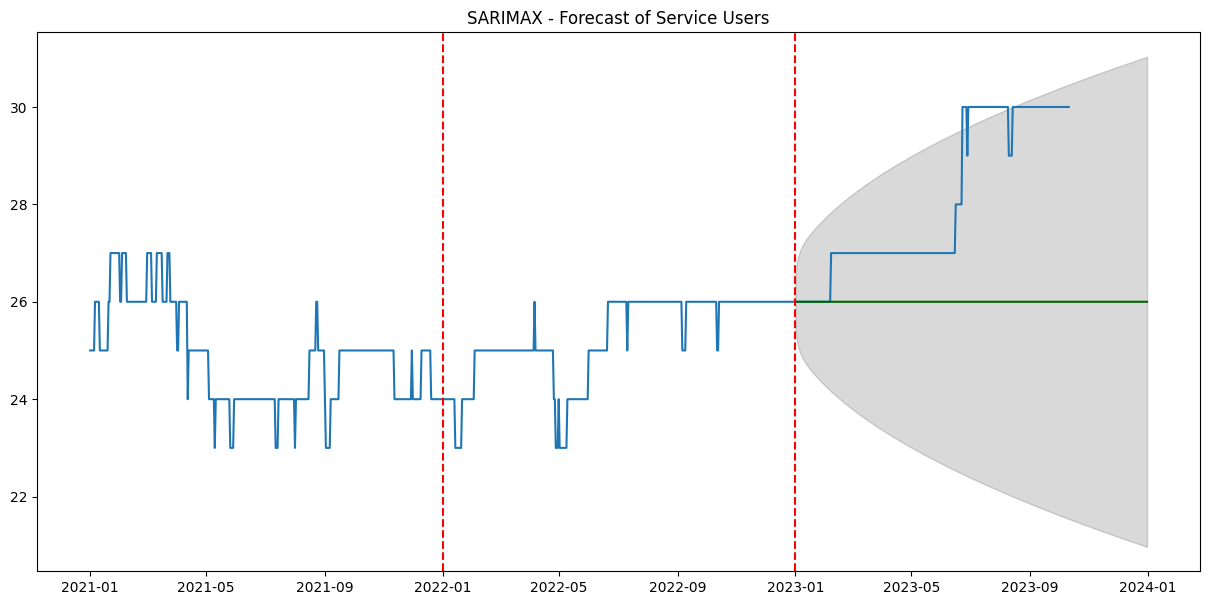

MSE:  6.683150225577219
RMSE:  2.585178954265491
MAE:  2.0493082266395564
North St.James Town


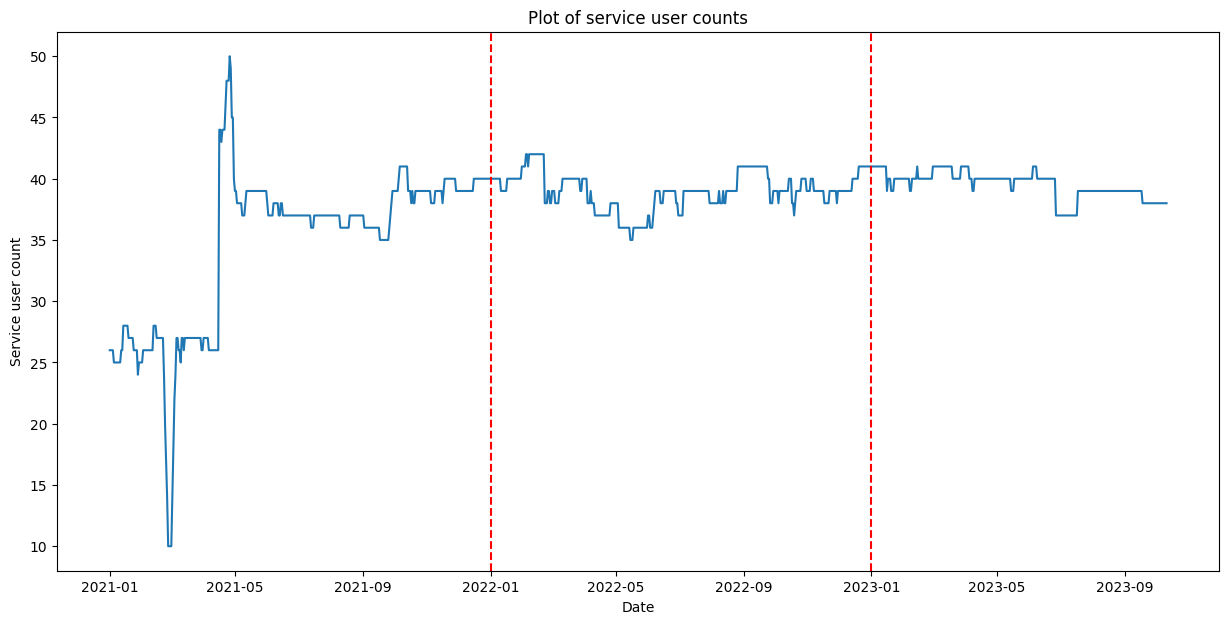

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,0)[0] intercept


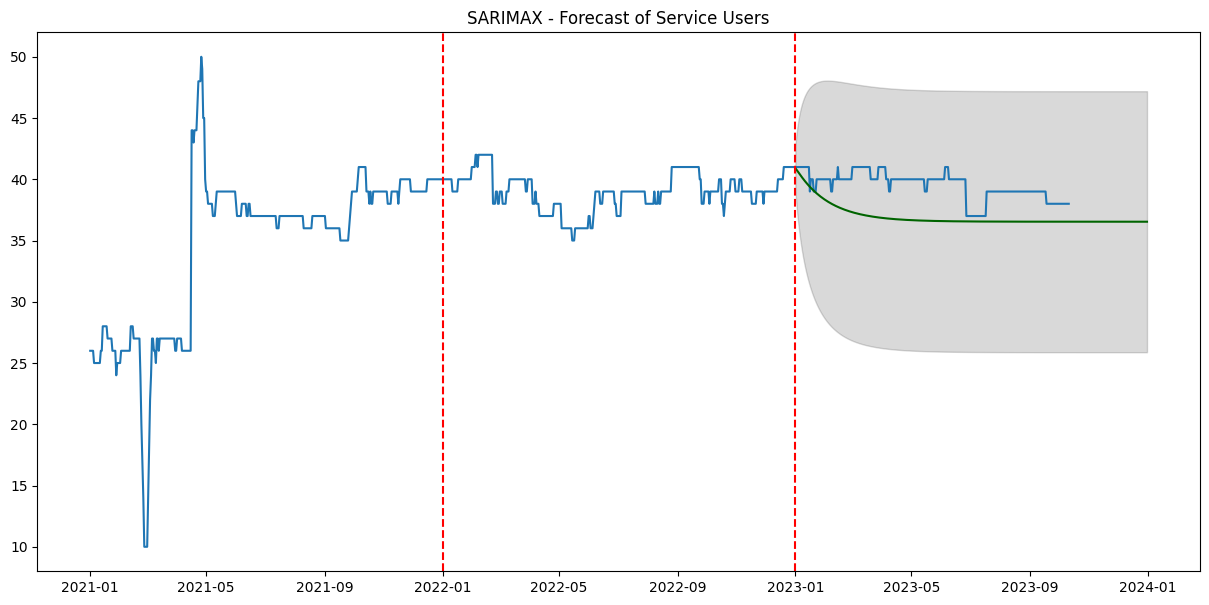

MSE:  7.197170252189943
RMSE:  2.68275422880851
MAE:  2.4498454297378327
North Toronto


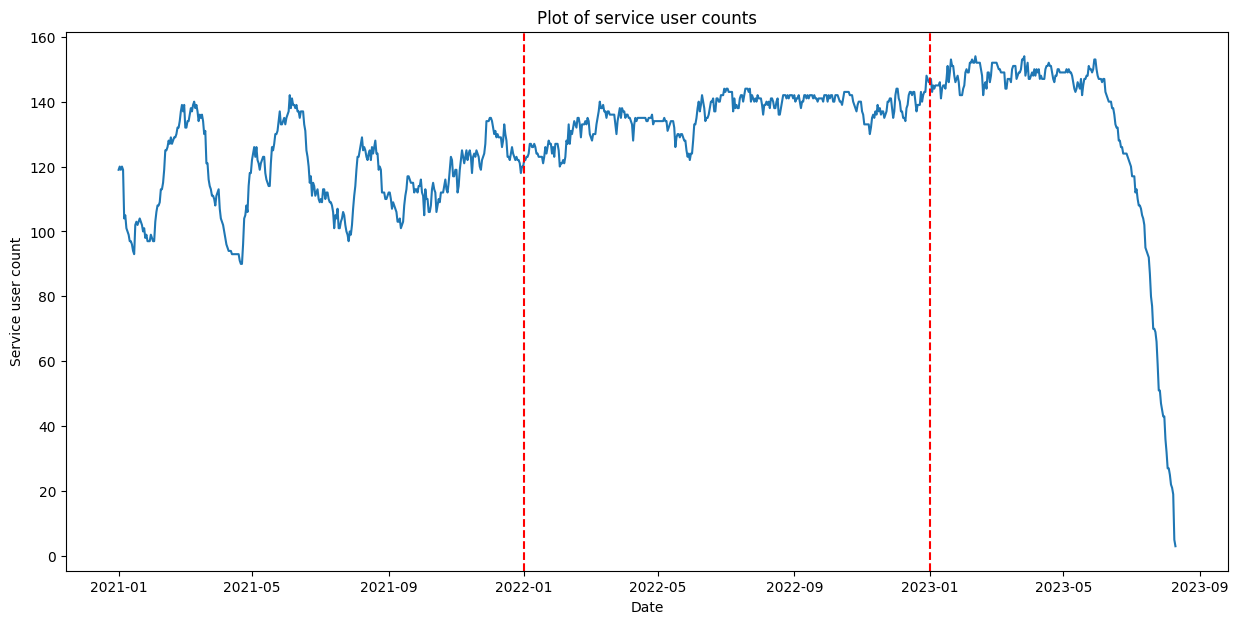

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,0,0)[0] intercept


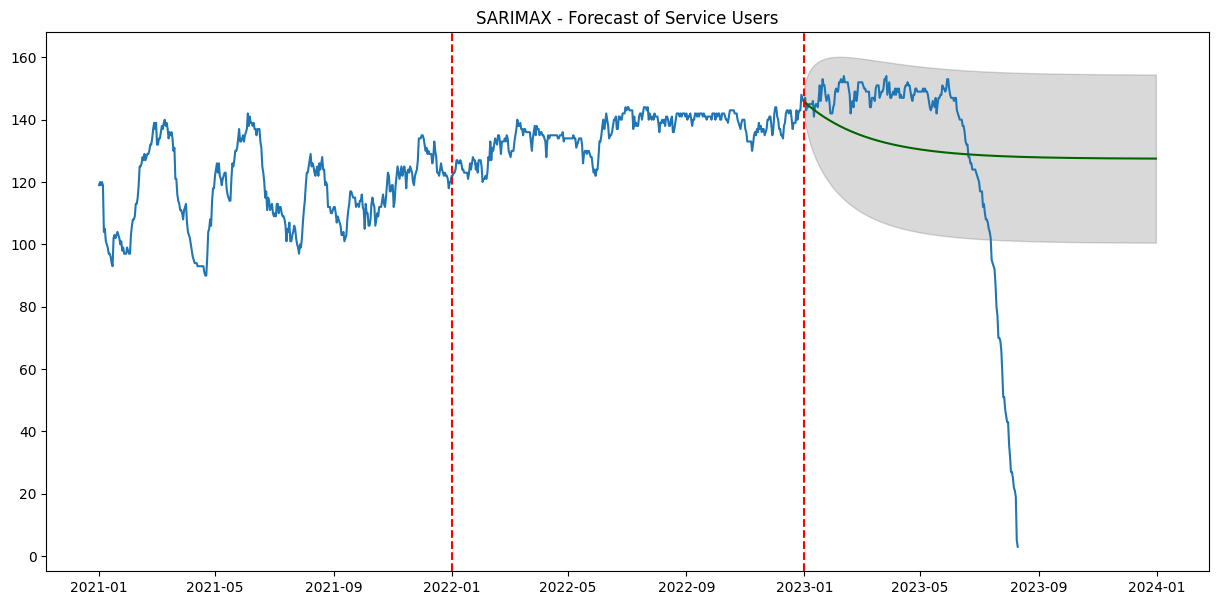

MSE:  1018.8030919120312
RMSE:  31.9186950220718
MAE:  21.205984924262175
Oakwood Village


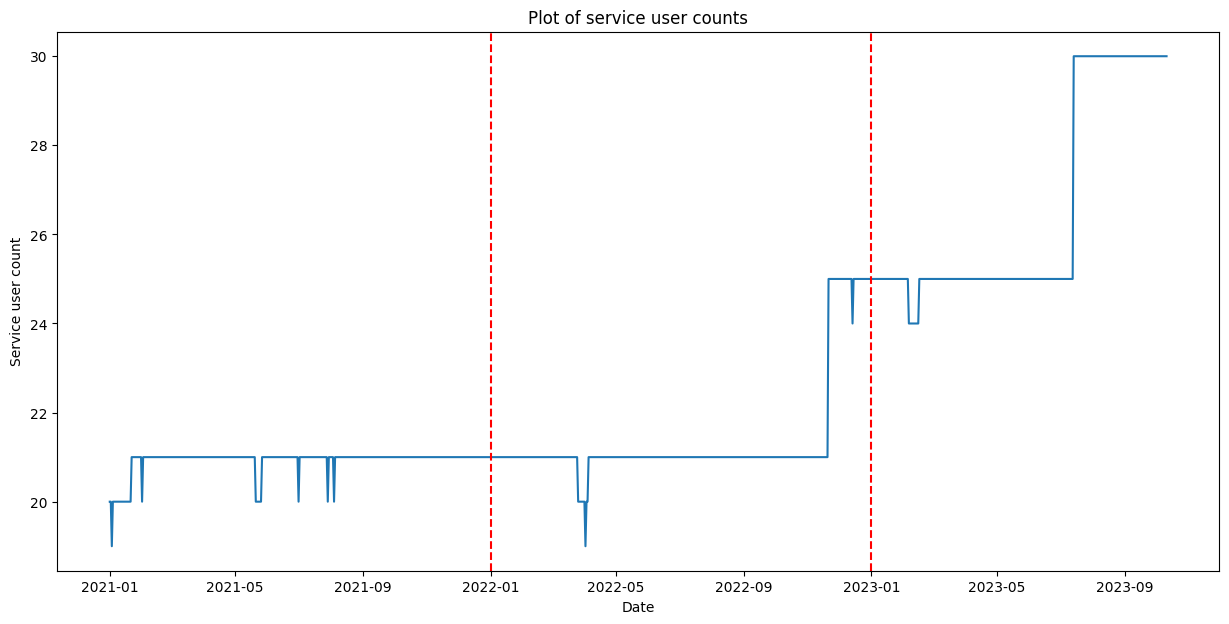

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(0,0,0)[0]          


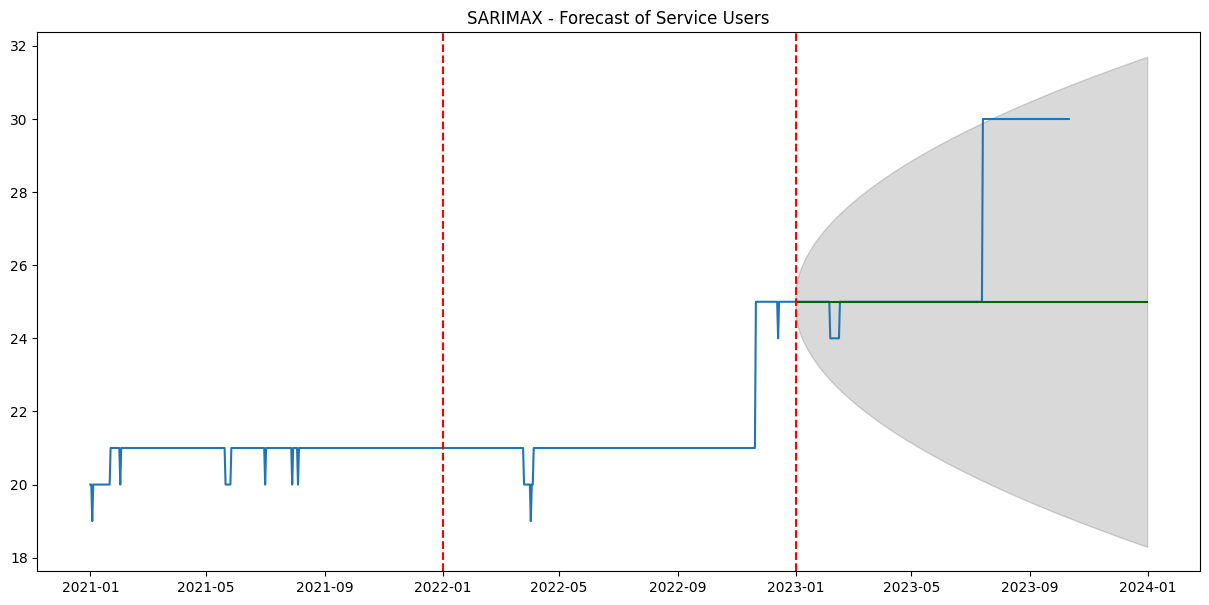

MSE:  7.957746478873239
RMSE:  2.8209477979702564
MAE:  1.619718309859155
Palmerston-Little Italy


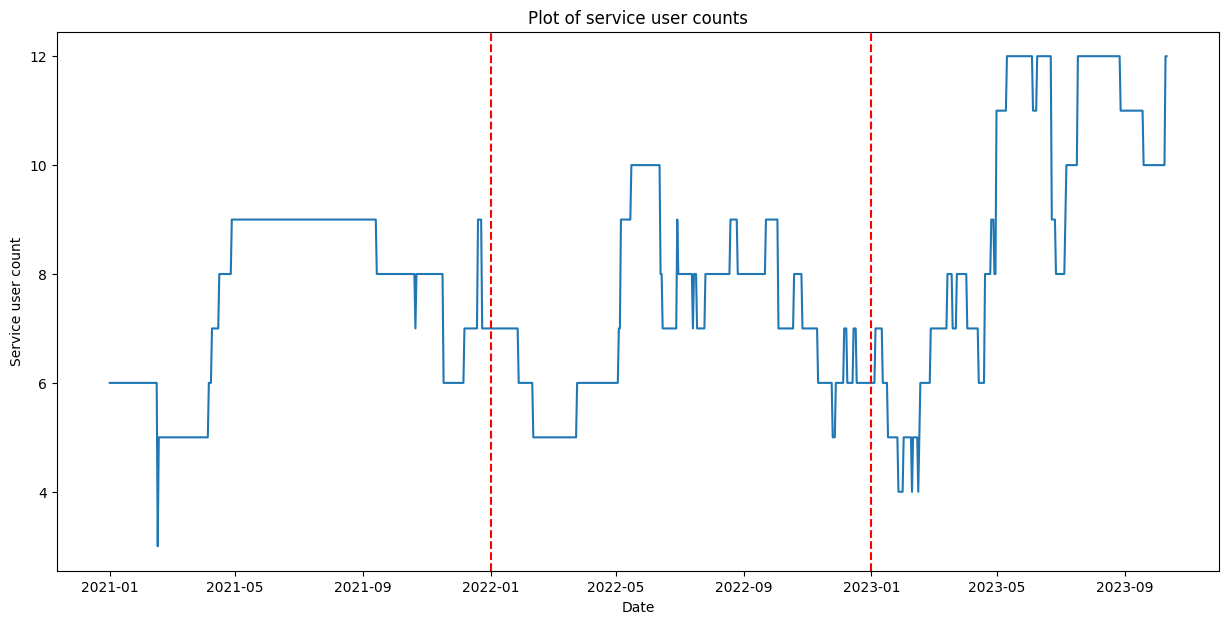

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(0,0,0)[0]          


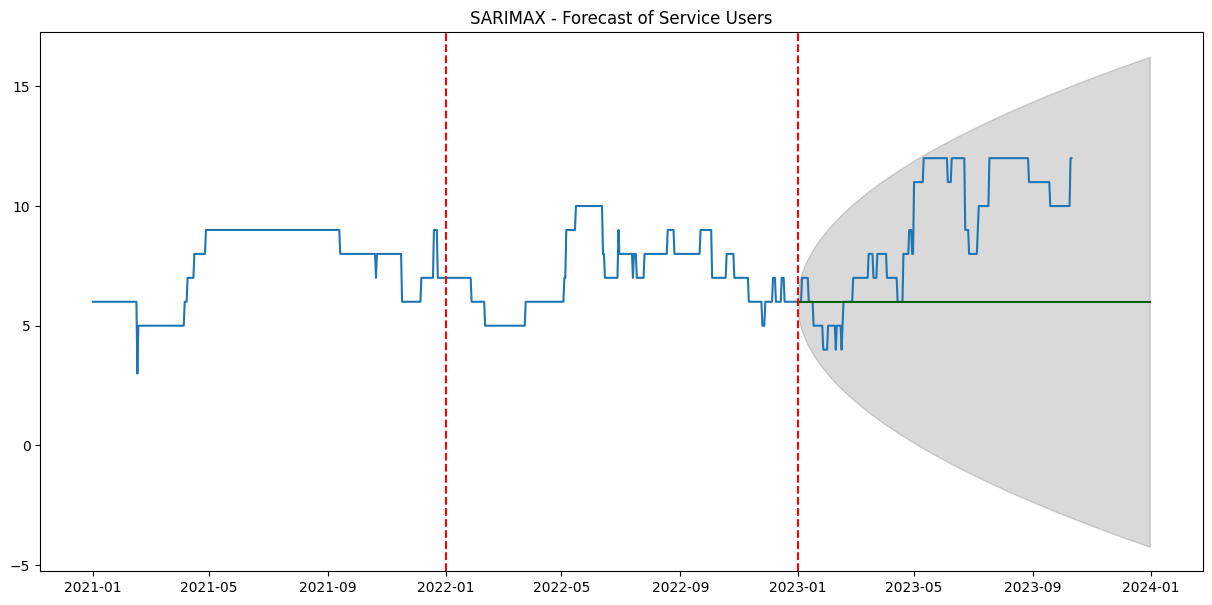

MSE:  16.387323943661972
RMSE:  4.048125979223222
MAE:  3.3943661971830985
Regent Park


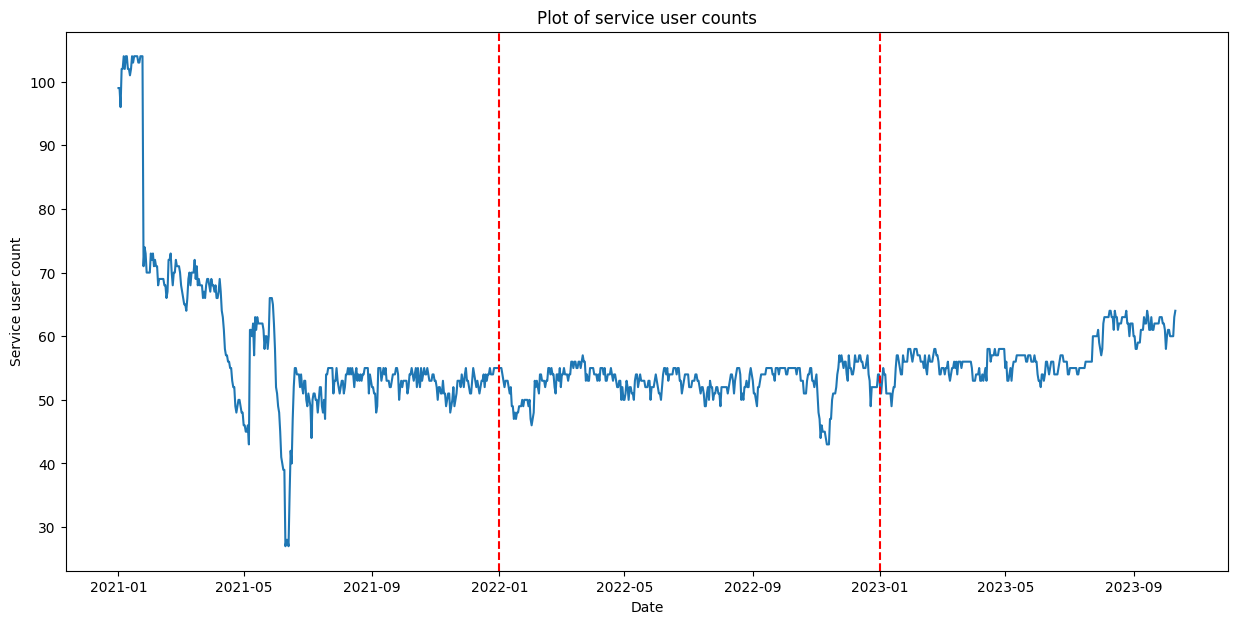

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,2)(0,0,0)[0] intercept


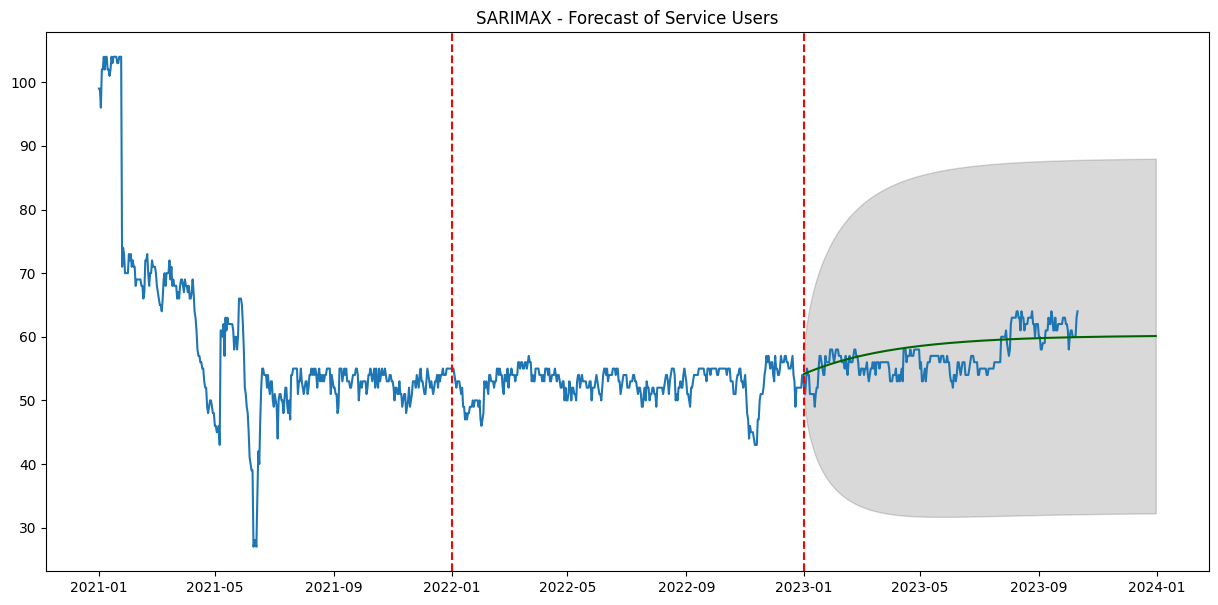

MSE:  8.64793745637289
RMSE:  2.940737570129795
MAE:  2.497086947259923
Rosedale-Moore Park


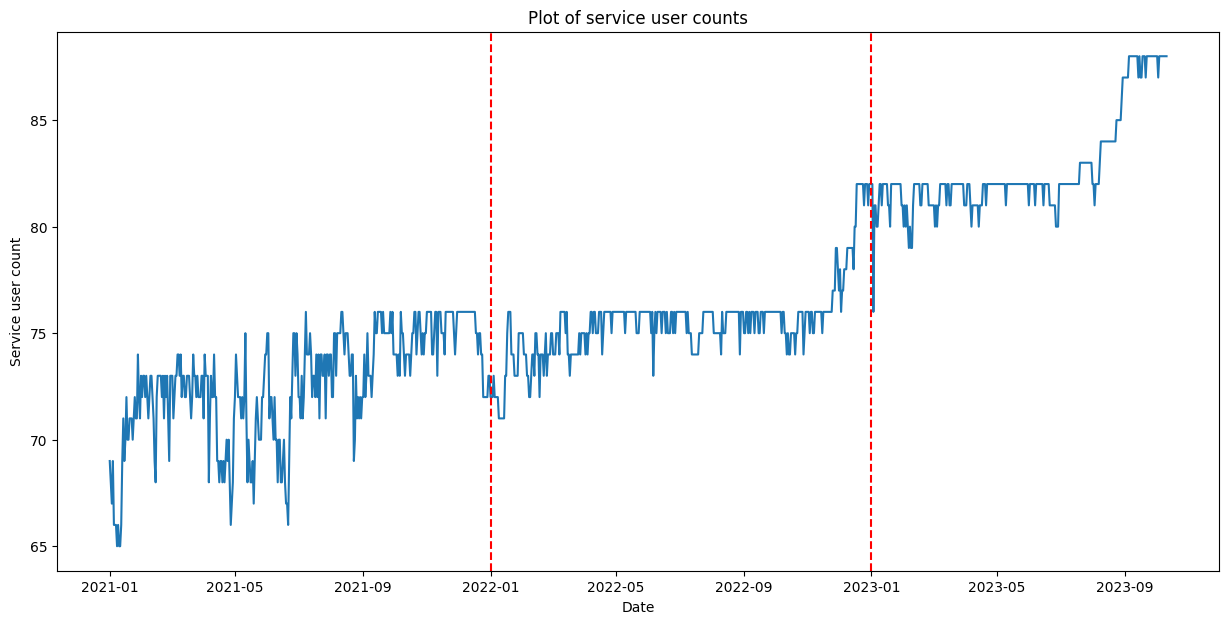

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,2)(0,0,0)[0] intercept


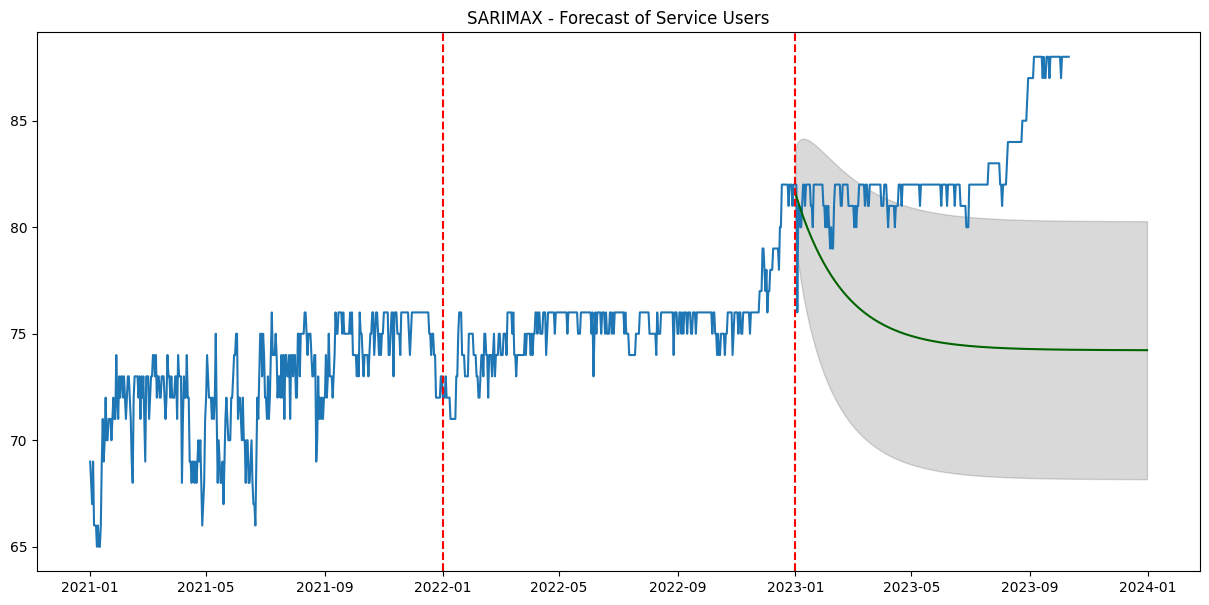

MSE:  64.64308362467631
RMSE:  8.040092264686788
MAE:  7.27901260417778
Scarborough Village


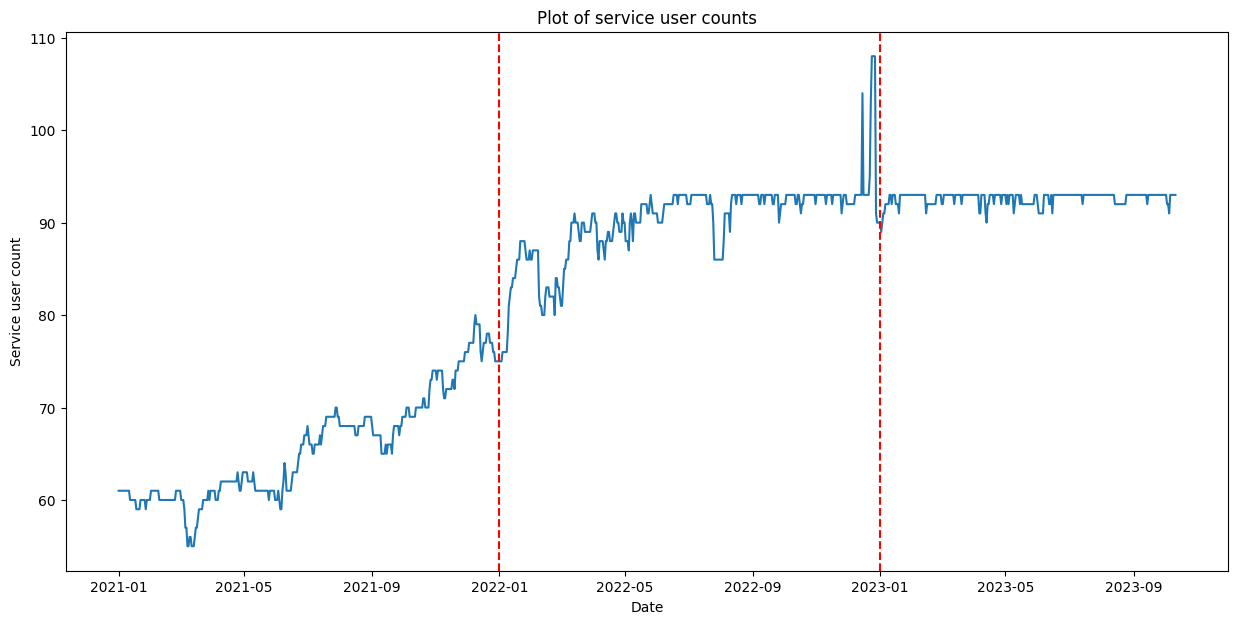

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[0] intercept


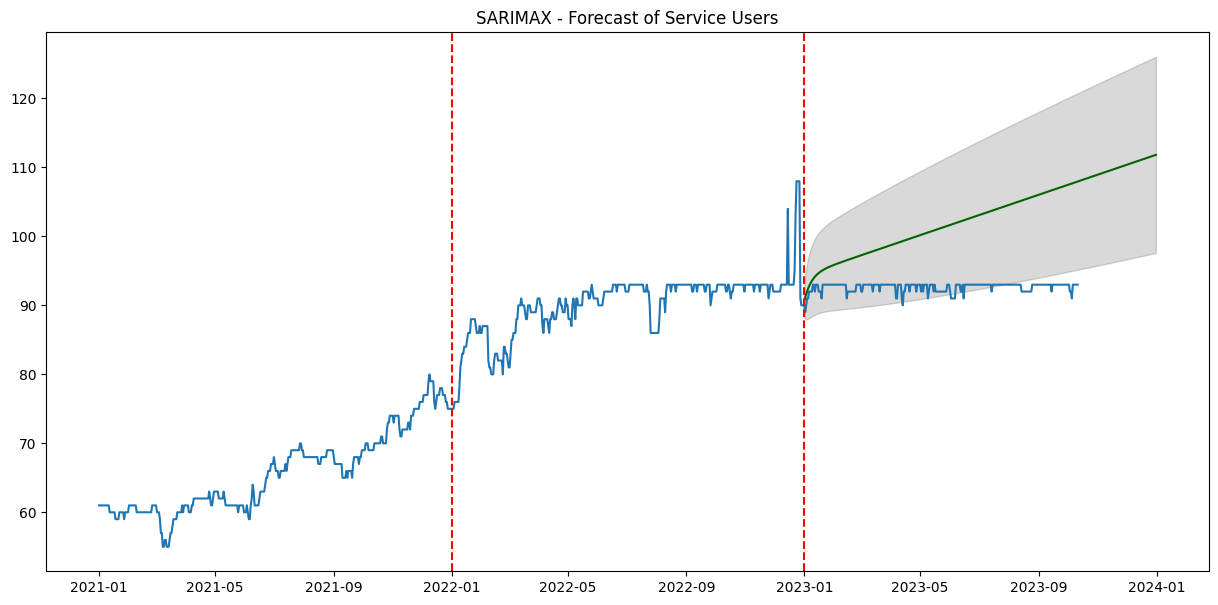

MSE:  87.4717174427953
RMSE:  9.352631578480748
MAE:  8.460718569480091
South Parkdale


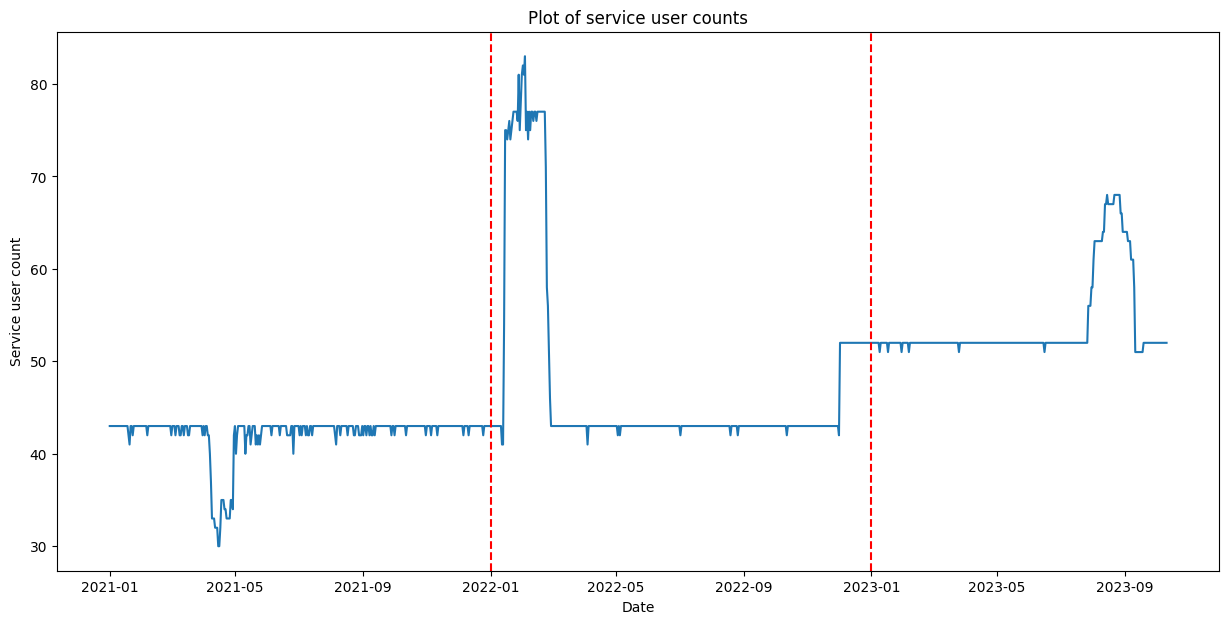

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(0,0,0)[0]          


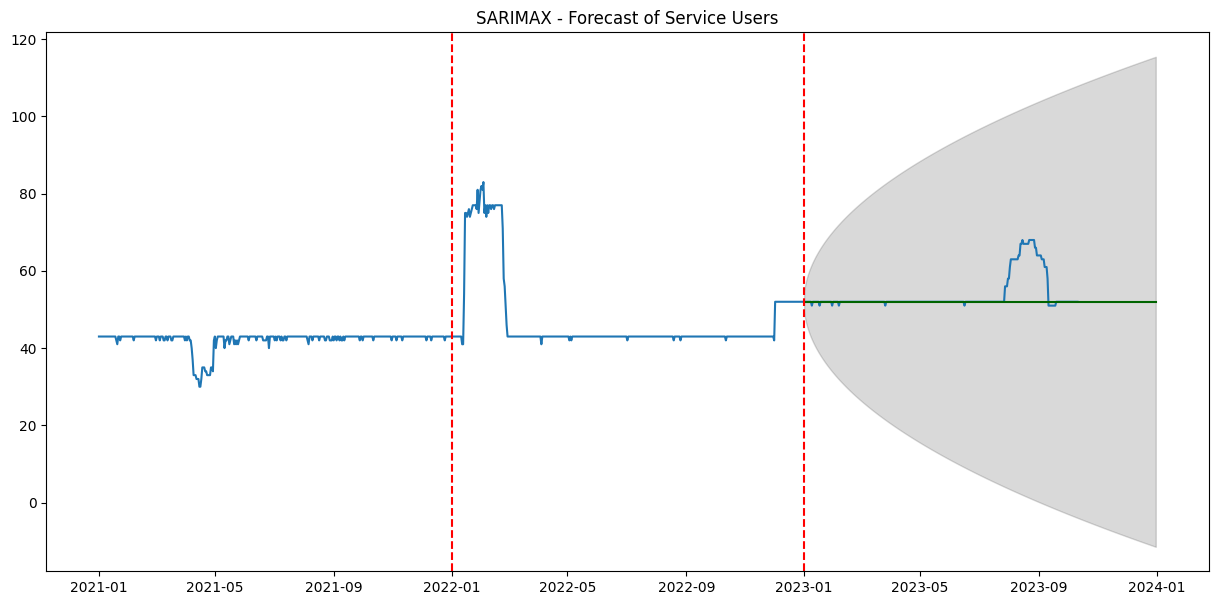

MSE:  24.003521126760564
RMSE:  4.8993388458812035
MAE:  1.9190140845070423
South Riverdale


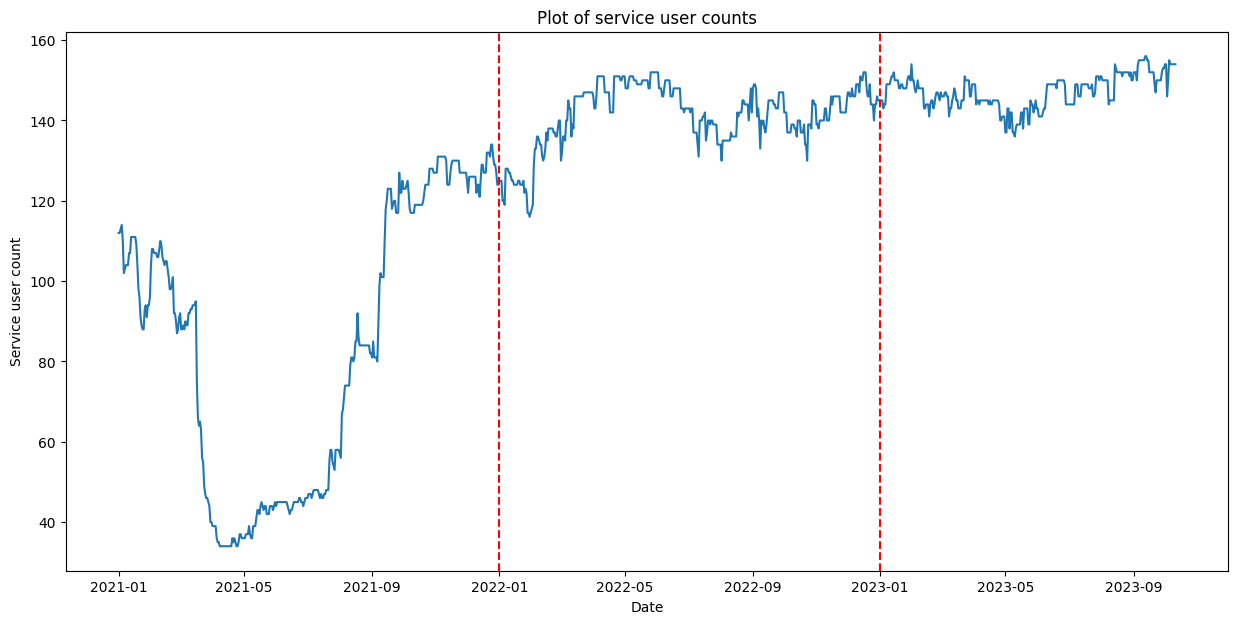

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[0]          


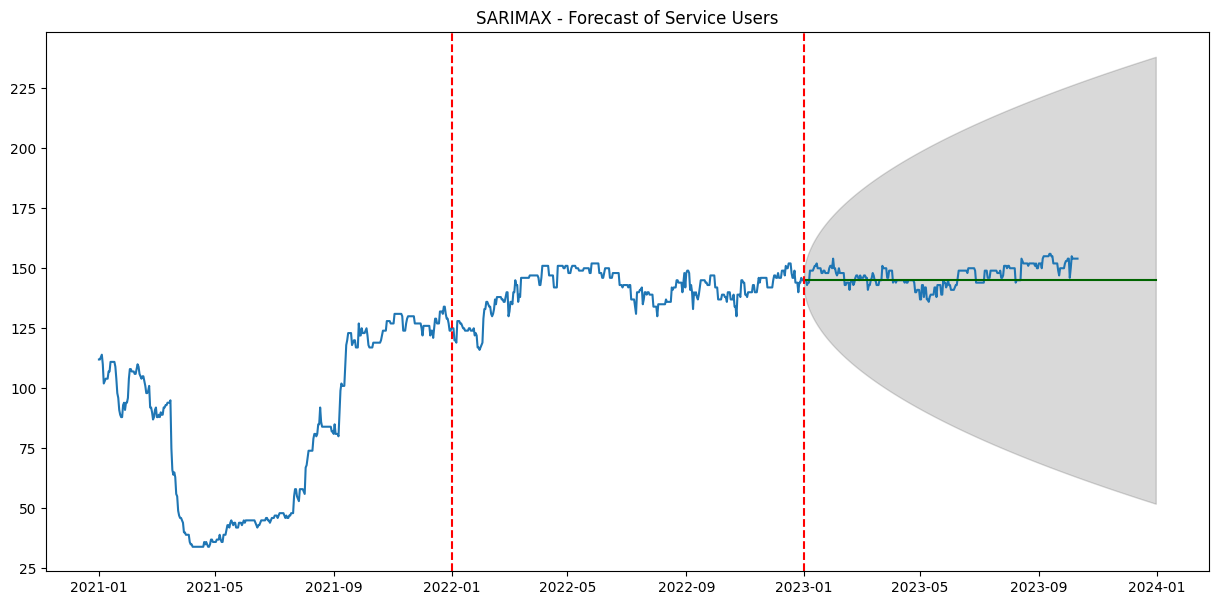

MSE:  22.676056338028168
RMSE:  4.76193829632726
MAE:  3.8380281690140845
St Lawrence-East Bayfront-The Islands


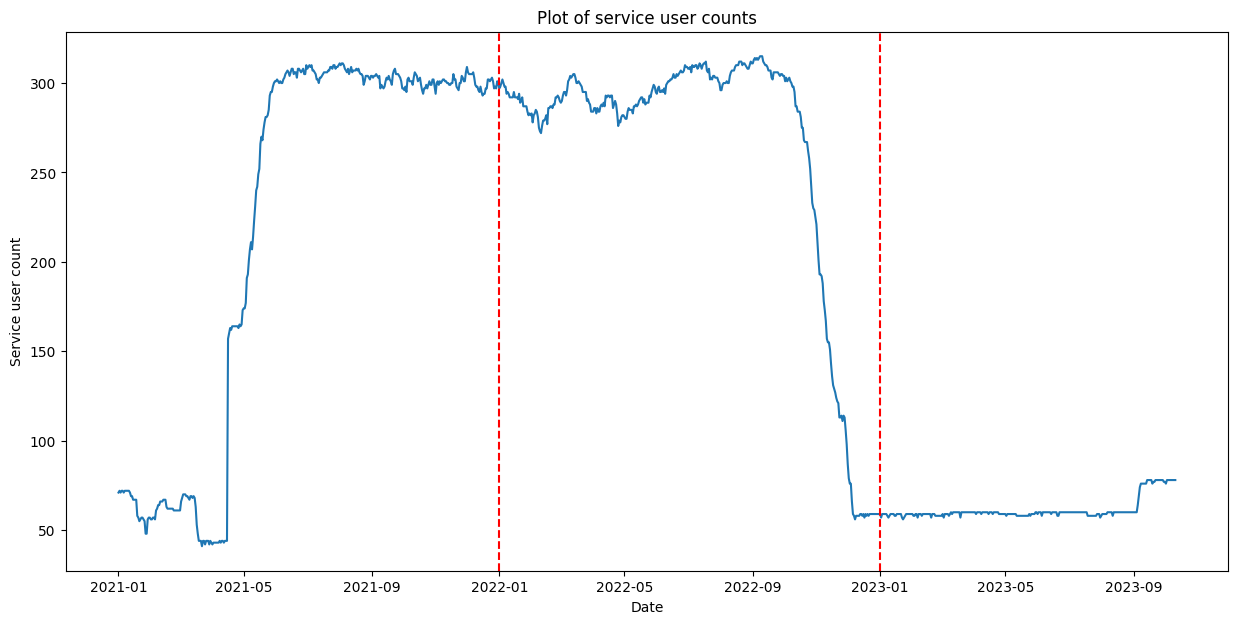

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[0]          


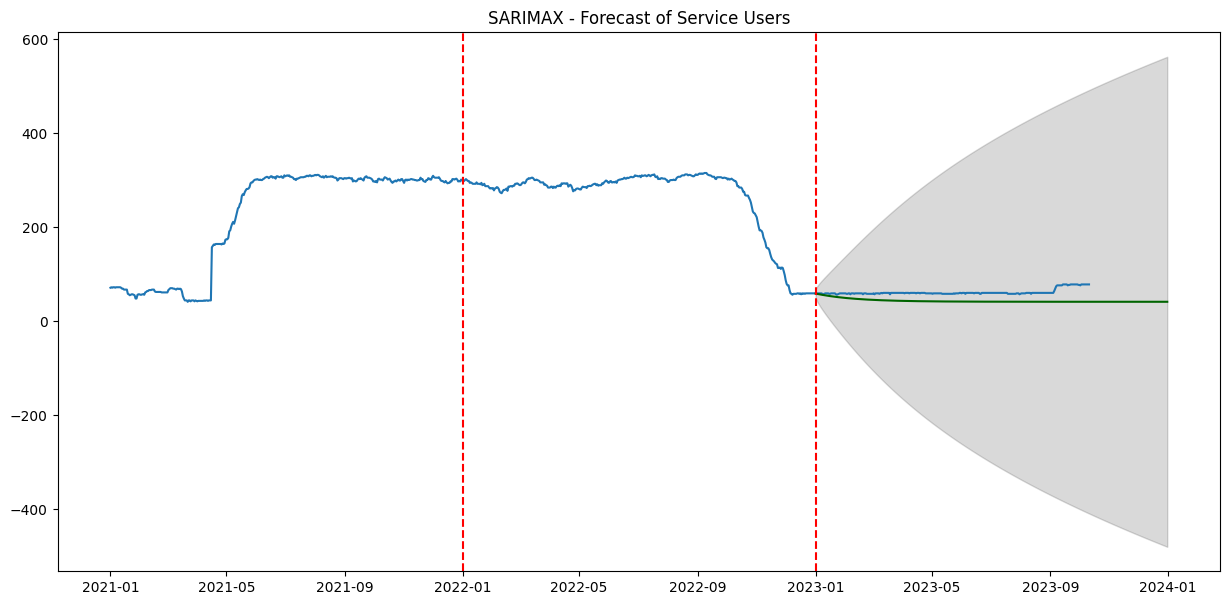

MSE:  385.67799195305093
RMSE:  19.638686105568542
MAE:  17.879160506006837
Thistletown-Beaumond Heights


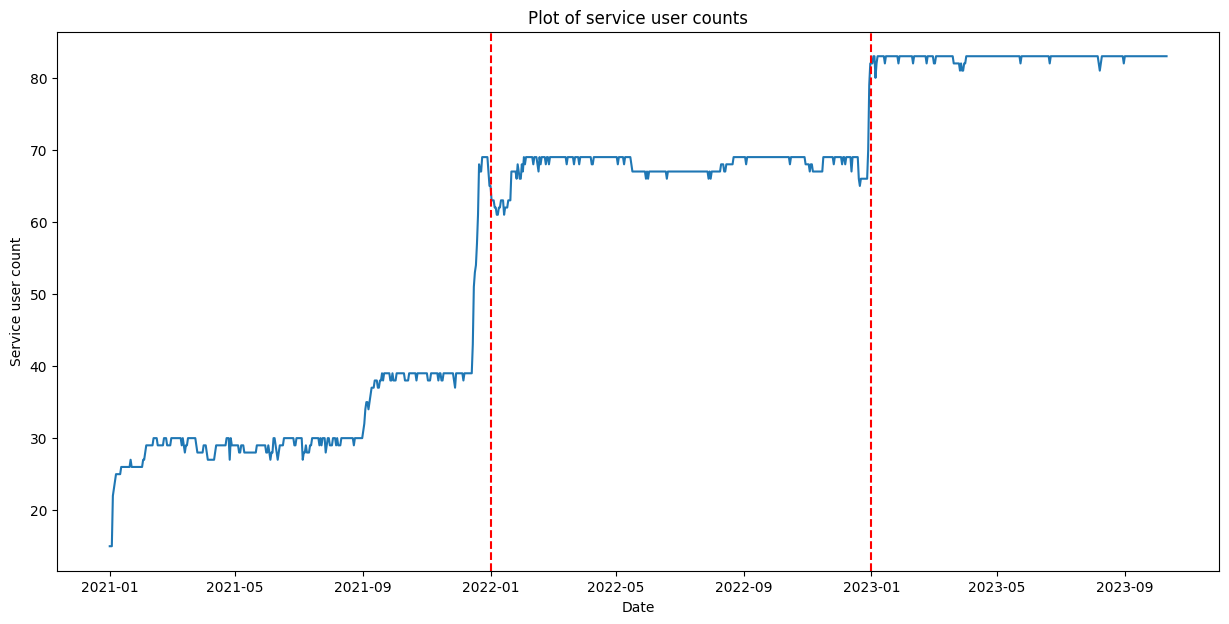

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[0] intercept


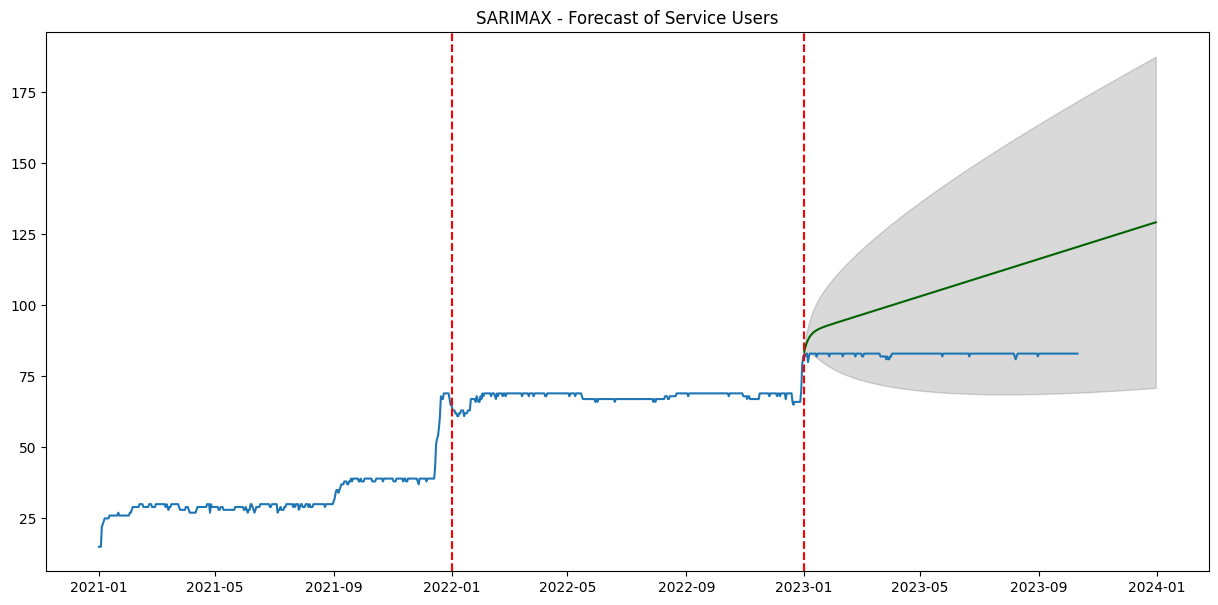

MSE:  582.9136223670538
RMSE:  24.143604171023302
MAE:  22.436175078069358
University


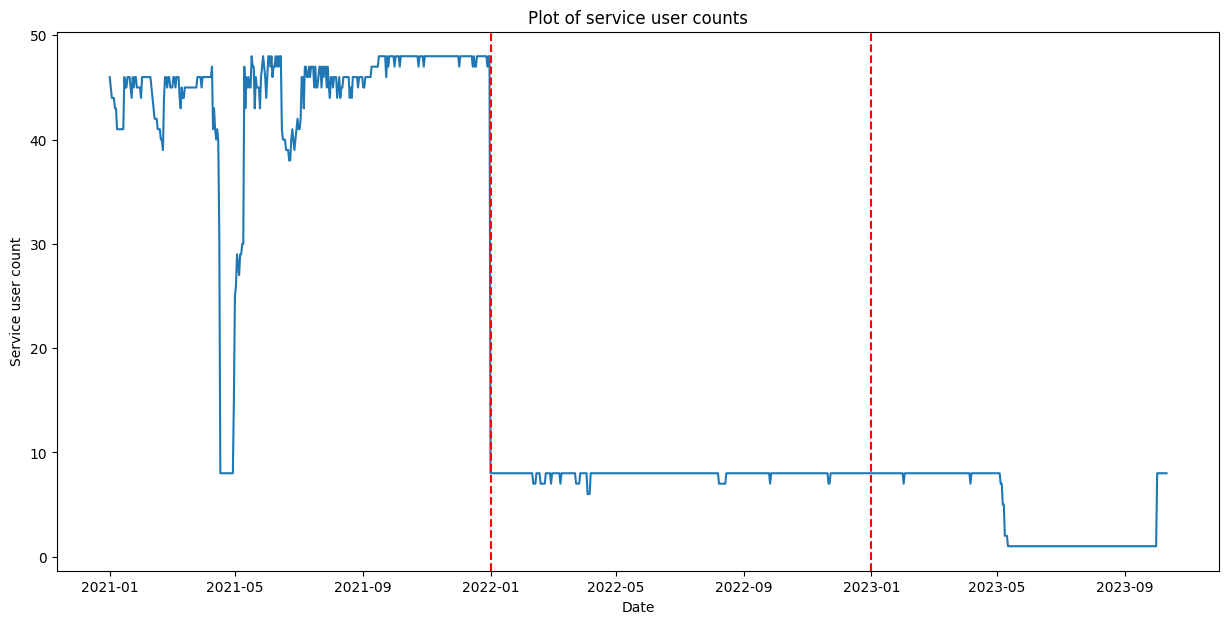

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[0]          


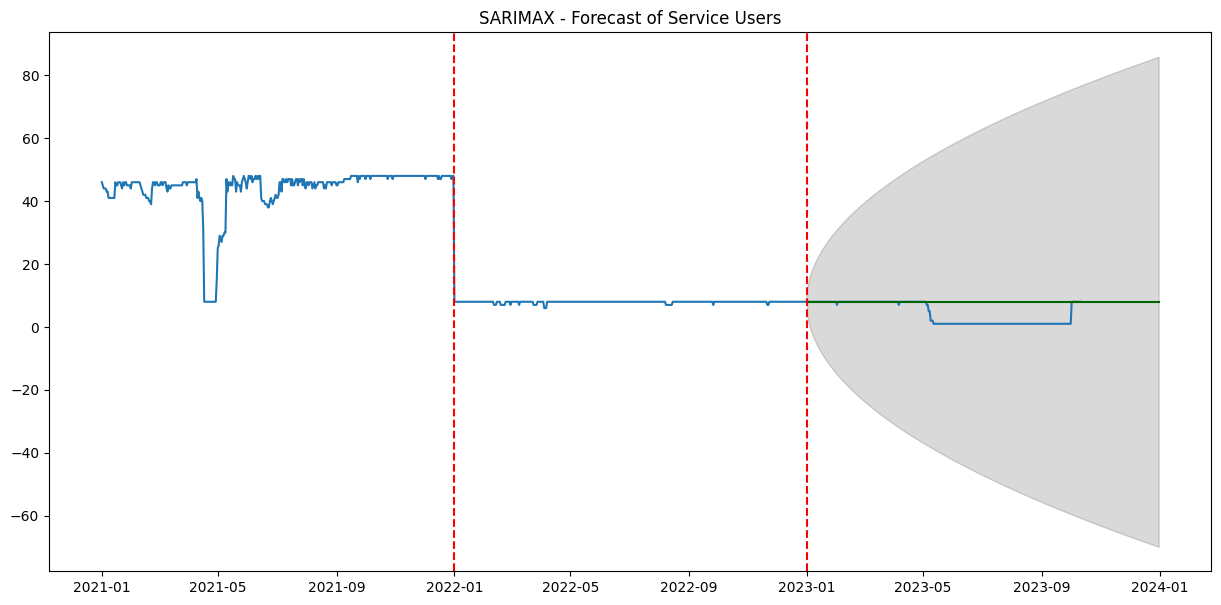

MSE:  25.130281690140844
RMSE:  5.013011239778028
MAE:  3.6232394366197185
Wellington Place


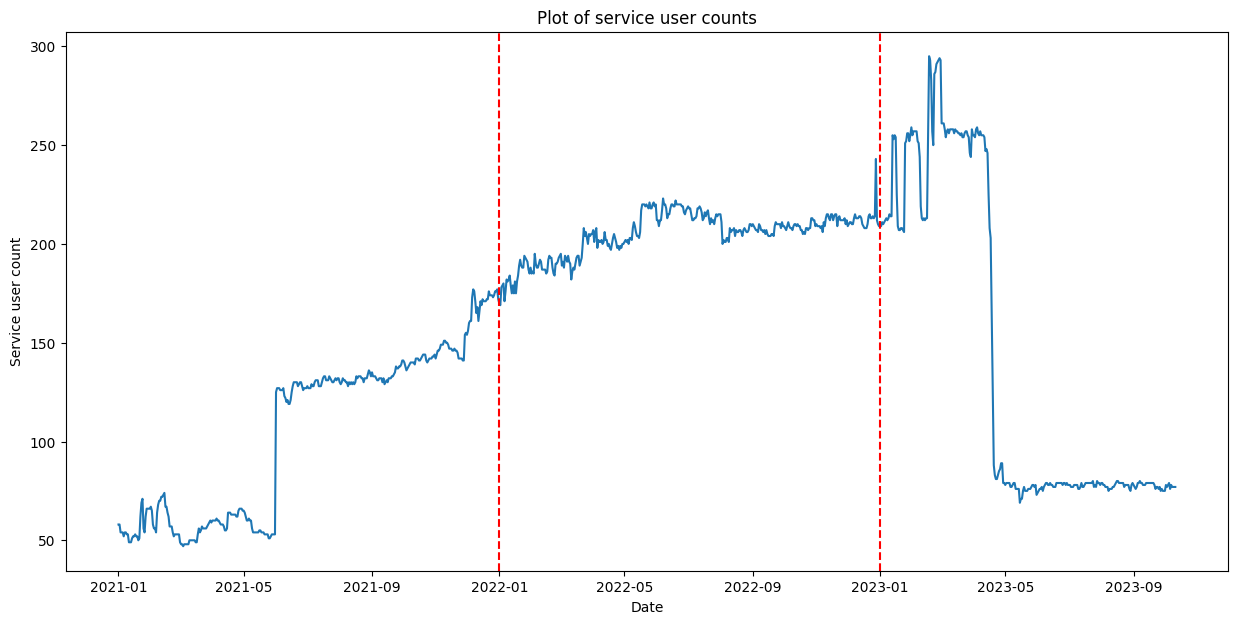

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[0] intercept


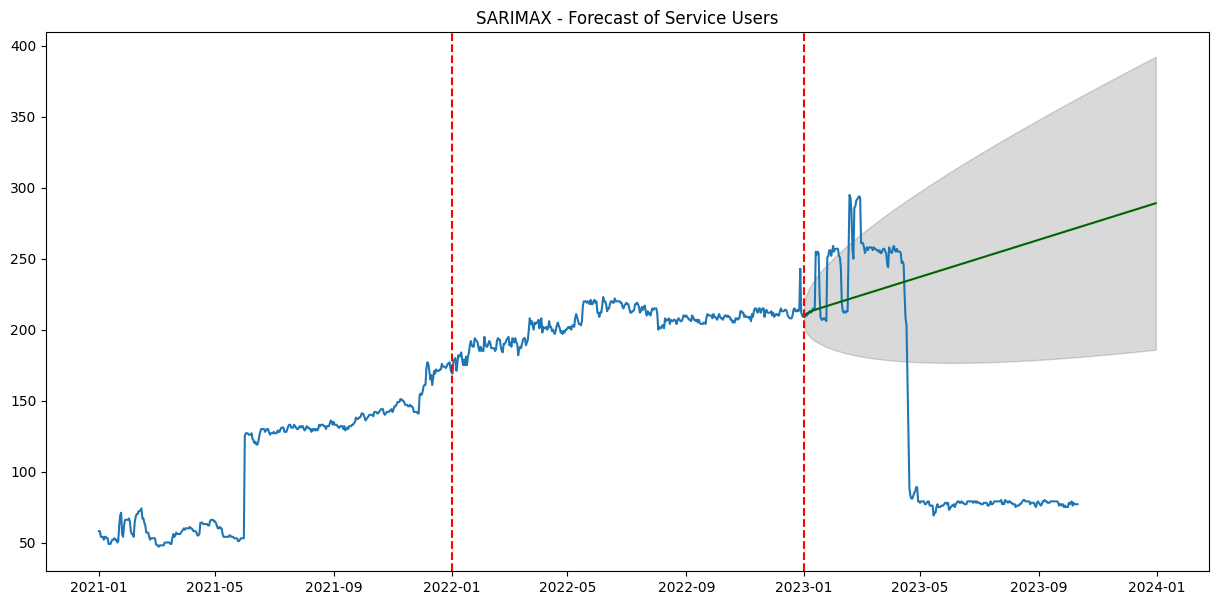

MSE:  19499.547427841895
RMSE:  139.64077996001703
MAE:  118.79220360651038
West Hill


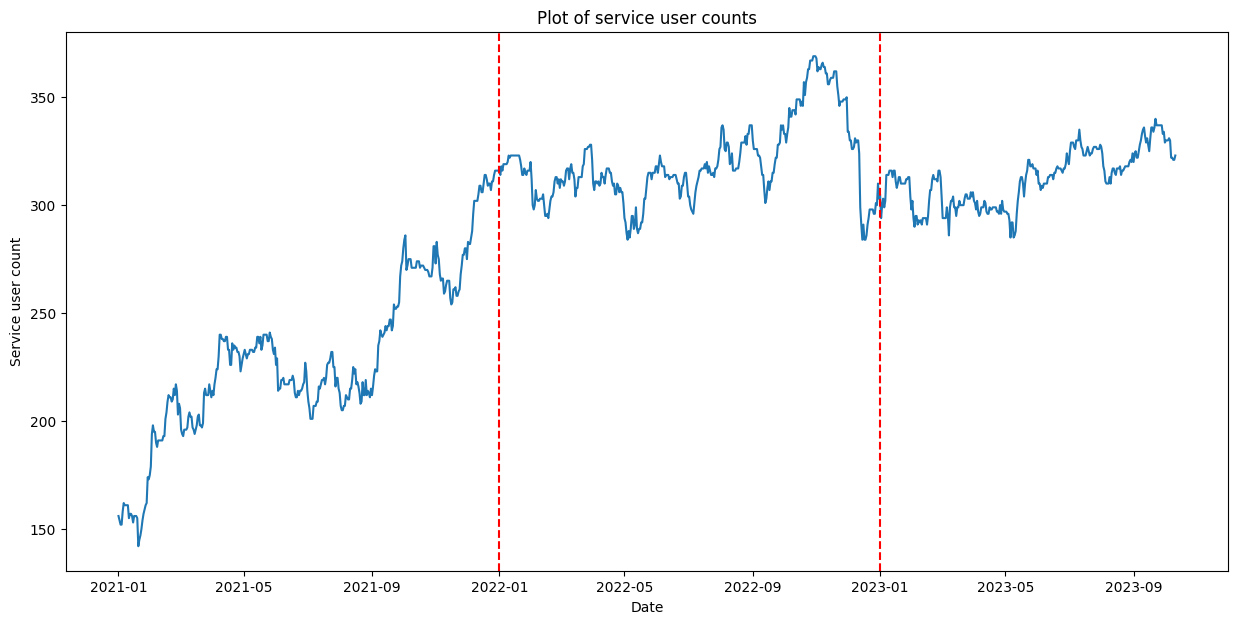

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(0,0,0)[0]          


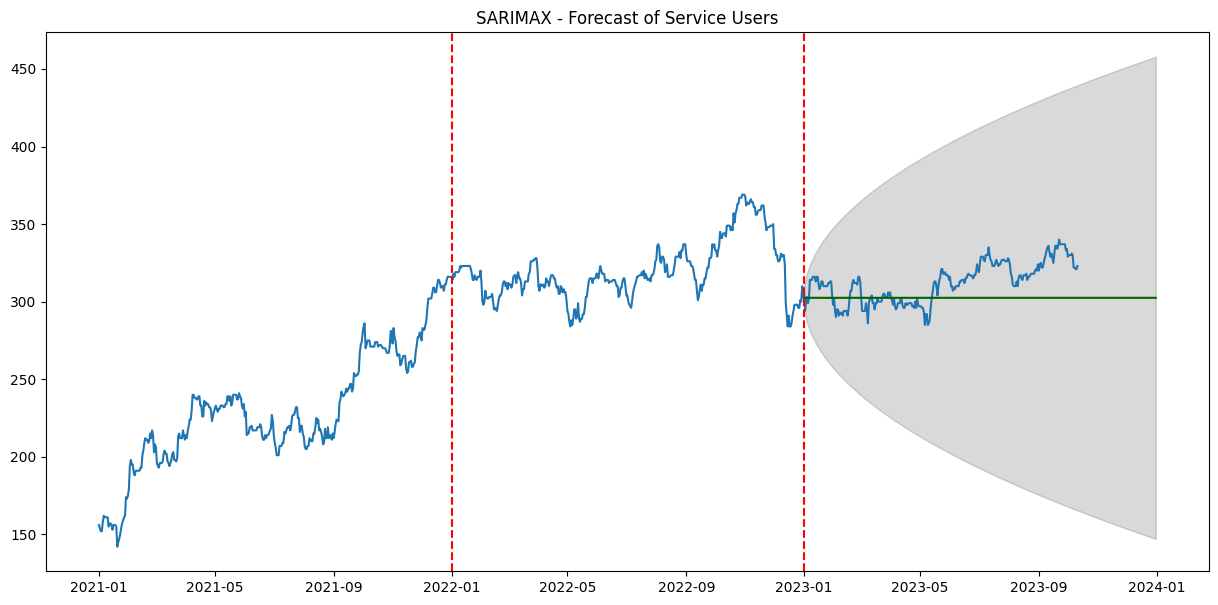

MSE:  257.92607920142285
RMSE:  16.06007718541299
MAE:  13.214086020782247
West Humber-Clairville


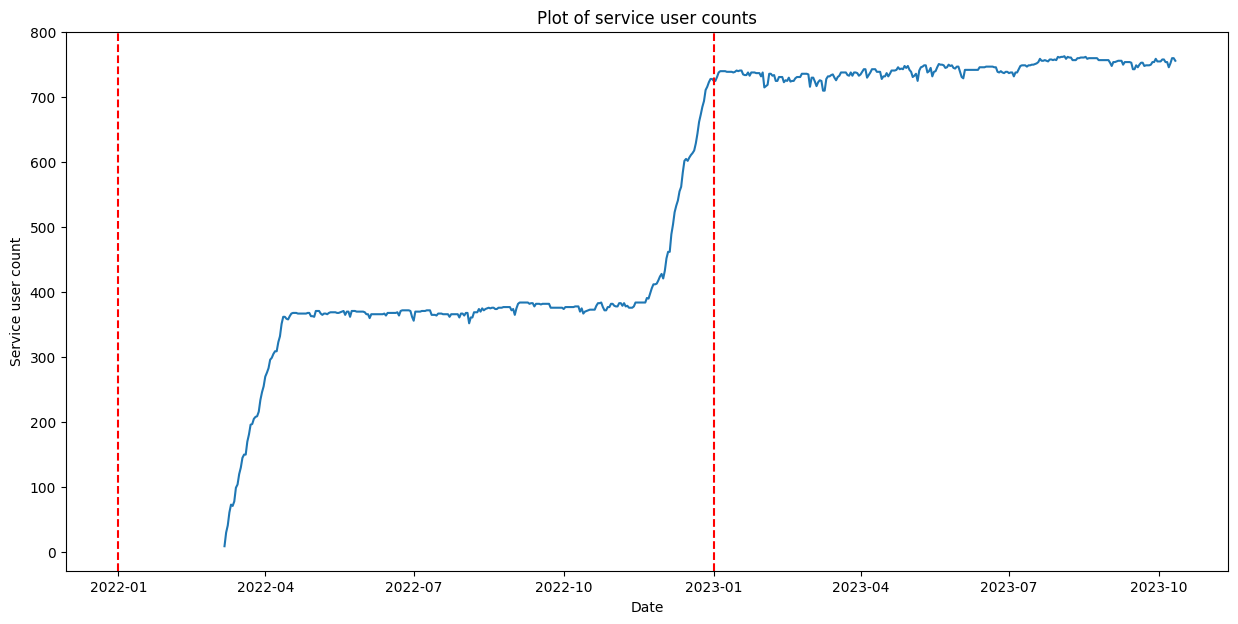

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,2,1)(0,0,0)[0]          


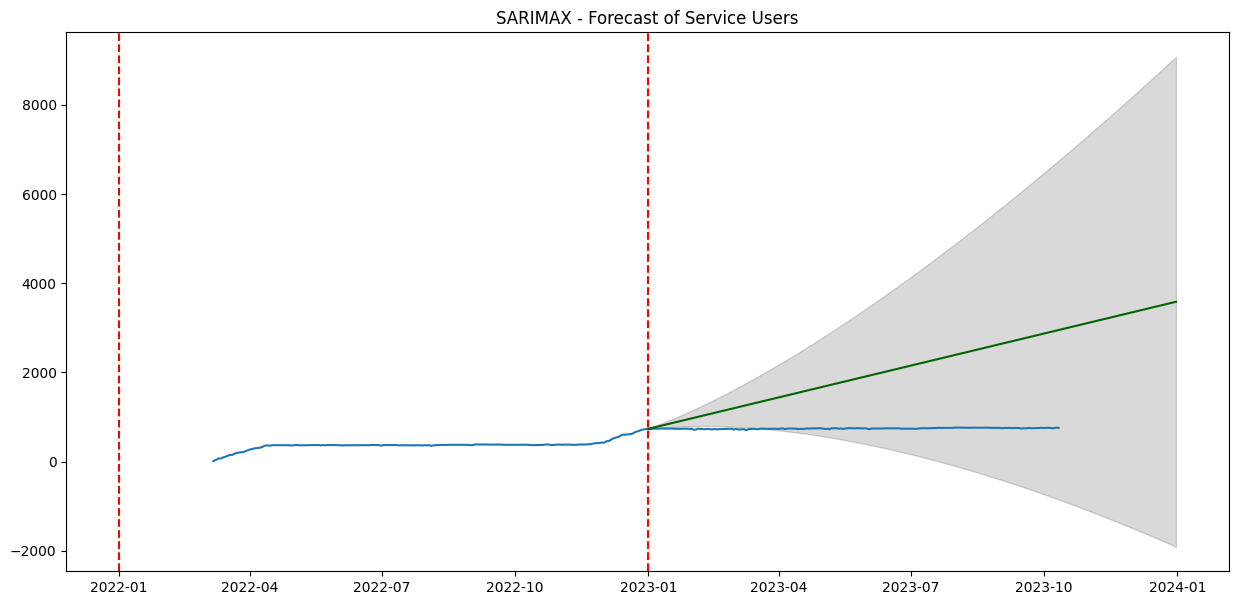

MSE:  1610989.0872437612
RMSE:  1269.2474491775672
MAE:  1100.1722496377392
West Queen West


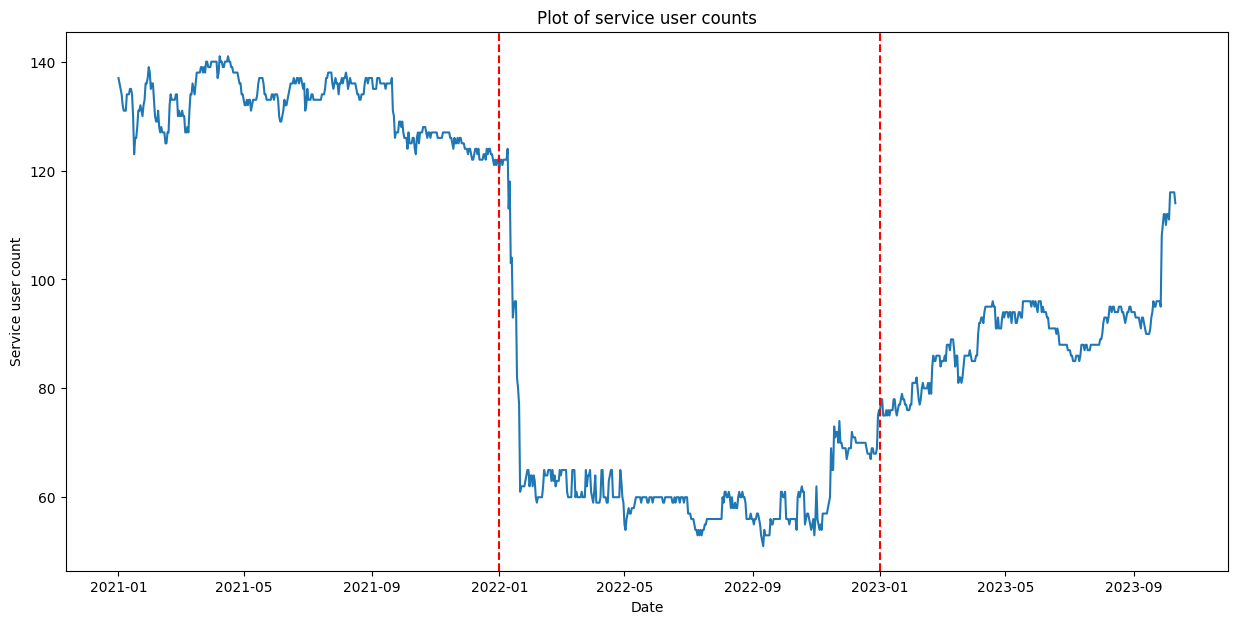

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(3,1,2)(0,0,0)[0]          


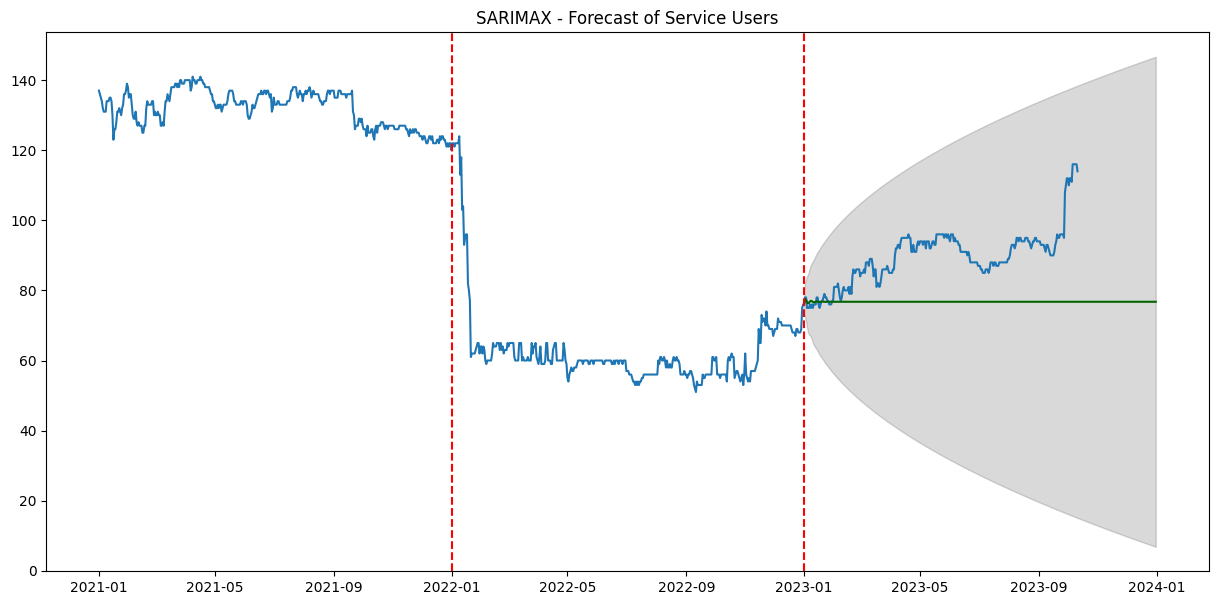

MSE:  229.7856782630999
RMSE:  15.158683262839814
MAE:  12.957589089628867
Wexford/Maryvale


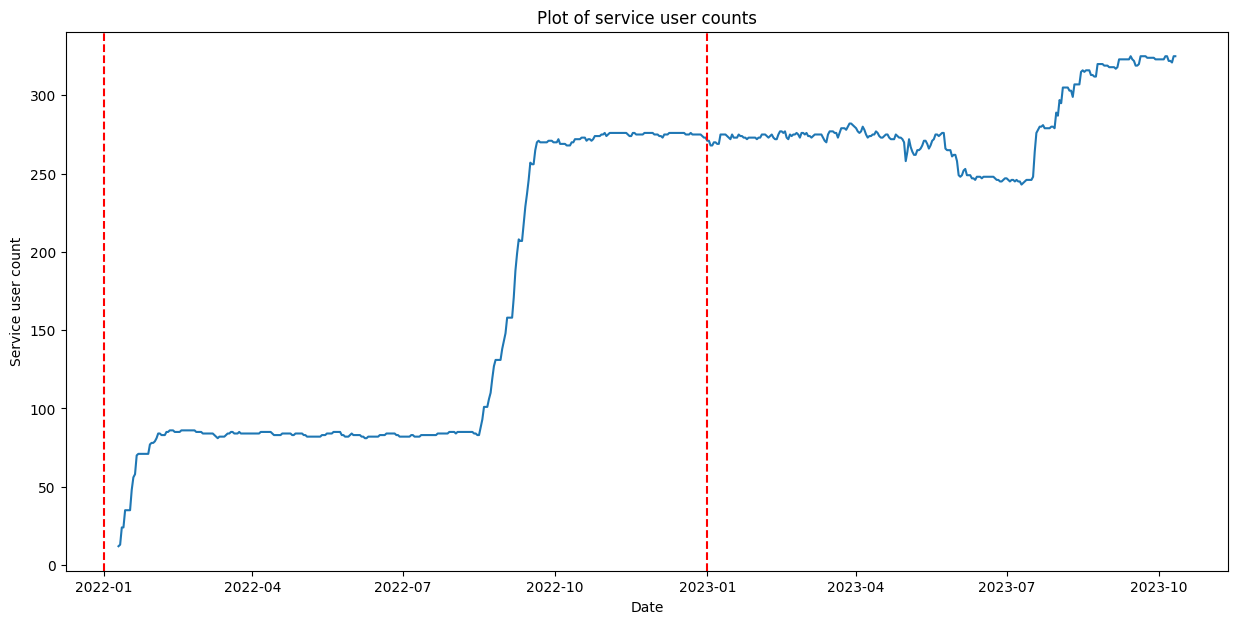

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,2,3)(0,0,0)[0]          


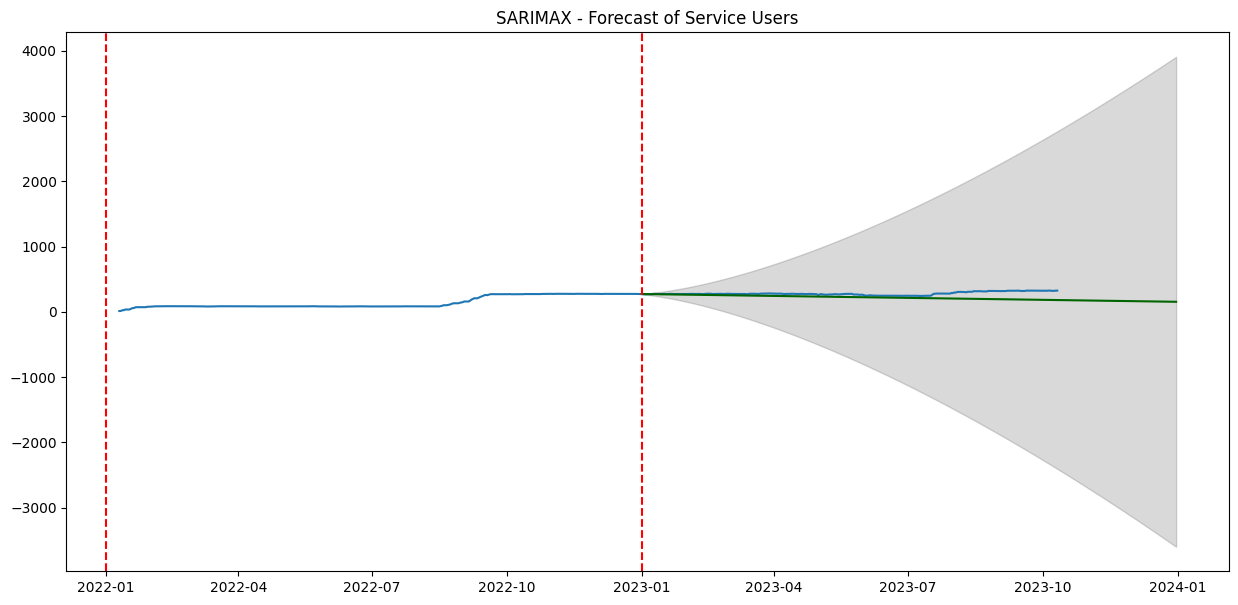

MSE:  4883.419410124554
RMSE:  69.88146685727592
MAE:  53.81509442184026
Woburn North


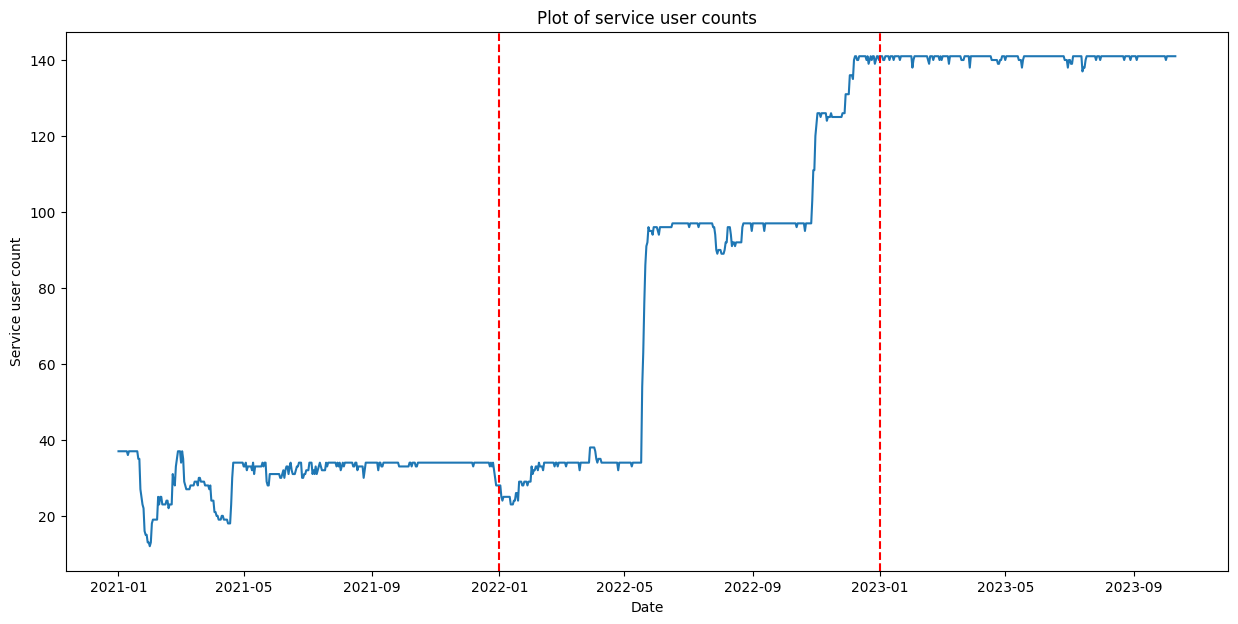

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(3,1,0)(0,0,0)[0]          


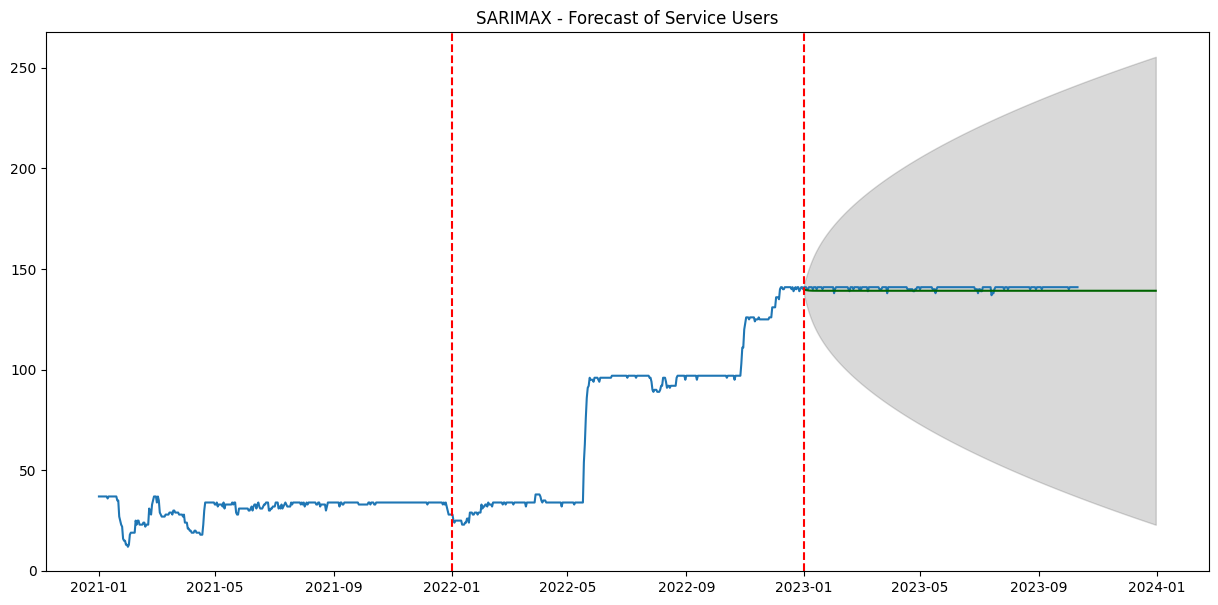

MSE:  2.6882747963356857
RMSE:  1.6395959247130634
MAE:  1.5889055256548563
Wychwood


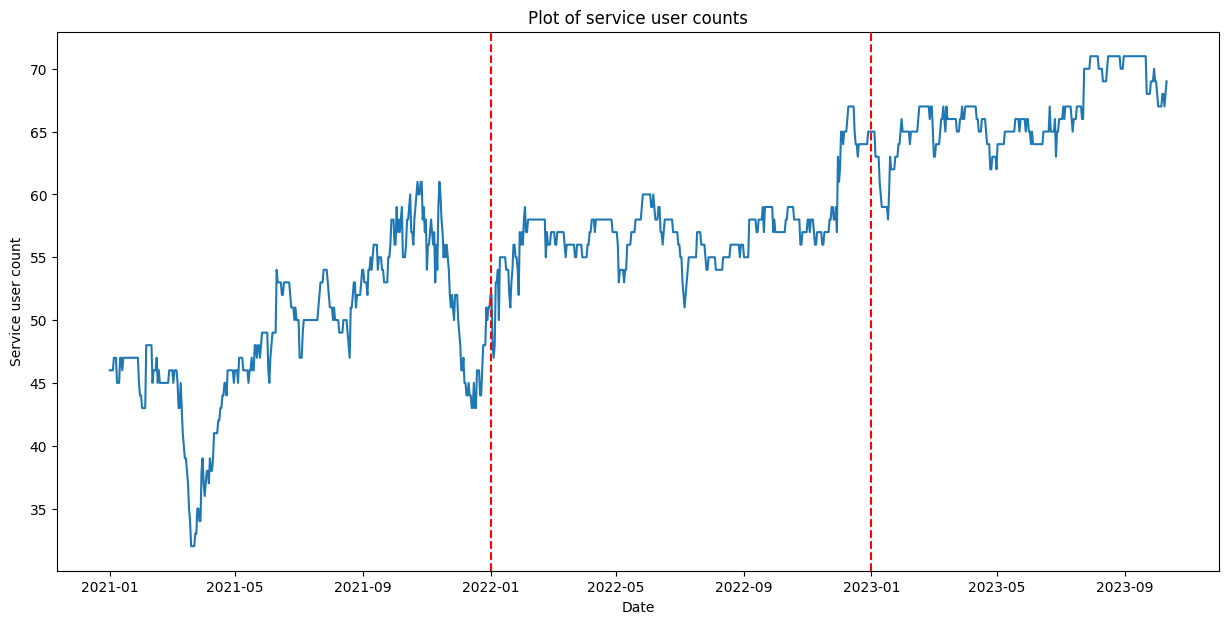

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,1)(0,0,0)[0]          


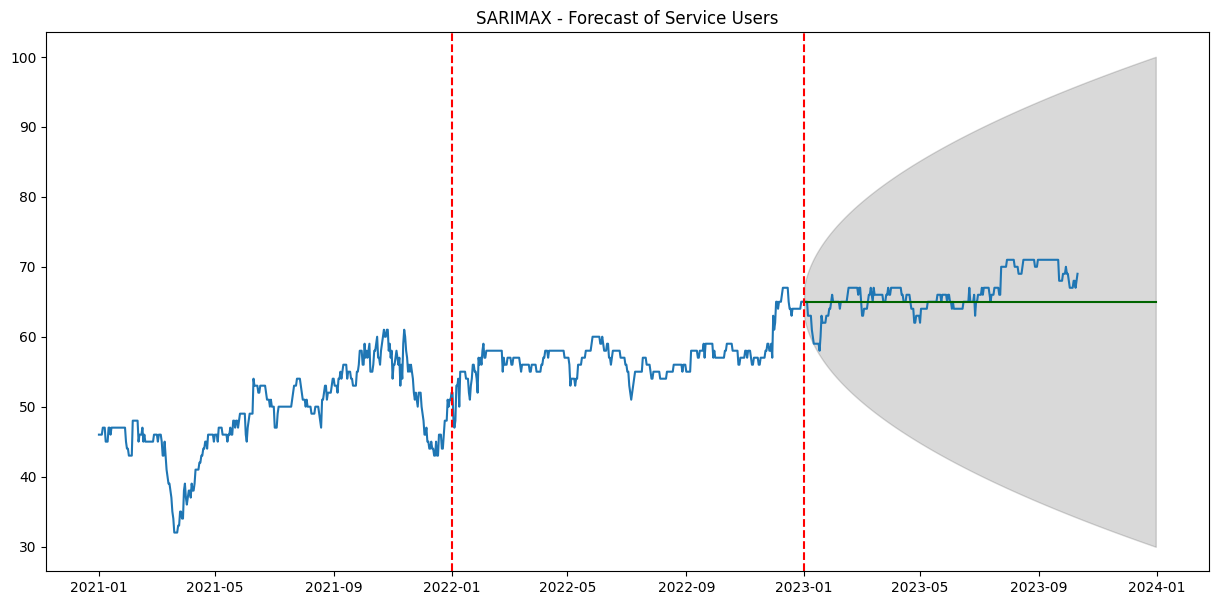

MSE:  9.95520673605134
RMSE:  3.1551872743232434
MAE:  2.336187971840202
Yonge-Bay Corridor


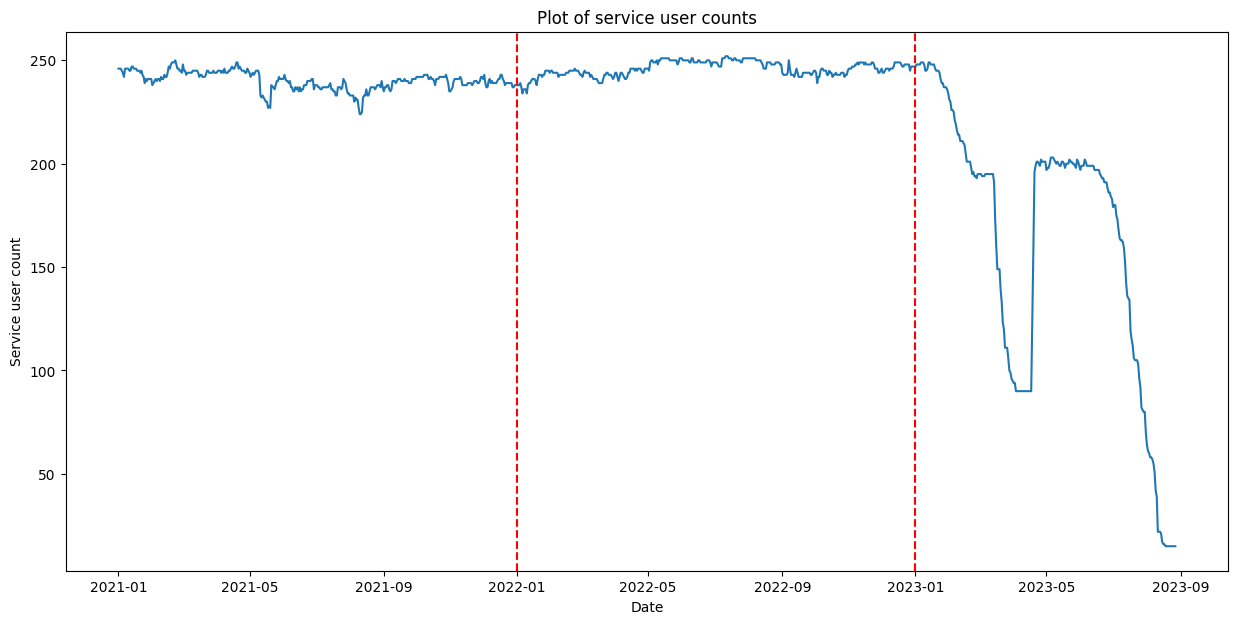

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,0,0)[0] intercept


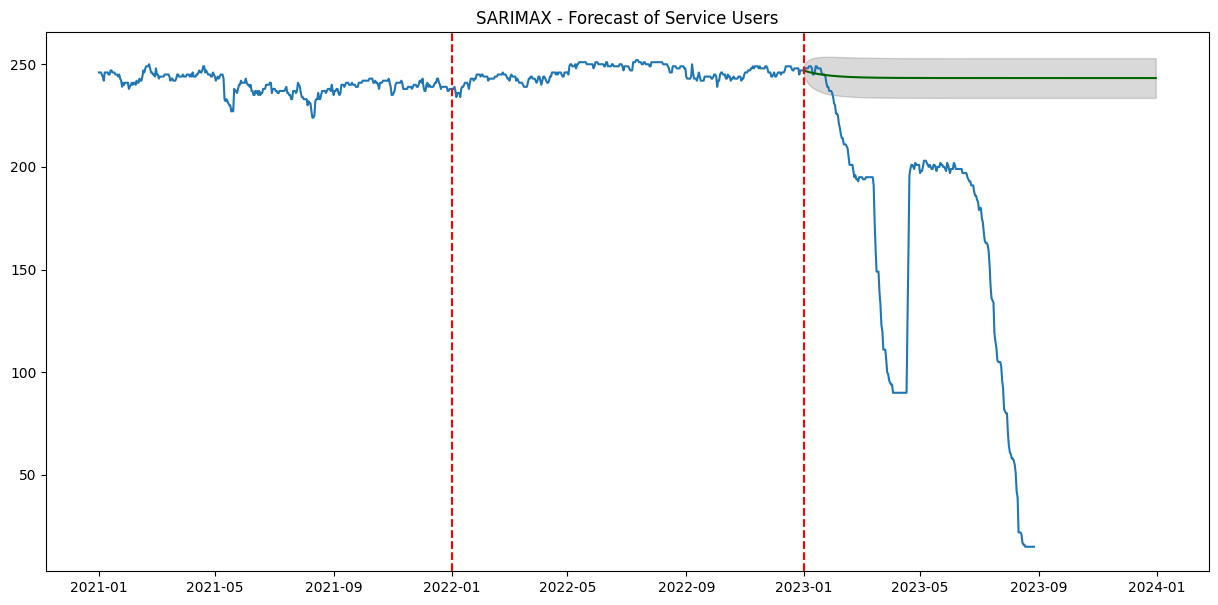

MSE:  10697.468749820897
RMSE:  103.42856834463531
MAE:  79.94225856796076
Yorkdale-Glen Park


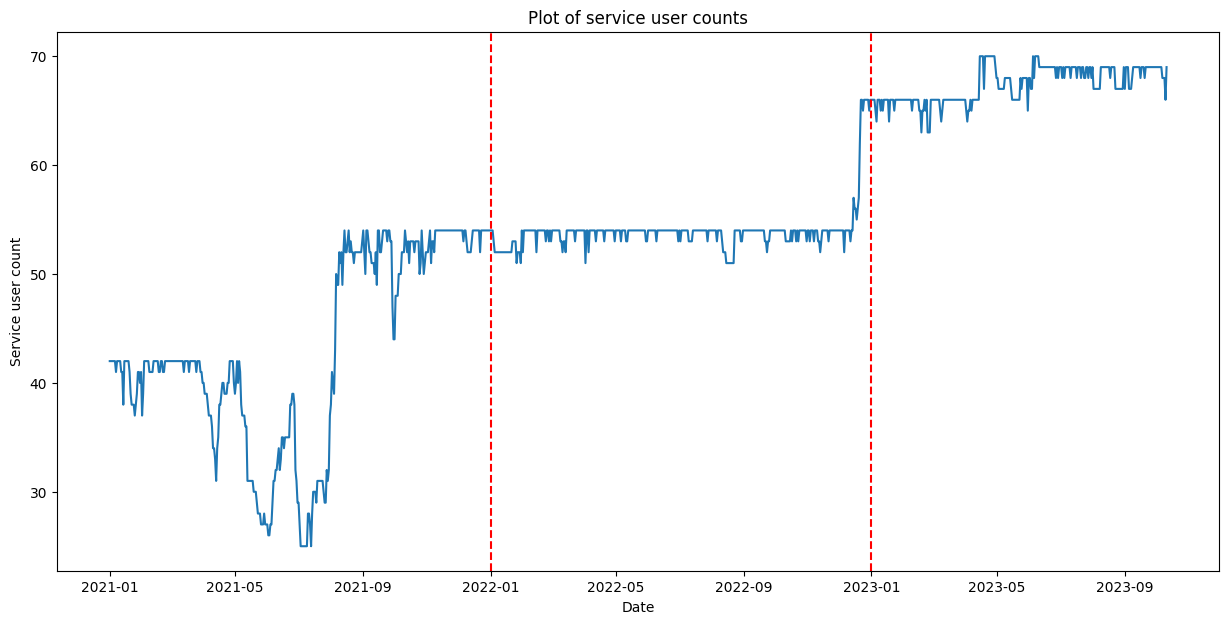

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,1)(0,0,0)[0]          


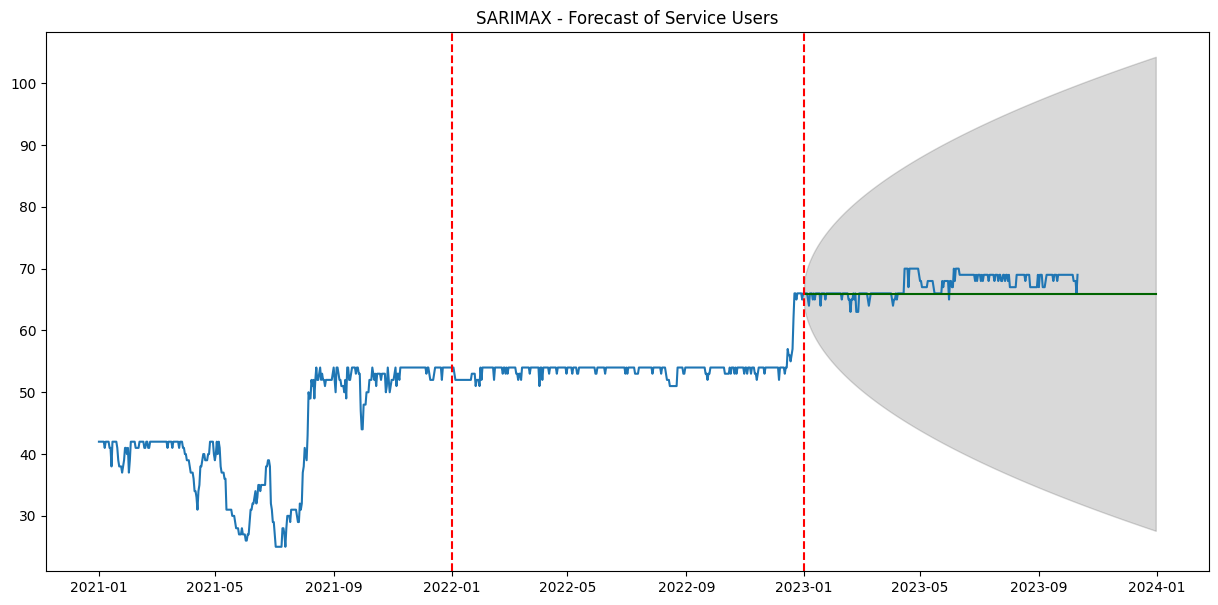

MSE:  4.836325328069349
RMSE:  2.1991646887100904
MAE:  1.715676829458315


In [29]:
# List of Neighbourhoods
neighbourhoods = np.sort(data["Neighbourhood"].unique())
# print(neighbourhoods)

# remove these neighbourhoods as they seem to have shelters removed
neighbourhoodsRemove = np.array(["Downsview", # missing data
                                 "St.Andrew-Windfields", # missing data
                                 "Trinity-Bellwoods", "Willowdale West", "Woodbine Corridor", "East Willowdale" , "Yonge-Doris"])
mask = ~np.isin(neighbourhoods, neighbourhoodsRemove)
neighbourhoods = neighbourhoods[mask]

# Conduct Analysis for each of the neighbourhoods
Eval_values = pd.DataFrame(columns=["Neighbourhood", "MSE", "RMSE" "MAE"])

for neighbourhood in neighbourhoods:
    print(neighbourhood)
    dataN, testN, trainN = subsetNeighbourhood(data1_exo, test1, train1, neighbourhood)
    plotData(dataN, testN, trainN)
    SARIMAX_model = timeseriesModel(trainN)
    fitted_series, lower_series, upper_series = plotTimeseries(SARIMAX_model, dataN, trainN, testN)
    mse, rmse, mae = calcEval(testN["SERVICE_USER_COUNT"], fitted_series)
    dataEval = [[neighbourhood, mse, rmse, mae]]
    valueEval = pd.DataFrame(dataEval, columns=["Neighbourhood", "MSE", "RMSE", "MAE"])
    Eval_values = pd.concat([Eval_values, valueEval])


In [30]:
Eval_values = Eval_values.drop(columns=["RMSEMAE"])
Eval_values

Neighbourhood           MSE         RMSE  \
0                                  Annex  3.783330e+01     6.150878   
0                    Bendale-Glen Andrew  4.996655e+02    22.353199   
0                        Broadview North  2.307039e+01     4.803165   
0                     Caledonia-Fairbank  5.494718e+01     7.412637   
0                       Church-Wellesley  4.289439e+01     6.549381   
0                     Dovercourt Village  1.210726e+02    11.003298   
0                    Downtown Yonge East  3.273662e+02    18.093264   
0                      East End-Danforth  1.420423e+01     3.768849   
0              Fort York-Liberty Village  1.437626e+01     3.791604   
0                 Harbourfront-CityPlace  2.050002e+02    14.317830   
0                      High Park-Swansea  8.724124e-01     0.934030   
0                      Hillcrest Village  3.128624e+02    17.687917   
0                          Junction Area  5.709126e+02    23.893777   
0               Junction-Wallace Emerson  4.084507e-01     0.639101   
0                           Kennedy Park  4.092508e+02    20.229949   
0                   Kensington-Chinatown  6.639085e+01     8.148058   
0                        Little Portugal  1.544373e+01     3.929851   
0                       Mimico-Queensway  1.187844e+01     3.446512   
0                              Moss Park  1.543507e+03    39.287491   
0                       Newtonbrook East  6.683150e+00     2.585179   
0                    North St.James Town  7.197170e+00     2.682754   
0                          North Toronto  1.018803e+03    31.918695   
0                        Oakwood Village  7.957746e+00     2.820948   
0                Palmerston-Little Italy  1.638732e+01     4.048126   
0                            Regent Park  8.647937e+00     2.940738   
0                    Rosedale-Moore Park  6.464308e+01     8.040092   
0                    Scarborough Village  8.747172e+01     9.352632   
0                         South Parkdale  2.400352e+01     4.899339   
0                        South Riverdale  2.267606e+01     4.761938   
0  St Lawrence-East Bayfront-The Islands  3.856780e+02    19.638686   
0           Thistletown-Beaumond Heights  5.829136e+02    24.143604   
0                             University  2.513028e+01     5.013011   
0                       Wellington Place  1.949955e+04   139.640780   
0                              West Hill  2.579261e+02    16.060077   
0                 West Humber-Clairville  1.610989e+06  1269.247449   
0                        West Queen West  2.297857e+02    15.158683   
0                       Wexford/Maryvale  4.883419e+03    69.881467   
0                           Woburn North  2.688275e+00     1.639596   
0                               Wychwood  9.955207e+00     3.155187   
0                     Yonge-Bay Corridor  1.069747e+04   103.428568   
0                     Yorkdale-Glen Park  4.836325e+00     2.199165   

           MAE  
0     5.126089  
0    20.942907  
0     4.429850  
0     3.742958  
0     3.657162  
0     7.663521  
0    14.577465  
0     1.915493  
0     2.878094  
0    10.076959  
0     0.872885  
0    15.845097  
0    22.594843  
0     0.274648  
0    18.596068  
0     6.130282  
0     3.820101  
0     2.063458  
0    29.188465  
0     2.049308  
0     2.449845  
0    21.205985  
0     1.619718  
0     3.394366  
0     2.497087  
0     7.279013  
0     8.460719  
0     1.919014  
0     3.838028  
0    17.879161  
0    22.436175  
0     3.623239  
0   118.792204  
0    13.214086  
0  1100.172250  
0    12.957589  
0    53.815094  
0     1.588906  
0     2.336188  
0    79.942259  
0     1.715677

In [31]:
# Find the average MSE, RMSE and MAE
print("MSE :", np.mean(Eval_values["MSE"]))
print("RMSE :", np.mean(Eval_values["RMSE"]))
print("MAE", np.mean(Eval_values["MAE"]))

MSE : 40319.630829833026
RMSE : 47.79750012883878
MAE 40.42883552340989


In [32]:
Eval_exc = Eval_values[Eval_values["Neighbourhood"] != "West Humber-Clairville"]  # less than 1 year testing data and huge jump present - from 0 - 700 users
Eval_exc = Eval_exc[Eval_exc["Neighbourhood"] != "Wexford/Maryvale"]  # less than 1 year of data present and huge jump present - from 0 - 300+
Eval_exc

Neighbourhood           MSE        RMSE         MAE
0                                  Annex     37.833295    6.150878    5.126089
0                    Bendale-Glen Andrew    499.665495   22.353199   20.942907
0                        Broadview North     23.070394    4.803165    4.429850
0                     Caledonia-Fairbank     54.947183    7.412637    3.742958
0                       Church-Wellesley     42.894390    6.549381    3.657162
0                     Dovercourt Village    121.072574   11.003298    7.663521
0                    Downtown Yonge East    327.366197   18.093264   14.577465
0                      East End-Danforth     14.204225    3.768849    1.915493
0              Fort York-Liberty Village     14.376262    3.791604    2.878094
0                 Harbourfront-CityPlace    205.000242   14.317830   10.076959
0                      High Park-Swansea      0.872412    0.934030    0.872885
0                      Hillcrest Village    312.862412   17.687917   15.845097
0                          Junction Area    570.912580   23.893777   22.594843
0               Junction-Wallace Emerson      0.408451    0.639101    0.274648
0                           Kennedy Park    409.250832   20.229949   18.596068
0                   Kensington-Chinatown     66.390845    8.148058    6.130282
0                        Little Portugal     15.443730    3.929851    3.820101
0                       Mimico-Queensway     11.878442    3.446512    2.063458
0                              Moss Park   1543.506970   39.287491   29.188465
0                       Newtonbrook East      6.683150    2.585179    2.049308
0                    North St.James Town      7.197170    2.682754    2.449845
0                          North Toronto   1018.803092   31.918695   21.205985
0                        Oakwood Village      7.957746    2.820948    1.619718
0                Palmerston-Little Italy     16.387324    4.048126    3.394366
0                            Regent Park      8.647937    2.940738    2.497087
0                    Rosedale-Moore Park     64.643084    8.040092    7.279013
0                    Scarborough Village     87.471717    9.352632    8.460719
0                         South Parkdale     24.003521    4.899339    1.919014
0                        South Riverdale     22.676056    4.761938    3.838028
0  St Lawrence-East Bayfront-The Islands    385.677992   19.638686   17.879161
0           Thistletown-Beaumond Heights    582.913622   24.143604   22.436175
0                             University     25.130282    5.013011    3.623239
0                       Wellington Place  19499.547428  139.640780  118.792204
0                              West Hill    257.926079   16.060077   13.214086
0                        West Queen West    229.785678   15.158683   12.957589
0                           Woburn North      2.688275    1.639596    1.588906
0                               Wychwood      9.955207    3.155187    2.336188
0                     Yonge-Bay Corridor  10697.468750  103.428568   79.942259
0                     Yorkdale-Glen Park      4.836325    2.199165    1.715677

In [33]:
# Find the average MSE, RMSE and MAE
print("MSE :", np.mean(Eval_exc["MSE"]))
print("RMSE :", np.mean(Eval_exc["RMSE"]))
print("MAE", np.mean(Eval_exc["MAE"]))

MSE : 954.6758299812407
RMSE : 15.912015108911456
MAE 12.912690061544252


TESTING FUNCTIONS

In [ ]:
# Generate a date range with the expected frequency
for neighbourhood in neighbourhoods: 
    dataN, testN, trainN = subsetNeighbourhood(data1_exo, test1, train1, neighbourhood)
    df = trainN
    expected_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

    # Find missing dates
    missing_dates = expected_date_range[~expected_date_range.isin(df.index)]

    # Display missing dates
    if not missing_dates.empty:
        print(neighbourhood, missing_dates)
        # else:
        #     print("No missing dates.")

In [18]:
neighbourhood = "Annex"
dataN, testN, trainN = subsetNeighbourhood(data1_exo, test1, train1, neighbourhood)
plotData(dataN, testN, trainN)
SARIMAX_model = timeseriesModel(trainN)
fitted_series, lower_series, upper_series = plotTimeseries(SARIMAX_model, dataN, trainN, testN)
print(fitted_series)
mse, rmse, mae = calcEval(testN["SERVICE_USER_COUNT"], fitted_series)
dataEval = [[neighbourhood, mse, rmse, mae]]
valueEval = pd.DataFrame(dataEval, columns=["Neighbourhood", "MSE", "RMSE", "MAE"])
# Eval_values = pd.concat([Eval_values, valueEval])

KeyboardInterrupt: 

In [ ]:
# Forecast
df = trainN
all = dataN
n_periods = 365

# get indices for new dataframe
forecast_df = pd.DataFrame({"day_index":pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D').day},
                index = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))


index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

# get predictions and confidence intervals
fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                        return_conf_int=True,
                                        index = index_of_fc
                                        )

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

Extract for 1 City - test Annex

In [ ]:
# extract city specific data
data_Annex = data1_exo[data1_exo["Neighbourhood"] == "Annex"] 
test_Annex = test1[test1["Neighbourhood"] == "Annex"]
train_Annex = train1[train1["Neighbourhood"] == "Annex"]

In [ ]:
# plot for Annex 
# plot train 
plt.figure(figsize=(15,7))
plt.title("Plot of service user counts")
plt.xlabel('Date')
plt.ylabel('Service user count')
plt.plot(train_Annex["SERVICE_USER_COUNT"])
plt.plot()
plt.axvline(x=pd.to_datetime("2022-01-01"), color="red", linestyle="--")
plt.show()

# plot test
plt.figure(figsize=(15,7))
plt.title("Plot of service user counts in Annex")
plt.xlabel('Date')
plt.ylabel('Service user count')
plt.plot(test_Annex["SERVICE_USER_COUNT"])
plt.plot()

plt.show()

# plot all  
plt.figure(figsize=(15,7))
plt.title("Plot of service user counts in Annex")
plt.xlabel('Date')
plt.ylabel('Service user count')
plt.plot(data_Annex["SERVICE_USER_COUNT"])
plt.plot()
plt.axvline(x=pd.to_datetime("2022-01-01"), color="red", linestyle="--")
plt.axvline(x=pd.to_datetime("2023-01-01"), color="red", linestyle="--")
plt.show()

In [ ]:
# perform the Dickey Fuller Test
import statsmodels.api as stats

result = stats.tsa.adfuller(train_Annex[['SERVICE_USER_COUNT']])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

From above, we know that the data is non-stationary

In [ ]:
#adding exogenous variable

# SARIMAX Model
SARIMAX_model = pm.auto_arima(train_Annex[['SERVICE_USER_COUNT']], 
                            #   exogenous=data_Annex.iloc[:, 2:],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, 
                           max_q=3, 
                           m=365,
                           seasonal_test=True,
                           seasonal=True,
                           # d=None, 
                           start_P = 1,
                           max_P = 3,
                           D=1,
                           error_action='ignore',  
                           suppress_warnings=False, 
                           stepwise=True,
                           n_jobs= -1,
                           stationary= True,
                           trace=True,
                           scoring='mse')

In [ ]:
SARIMAX_model.plot_diagnostics()


In [ ]:
# Forecast
df = train_Annex
all = data_Annex
n_periods = 365

# get inices for new dataframe
forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='D').day},
                index = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))

# get predictions and confidence intervals
fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                        return_conf_int=True,
                                        exogenous=forecast_df.iloc[:, 2:]
                                        )
index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,7))
plt.plot(all['SERVICE_USER_COUNT'], color='#1f76b4')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)

plt.title("SARIMAX - Forecast of Service Users")
plt.show()

In [ ]:
# show the predictions
def sarimax_forecast(SARIMAX_model, train, all , periods=365):
    # Forecast
    train = train
    all = all
    n_periods = periods

    # get inices for new dataframe
    forecast_df = pd.DataFrame({"month_index":pd.date_range(train.index[-1], periods = n_periods, freq='D').month},
                    index = pd.date_range(train.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))

    # get predictions and confidence intervals
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df.iloc[:, 2:])
    index_of_fc = pd.date_range(train.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(all['SERVICE_USER_COUNT'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Service Users")
    plt.show()